connectivity measruements across patients
DI, probabilities etc

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func
cwd             = os.getcwd()

##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

In [2]:
dist_groups = np.array([[0,15],[15,30],[30,5000]])
dist_labels = ['local (<15 mm)', 'short (<30mm)', 'long']

In [3]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3


#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((4,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])
color_elab[3,:] = np.array([1, 0.574, 0])

labels_region[labels_region=='HIPP'] = 'Mesiotemporal'
labels_region[labels_region=='HIPP '] = 'Mesiotemporal'
labels_region[labels_region=='ENT'] = 'Basotemporal'

## LL and Significant responses 

In [5]:
subjs = ['EL003', 'EL004', 'EL005', 'EL008','EL009', 'EL010', 'EL011']
# only Ph
subjs = ['EL004', 'EL005', 'EL008', 'EL010', 'EL012']
# only CR
subjs = ['EL010', 'EL011', 'EL012', 'EL013', 'EL014', 'EL015', 'EL016', 'EL017', 'EL019']

In [6]:
folder       = 'BrainMapping'
cond_folder = 'CR'

In [10]:
data_con_file = 'Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\General\data\data_con_all.csv'
if os.path.exists(data_con_file):
    data_con = pd.read_csv(data_con_file)
else:
 
    for i in range(len(subjs)):
        print('loading -- '+subjs[i], end='\r')
        subj = subjs[i]
        path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
        if not os.path.exists(path_gen):
            path_gen = 'T:\\EL_experiment\\Patients\\' + subj
        path_patient = path_gen + '\Data\EL_experiment'
        path_infos = os.path.join(path_patient, 'infos')
        if not os.path.exists(path_infos):
            path_infos = path_gen + '\\infos'
        path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
        summary_gen_path = path_patient_analysis + '\\' +folder + '\\' + cond_folder + '\\data\\summary_general.csv'
        data_A = pd.read_csv(summary_gen_path)

        lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
        labels_all      = lbls.label.values
        labels_clinic   = lbls.Clinic.values
        labels_region   = lbls.Region.values

        bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

        StimChanIx = np.unique(data_A.Stim)
        bad_chans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
        bad_chans = np.unique(np.array(np.where(bad_chans.values[:, 1:] == 1))[0, :])
        non_stim = np.arange(len(labels_all))
        non_stim = np.delete(non_stim, StimChanIx.astype('int'), 0)
        WM_chans = np.where(labels_region == 'WM')[0]
        bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')



        data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
        data_A.reset_index(drop=True)
        data_A.insert(0, 'Subj', subjs[i])
        data_A.insert(1, 'StimR', '0')
        data_A.insert(2, 'ChanR', '0')
        data_A.insert(1, 'StimA', '0')
        data_A.insert(2, 'ChanA', '0')
        data_A.insert(8, 'H', 0)
        for c in np.unique(data_A[['Chan', 'Stim']]).astype('int'):
            data_A.loc[data_A.Chan==c, 'ChanR'] = labels_region[c]
            data_A.loc[data_A.Stim==c, 'StimR'] = labels_region[c]
            data_A.loc[data_A.Chan==c, 'ChanA'] = " ".join(re.findall("[a-zA-Z_]+", labels_all[c]))
            data_A.loc[data_A.Stim==c, 'StimA'] = " ".join(re.findall("[a-zA-Z_]+", labels_all[c]))
            chans = data_A.loc[data_A.Stim==c, 'Chan'].values.astype('int')
            data_A.loc[data_A.Stim==c, 'H'] = np.array(lbls.Hemisphere[chans] != lbls.Hemisphere[c])*1
            #data_A.loc[data_A.Chan==c, 'Chan'] = labels_all[c]
            #data_A.loc[data_A.Stim==c, 'Stim'] = labels_all[c]
        #data_A = data_A[~np.isnan(data_A.N1.values)]

        stims = data_A.loc[data_A.Dir_index==1, 'Stim'].values
        chans = data_A.loc[data_A.Dir_index==1, 'Chan'].values

        for sc, rc in zip(stims, chans):
            data_A.loc[(data_A.Stim==rc)&(data_A.Chan==sc), 'Dir_index'] = -1 

        if i==0:
            data_con    = data_A
        else:
            data_con = pd.concat([data_con, data_A])   
            data_con = data_con.reset_index(drop=True)
    data_con.to_csv(data_con_file, header=True, index=False)

In [127]:
data_con[(data_con.Subj=='EL011')&(data_con.Dir_index <0.9)&(data_con.d <15)]

Subj  StimA  ChanA          StimR          ChanR  Stim  Chan       Sig  \
996   EL011  Tpole  Tpole  Mesiotemporal  Mesiotemporal   0.0   2.0  0.852792   
997   EL011  Tpole  Tpole  Mesiotemporal  Mesiotemporal   0.0   3.0  0.795122   
998   EL011  Tpole  Tpole  Mesiotemporal  Mesiotemporal   0.0   4.0  0.819512   
1000  EL011  Tpole   HIPP  Mesiotemporal  Mesiotemporal   0.0   6.0  0.864322   
1001  EL011  Tpole    ENT  Mesiotemporal   Basotemporal   0.0   7.0  0.815920   
...     ...    ...    ...            ...            ...   ...   ...       ...   
3024  EL011    LIG    LIG         Insula         Insula  73.0  76.0  0.994845   
3070  EL011    LIG    LIG         Insula         Insula  74.0  76.0  1.000000   
3116  EL011    LIG    LIG         Insula         Insula  75.0  73.0  0.975610   
3162  EL011    LIG    LIG         Insula         Insula  76.0  73.0  0.980296   
3163  EL011    LIG    LIG         Insula         Insula  76.0  74.0  0.990148   

      H    LL_sig  Dir_index  Dir_B  t_resp      d            Dist  
996   0  3.406532  -0.015433    2.0   0.000   7.00  local (<15 mm)  
997   0  2.627056  -0.041975    2.0   0.000  10.50  local (<15 mm)  
998   0  2.029672  -0.026312    2.0   0.000  14.00  local (<15 mm)  
1000  0  3.096199  -0.009648    2.0   0.000  14.28  local (<15 mm)  
1001  0  2.710779  -0.029047    2.0   0.022  11.46  local (<15 mm)  
...  ..       ...        ...    ...     ...    ...             ...  
3024  0  7.948426   0.000213    2.0   0.000  10.50  local (<15 mm)  
3070  0  8.428193   0.000097    2.0   0.000   7.00  local (<15 mm)  
3116  0  5.887628  -0.000595    2.0   0.000   7.00  local (<15 mm)  
3162  0  6.019993  -0.000213    2.0   0.000  10.50  local (<15 mm)  
3163  0  4.824478  -0.000097    2.0   0.000   7.00  local (<15 mm)  

[270 rows x 15 columns]

In [79]:
c = 87
s = 30
subj = 'EL019'
data_con.loc[(data_con.Subj==subj)&(data_con.Stim==c)&(data_con.Chan==s)]

Subj   StimA     ChanA         StimR          ChanR  Stim  Chan  \
20587  EL019  IFGopc  TransOrS  Dorsofrontal  Orbitofrontal  87.0  30.0   

            Sig  H    LL_sig  Dir_index  Dir_B  t_resp      d  Dist  
20587  0.871921  0  3.251174   0.255962    2.0     0.0  33.23  long

In [80]:
data_con.loc[(data_con.Subj==subj)&(data_con.Stim==s)&(data_con.Chan==c)]

Subj     StimA   ChanA          StimR         ChanR  Stim  Chan  \
18653  EL019  TransOrS  IFGopc  Orbitofrontal  Dorsofrontal  30.0  87.0   

            Sig  H    LL_sig  Dir_index  Dir_B  t_resp      d  Dist  
18653  0.399504  0  2.065942  -0.255962    2.0     0.0  33.23  long

In [37]:
nobs = df[xx].value_counts()
nobs = nobs[['local (<15 mm)', 'short (<30mm)', 'long']]

local (<15 mm)    2231
short (<30mm)     3303
long              3455
Name: Dist, dtype: int64

In [89]:
(np.sign(data_con.Dir_index)==1)|(data_con.Dir_index==0)

0         True
1        False
2         True
3        False
4         True
         ...  
20673    False
20674    False
20675    False
20676    False
20677     True
Name: Dir_index, Length: 20678, dtype: bool

In [107]:
data_con[data_con.Dir_index==-0]

Subj    StimA      ChanA           StimR           ChanR  Stim  Chan  \
0      EL010     HIPP    OTS_med   Mesiotemporal    Basotemporal   0.0   2.0   
25     EL010     HIPP       HIPP   Mesiotemporal   Mesiotemporal   0.0  54.0   
61     EL010  OTS_med       HIPP    Basotemporal   Mesiotemporal   2.0   0.0   
63     EL010  OTS_med        ITS    Basotemporal  Laterotemporal   2.0   7.0   
125    EL010      ITS    OTS_med  Laterotemporal    Basotemporal   7.0   2.0   
...      ...      ...        ...             ...             ...   ...   ...   
20564  EL019   IFGopc          U    Dorsofrontal         Unknown  86.0  83.0   
20565  EL019   IFGopc  LatS_vert    Dorsofrontal         Sylvian  86.0  84.0   
20566  EL019   IFGopc     IFGopc    Dorsofrontal    Dorsofrontal  86.0  88.0   
20621  EL019   IFGopc  LatS_vert    Dorsofrontal         Sylvian  87.0  85.0   
20677  EL019   IFGopc     IFGopc    Dorsofrontal    Dorsofrontal  88.0  86.0   

       Sig  H     LL_sig  Dir_index  Dir_B  t_resp      d            Dist  
0      1.0  0   8.664564        0.0    2.0     0.0   7.00  local (<15 mm)  
25     1.0  0   3.981850        0.0    2.0     0.0  19.79   short (<30mm)  
61     1.0  0   6.358977       -0.0    2.0     0.0   7.00  local (<15 mm)  
63     1.0  0   7.170132        0.0    2.0     0.0  17.50   short (<30mm)  
125    1.0  0   4.552442       -0.0    2.0     0.0  17.50   short (<30mm)  
...    ... ..        ...        ...    ...     ...    ...             ...  
20564  1.0  0  11.070696       -0.0    2.0     0.0  10.50  local (<15 mm)  
20565  1.0  0  11.771544       -0.0    2.0     0.0   7.00  local (<15 mm)  
20566  1.0  0  10.808463        0.0    2.0     0.0   7.00  local (<15 mm)  
20621  1.0  0   7.140592       -0.0    2.0     0.0   7.00  local (<15 mm)  
20677  1.0  0   4.371156       -0.0    2.0     0.0   7.00  local (<15 mm)  

[627 rows x 15 columns]

In [134]:
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
f.groupby('C').agg([percentile(50), percentile(95)])

In [132]:
yy = 'Dir_index'

In [137]:
df.groupby([xx], as_index=False)[[yy]].agg([percentile(25),percentile(50), percentile(75)])

Dir_index                            
               percentile_25 percentile_50 percentile_75
Dist                                                    
local (<15 mm)      0.000006      0.001479      0.057956
long                0.238033      1.000000      1.000000
short (<30mm)       0.014089      0.191148      1.000000

In [118]:
scipy.stats.ranksums(df.loc[df.Dist==x_order[1],yy].values,df.loc[df.Dist==x_order[2],yy].values)

RanksumsResult(statistic=-27.270771502775947, pvalue=9.426445454835912e-164)

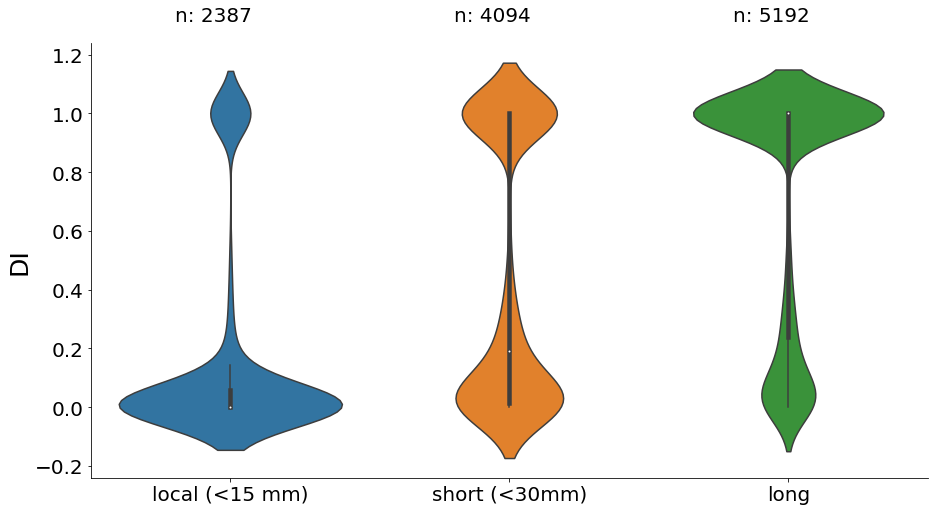

In [136]:
xx = 'Dist'
yy = 'Dir_index'
x_order = ['local (<15 mm)', 'short (<30mm)', 'long']
df = data_con[(~np.isnan(data_con.Dir_index))]
#df = data_con[(data_con.Sig>0)]
df = df.reset_index(drop=True)
df.Dir_index = abs(df.Dir_index)
plt.figure(figsize=(15,8))
ax = sns.violinplot(y=yy, x=xx, data=df, order= x_order )
medians = df.groupby([xx])[yy].median().values
nobs = df[xx].value_counts()
nobs = nobs[x_order].values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(tick-0.2,1.3,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('DI',fontsize=25)
plt.xlabel('',fontsize=25)
sns.despine()
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\General\Dist_DI.svg')

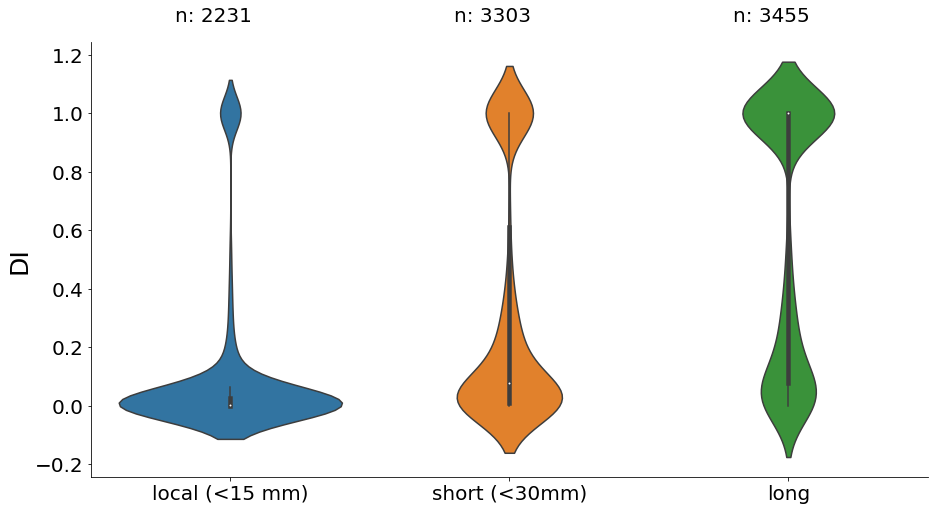

In [108]:
xx = 'Dist'
yy = 'Dir_index'
x_order = ['local (<15 mm)', 'short (<30mm)', 'long']
#df = data_con[(~np.isnan(data_con.Dir_index))]
df = data_con[(data_con.Sig>0)]
df = df.reset_index(drop=True)
df.Dir_index = abs(df.Dir_index)
plt.figure(figsize=(15,8))
ax = sns.violinplot(y=yy, x=xx, data=df, order= x_order )
medians = df.groupby([xx])[yy].median().values
nobs = df[xx].value_counts()
nobs = nobs[x_order].values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(tick-0.2,1.3,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('DI',fontsize=25)
plt.xlabel('',fontsize=25)
sns.despine()

In [114]:
scipy.stats.ranksums(df.loc[df.Dist==x_order[1],yy].values,df.loc[df.Dist==x_order[0],yy].values)

RanksumsResult(statistic=-34.0661586352204, pvalue=2.3398243559001597e-254)

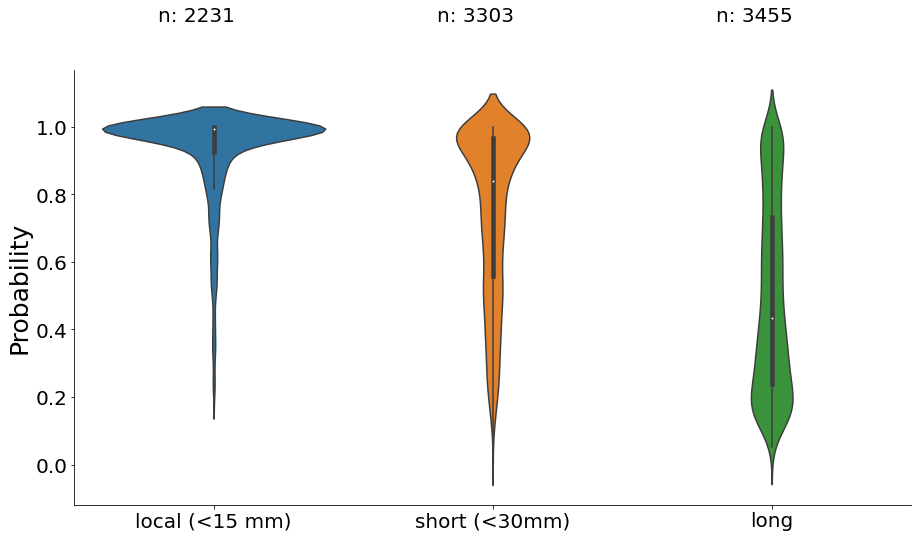

In [121]:
xx = 'Dist'
yy = 'Sig'
x_order = ['local (<15 mm)', 'short (<30mm)', 'long']
df = data_con[(data_con.Sig>0)]
plt.figure(figsize=(15,8))
ax = sns.violinplot(y=yy, x=xx, data=df, order= x_order )
medians = df.groupby([xx])[yy].median().values
nobs = df[xx].value_counts()
nobs = nobs[x_order].values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(tick-0.2,1.3,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Probability',fontsize=25)
plt.xlabel('',fontsize=25)
sns.despine()
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\General\Prob_DI.svg')

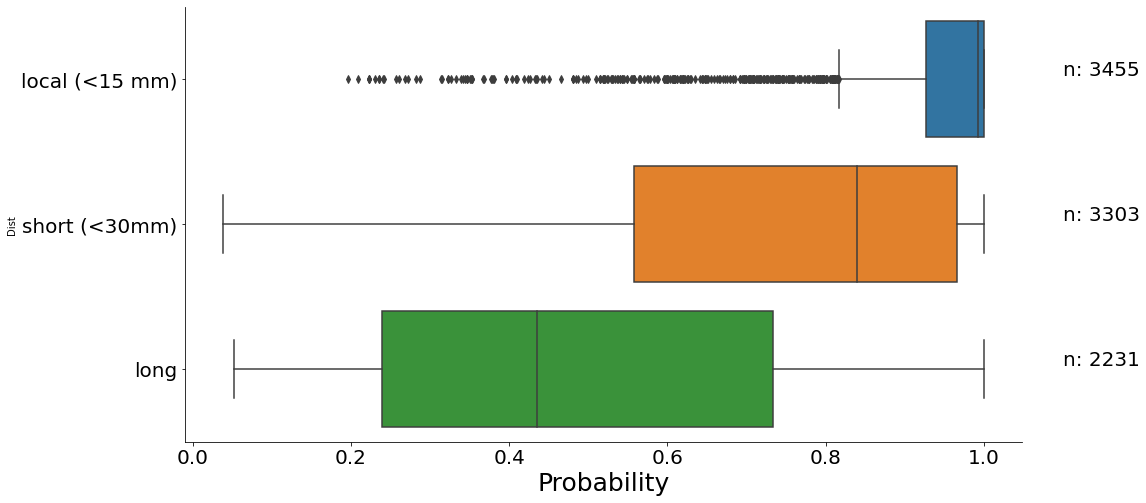

In [21]:
yy = 'Dist'
xx = 'Sig'
df = data_con[data_con.Sig>0]
plt.figure(figsize=(15,8))
ax = sns.boxplot(y=yy, x=xx, data=df, order= ['local (<15 mm)', 'short (<30mm)', 'long'])
medians = df.groupby([yy])[xx].median().values
nobs = df[yy].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(1.1,tick,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Probability',fontsize=25)
sns.despine()

In [7]:
for i in range(len(subjs)):
    print('loading -- '+subjs[i], end='\r')
    subj = subjs[i]
    path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
    if not os.path.exists(path_gen):
        path_gen = 'T:\\EL_experiment\\Patients\\' + subj
    path_patient = path_gen + '\Data\EL_experiment'
    path_infos = os.path.join(path_patient, 'infos')
    if not os.path.exists(path_infos):
        path_infos = path_gen + '\\infos'
    path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    
    file_bm_auc = path_patient_analysis + '\\BrainMapping\\' + cond_folder + '\\data\\BM_AUC_connection.csv'
    data_A = pd.read_csv(file_bm_auc)
    
    lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
    labels_all      = lbls.label.values
    labels_clinic   = lbls.Clinic.values
    labels_region   = lbls.Region.values
    
    bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]
    
    StimChanIx = np.unique(data_A.Stim)
    bad_chans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
    bad_chans = np.unique(np.array(np.where(bad_chans.values[:, 1:] == 1))[0, :])
    non_stim = np.arange(len(labels_all))
    non_stim = np.delete(non_stim, StimChanIx.astype('int'), 0)
    WM_chans = np.where(labels_region == 'WM')[0]
    bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')
        
    # data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
    data_A.reset_index(drop=True)
    data_A.insert(0, 'Subj', subjs[i])
    data_A.insert(1, 'StimR', '0')
    data_A.insert(2, 'ChanR', '0')
    for c in np.unique(data_A[['Chan', 'Stim']]).astype('int'):
        data_A.loc[data_A.Chan==c, 'ChanR'] = labels_region[c]
        data_A.loc[data_A.Stim==c, 'StimR'] = labels_region[c]
        #data_A.loc[data_A.Chan==c, 'Chan'] = labels_all[c]
        #data_A.loc[data_A.Stim==c, 'Stim'] = labels_all[c]
    #data_A = data_A[~np.isnan(data_A.N1.values)]
    if i==0:
        data_con    = data_A
    else:
        data_con = pd.concat([data_con, data_A])   
        data_con = data_con.reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: 'y:\\eLab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\EL019\\BrainMapping\\CR\\data\\BM_AUC_connection.csv'

## Plots

([<matplotlib.axis.YTick at 0x24a063be788>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

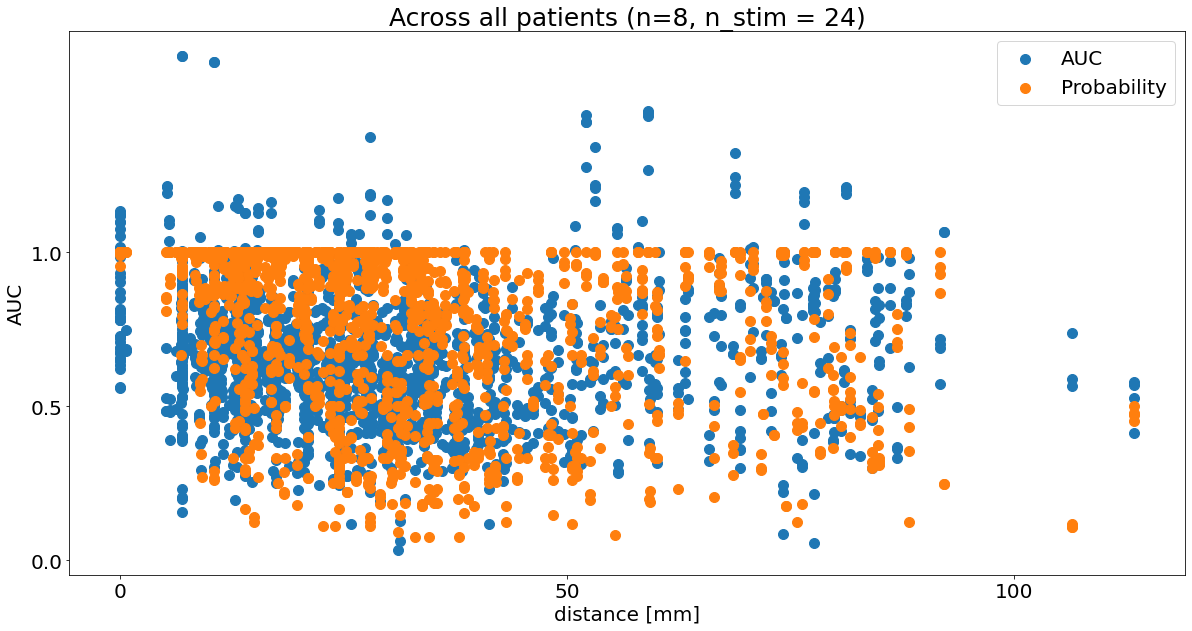

In [189]:
plt.figure(figsize=(20,10))
data_plot = data_con[(data_con.Sig>0)]
plt.scatter(data_plot.d, data_plot.AUC, label ='AUC', s= 100)
plt.scatter(data_plot.d, data_plot.Sig, label ='Probability', s = 100)
plt.legend(fontsize=20)
plt.title('Across all patients (n=8, n_stim = 24)', fontsize=25)
# sns.scatterplot(x='d', y='AUC',data=, s= 100 )
# sns.scatterplot(x='d', y='Sig',data=data_AUC_Prob[(data_AUC_Prob.Stim==sc)&(data_AUC_Prob.SleepState=='Wake')&(data_AUC_Prob.Sig>0)], s= 100 )

plt.ylabel('AUC', fontsize=20)
plt.xlabel('distance [mm]', fontsize=20)
plt.xticks([0, 50, 100], fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)

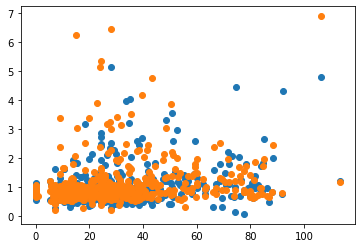

In [207]:
data_plot = data_con[(data_con.SleepState=='Wake')& (data_con.Sig>0)]
plt.scatter(data_plot.d, data_plot.AUC/data_plot.Sig)

data_plot = data_con[(data_con.SleepState=='NREM')& (data_con.Sig>0)]
plt.scatter(data_plot.d, data_plot.AUC/data_plot.Sig)

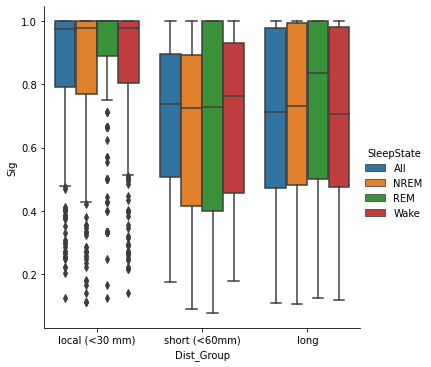

In [202]:
data_plot = data_con[(data_con.Sig>0)]
sns.catplot(x='Dist_Group', y='Sig', hue='SleepState', data=data_plot, kind='box')

(0.0, 1.0)

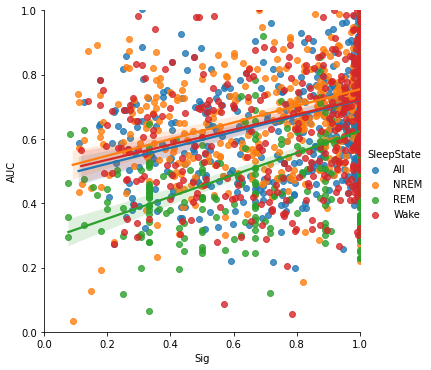

In [208]:
dat_plot = data_con[(data_con.Sig>0)]
sns.lmplot(x="Sig", y="AUC", hue='SleepState', data=dat_plot)
plt.ylim([0,1])
plt.xlim([0,1])

<AxesSubplot:xlabel='d', ylabel='AUC'>

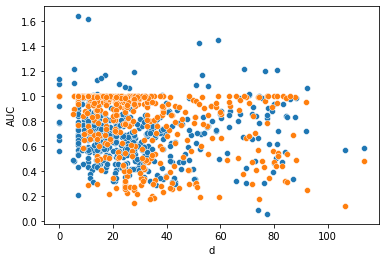

In [169]:
sns.scatterplot(x='d', y='AUC', data=data_con[(data_con.Sig>0)&(data_con.SleepState=='Wake')])
sns.scatterplot(x='d', y='Sig', data=data_con[(data_con.Sig>0)&(data_con.SleepState=='Wake')])

In [191]:
dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']

In [196]:
data_con

Subj          StimR           ChanR  Stim  Chan       Sig    LL_sig  \
0     EL010  Mesiotemporal    Basotemporal   0.0   2.0  1.000000  8.664564   
1     EL010  Mesiotemporal  Laterotemporal   0.0   6.0  0.000000       NaN   
2     EL010  Mesiotemporal  Laterotemporal   0.0   7.0  0.688525  2.751050   
3     EL010  Mesiotemporal  Laterotemporal   0.0   8.0  0.000000       NaN   
4     EL010  Mesiotemporal  Superotemporal   0.0   9.0  0.750000  2.529343   
...     ...            ...             ...   ...   ...       ...       ...   
2876  EL017         Insula          Insula  44.0  47.0  1.000000  5.483812   
2877  EL017         Insula    Dorsofrontal  44.0  48.0  1.000000  5.778658   
2878  EL017         Insula    Dorsofrontal  44.0  48.0  1.000000  4.445370   
2879  EL017         Insula    Dorsofrontal  44.0  49.0  1.000000  4.325657   
2880  EL017         Insula    Dorsofrontal  44.0  49.0  1.000000  3.236553   

          Dist_Group SleepState      d       AUC    LL_int  
0     local (<30 mm)        All   7.00  0.876806  1.018938  
1     local (<30 mm)        All  21.00  0.682207  0.827069  
2     local (<30 mm)        All  24.50  0.354752  0.770404  
3     local (<30 mm)        All  28.00  0.612670  0.949227  
4      short (<60mm)        All  55.76  0.311917  0.433517  
...              ...        ...    ...       ...       ...  
2876  local (<30 mm)        REM  10.06  0.653934  0.569177  
2877  local (<30 mm)       NREM  10.19  0.656066  0.508974  
2878  local (<30 mm)        REM  10.19  0.571347  0.395482  
2879  local (<30 mm)       NREM  11.44  0.633102  0.520755  
2880  local (<30 mm)        REM  11.44  0.530563  0.357434  

[2881 rows x 12 columns]

In [192]:
#data_con.insert(7, 'Dist_Group', 0)
for i in range(len(dist_labels)):
    data_con.loc[(data_con.d<dist_groups[i,1])&(data_con.d>=dist_groups[i,0]),'Dist_Group' ] = dist_labels[i]

In [163]:
for i in range(len(subjs)):
    print('loading -- '+subjs[i], end='\r')
    subj = subjs[i]
    path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
    if not os.path.exists(path_gen):
        path_gen = 'T:\\EL_experiment\\Patients\\' + subj
    path_patient = path_gen + '\Data\EL_experiment'
    path_infos = os.path.join(path_patient, 'infos')
    if not os.path.exists(path_infos):
        path_infos = path_gen + '\\infos'
    path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    
    file_bm_auc = path_patient_analysis + '\\BrainMapping\\' + cond_folder + '\\data\\BM_AUC_connection.csv'
    data_A = pd.read_csv(file_bm_auc)
    
    lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
    labels_all      = lbls.label.values
    labels_clinic   = lbls.Clinic.values
    labels_region   = lbls.Region.values
    
    bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]
    
    StimChanIx = np.unique(data_A.Stim)
    bad_chans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
    bad_chans = np.unique(np.array(np.where(bad_chans.values[:, 1:] == 1))[0, :])
    non_stim = np.arange(len(labels_all))
    non_stim = np.delete(non_stim, StimChanIx.astype('int'), 0)
    WM_chans = np.where(labels_region == 'WM')[0]
    bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')
        
    
    
    
    # data_A = data_A[~np.isin(data_A.Chan,bad_all)&~np.isin(data_A.Stim,bad_all)]
    data_A.reset_index(drop=True)
    data_A.insert(0, 'Subj', subjs[i])
    data_A.insert(1, 'StimR', '0')
    data_A.insert(2, 'ChanR', '0')
    for c in np.unique(data_A[['Chan', 'Stim']]).astype('int'):
        data_A.loc[data_A.Chan==c, 'ChanR'] = labels_region[c]
        data_A.loc[data_A.Stim==c, 'StimR'] = labels_region[c]
        #data_A.loc[data_A.Chan==c, 'Chan'] = labels_all[c]
        #data_A.loc[data_A.Stim==c, 'Stim'] = labels_all[c]
    #data_A = data_A[~np.isnan(data_A.N1.values)]
    if i==0:
        data_con    = data_A
    else:
        data_con = pd.concat([data_con, data_A])   
        data_con = data_con.reset_index(drop=True)

In [14]:
i = 0
print('loading -- '+subjs[i], end='\r')
subj = subjs[i]
path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')


path_patient_analysis = 'y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
summary_gen_path = path_patient_analysis + '\\' +folder + '\\' + cond_folder + '\\data\\summary_general.csv'
data_A = pd.read_csv(summary_gen_path)

In [35]:
bad_all

NameError: name 'bad_all' is not defined

In [428]:
len(subjs)

8

In [430]:
len(data_con[data_con.Sig>0])

7293

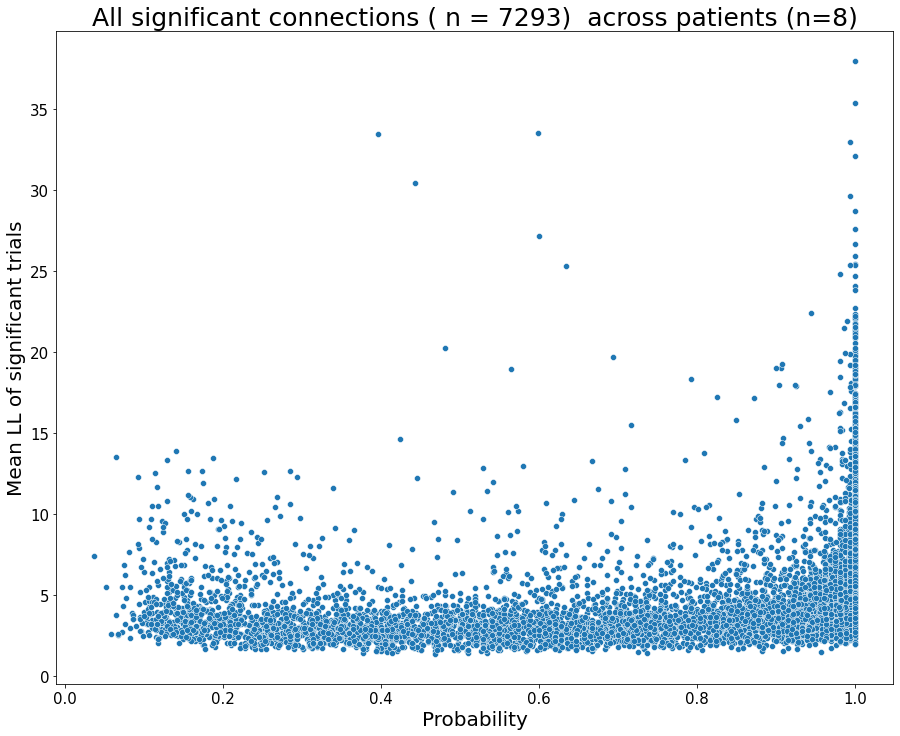

In [437]:
plt.figure(figsize=(15,12))
plt.title('All significant connections ( n = 7293)  across patients (n=8)', fontsize=25)
sns.scatterplot(x='Sig', y= 'LL_sig', data=data_con[data_con.Sig>0]) # , hue='Dist'
plt.ylabel('Mean LL of significant trials', fontsize=20)
plt.xlabel('Probability', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\General\Prob_LL.svg')
plt.show()

In [424]:
data_con

Subj StimA    ChanA          StimR           ChanR  Stim  Chan  \
0      EL010  HIPP  OTS_med  Mesiotemporal    Basotemporal   0.0   2.0   
1      EL010  HIPP      ITS  Mesiotemporal  Laterotemporal   0.0   6.0   
2      EL010  HIPP      ITS  Mesiotemporal  Laterotemporal   0.0   7.0   
3      EL010  HIPP      ITS  Mesiotemporal  Laterotemporal   0.0   8.0   
4      EL010  HIPP   RostrS  Mesiotemporal   Orbitofrontal   0.0  18.0   
...      ...   ...      ...            ...             ...   ...   ...   
17485  EL017   SFS   IFGopc   Dorsofrontal    Dorsofrontal  59.0  49.0   
17486  EL017   SFS      IFS   Dorsofrontal    Dorsofrontal  59.0  53.0   
17487  EL017   SFS      IFS   Dorsofrontal    Dorsofrontal  59.0  54.0   
17488  EL017   SFS      IFS   Dorsofrontal    Dorsofrontal  59.0  55.0   
17489  EL017   SFS      SFS   Dorsofrontal    Dorsofrontal  59.0  57.0   

            Sig  H    LL_sig  Dir_index  Dir_B  t_resp      d            Dist  
0      1.000000  0  8.664564   0.000000    2.0   0.000   7.00  local (<15 mm)  
1      0.000000  0       NaN  -1.000000    0.0   0.000  21.00   short (<30mm)  
2      0.688525  0  2.751050   0.000052    2.0   0.018  24.50   short (<30mm)  
3      0.000000  0       NaN        NaN    0.0   0.000  28.00   short (<30mm)  
4      0.189655  0  3.041286   1.000000    1.0   0.000  70.34            long  
...         ... ..       ...        ...    ...     ...    ...             ...  
17485  0.000000  0       NaN  -1.000000    0.0   0.052  52.41            long  
17486  0.647059  0  2.629726  -0.091912    2.0   0.000  21.00   short (<30mm)  
17487  0.000000  0       NaN  -1.000000    0.0   0.000  17.50   short (<30mm)  
17488  1.000000  0  4.248322  -0.000000    2.0   0.000  14.00  local (<15 mm)  
17489  1.000000  0  8.450292   0.013841    2.0   0.000   7.00  local (<15 mm)  

[17490 rows x 15 columns]

In [4]:
node_grouping = 'region'
node_order = 'area'

nodes = [n for n, d in sorted(G.nodes(data=True),
                        key=lambda x: (
                            x[1][node_grouping],
                            x[1][node_order],
                        ),
                    )
                ]

NameError: name 'G' is not defined

In [378]:
data_con_sig  = data_con.copy()
#data_con_sig = data_con_sig[data_con_sig.Sig>0]
#data_con_sig = data_con_sig[data_con_sig.Dir_index>=0]

In [665]:
df = data_con_sig.groupby(['StimR', 'ChanR'], as_index=False)[['Dir_index']].mean()
df['Dir_index'] = np.round(df['Dir_index'] ,2)
df_p = df.pivot("StimR", "ChanR", "Dir_index")

In [672]:
df_p

ChanR           Basotemporal  Central  Cingular  Dorsofrontal  Insula  \
ChanR                                                                   
Insula                   NaN    -1.00     -1.00         -1.00    0.16   
Basotemporal            0.02    -0.50       NaN         -0.00    0.00   
Mesiotemporal          -1.00    -0.60       NaN          0.60    0.16   
Laterotemporal         -0.20    -0.43      0.33          0.00    0.00   
Superotemporal           NaN    -0.00       NaN         -0.33     NaN   
Dorsofrontal           -0.15    -0.54     -1.00         -0.47   -0.13   
Orbitofrontal          -0.03      NaN       NaN          1.00    1.00   
Parietal                1.00     0.00      0.00          0.43    0.50   
Occipital              -0.63     0.07     -0.18          0.01    0.27   
Central                -0.00    -1.00       NaN          0.20   -0.02   
Cingular                0.04    -0.71       NaN          0.44    0.32   
Sylvian                 1.00    -0.54       NaN          0.25    0.08   

ChanR           Laterotemporal  Mesiotemporal  Occipital  Orbitofrontal  \
ChanR                                                                     
Insula                   -0.46          -0.21      -1.00          -1.00   
Basotemporal              0.13          -0.32      -1.00          -0.16   
Mesiotemporal             0.18          -0.11        NaN           0.00   
Laterotemporal            0.47          -0.44      -1.00          -0.60   
Superotemporal            1.00            NaN        NaN            NaN   
Dorsofrontal             -0.00          -0.05      -0.40          -0.18   
Orbitofrontal             0.40          -0.55       0.00            NaN   
Parietal                  0.54           0.71        NaN           0.60   
Occipital                 0.02          -0.62      -0.49           1.00   
Central                   0.15          -0.04       0.03           1.00   
Cingular                  0.05          -0.00       0.55           0.11   
Sylvian                   0.44            NaN        NaN           0.00   

ChanR           Parietal  Superotemporal  Sylvian  
ChanR                                              
Insula             -0.35            0.00     0.00  
Basotemporal       -0.27           -0.16    -0.08  
Mesiotemporal      -1.00            1.00    -0.00  
Laterotemporal     -0.01            1.00    -0.25  
Superotemporal      0.18            1.00      NaN  
Dorsofrontal       -0.02            0.46    -0.44  
Orbitofrontal       0.49            1.00      NaN  
Parietal           -0.07            1.00     0.54  
Occipital          -0.00            0.35    -0.00  
Central             0.63             NaN    -1.00  
Cingular            0.62            0.21      NaN  
Sylvian             0.00            0.00      NaN

In [671]:
df_p.index = pd.CategoricalIndex(df_p.index, categories= regions_order)
df_p.index = pd.CategoricalIndex(df_p.columns, categories= regions_order)
df_p.sort_index(level=0, inplace=True)
df_p.sort_index(level=1, inplace=True)

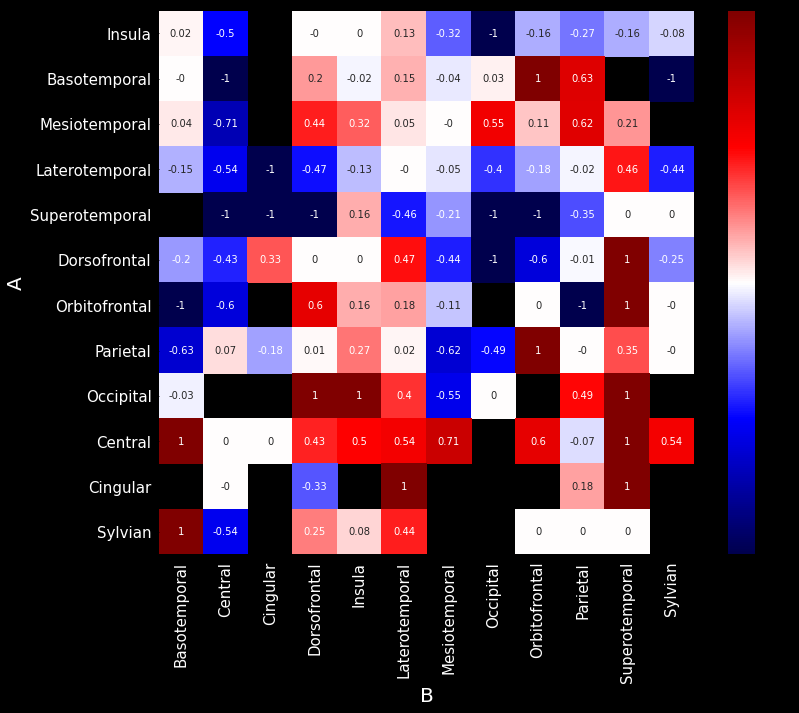

In [668]:
fig, ax = plt.subplots(figsize=(12, 10))# mask
fig.patch.set_facecolor('xkcd:black')
g= sns.heatmap(df_p, annot=True, cmap='seismic', vmin = -1, vmax = 1)
g.set_facecolor('xkcd:black')

plt.ylabel('A', fontsize=20, color="white")
plt.xlabel('B', fontsize=20, color="white")
plt.yticks(fontsize=15, color="white")
plt.xticks(fontsize=15, color="white")
plt.show()

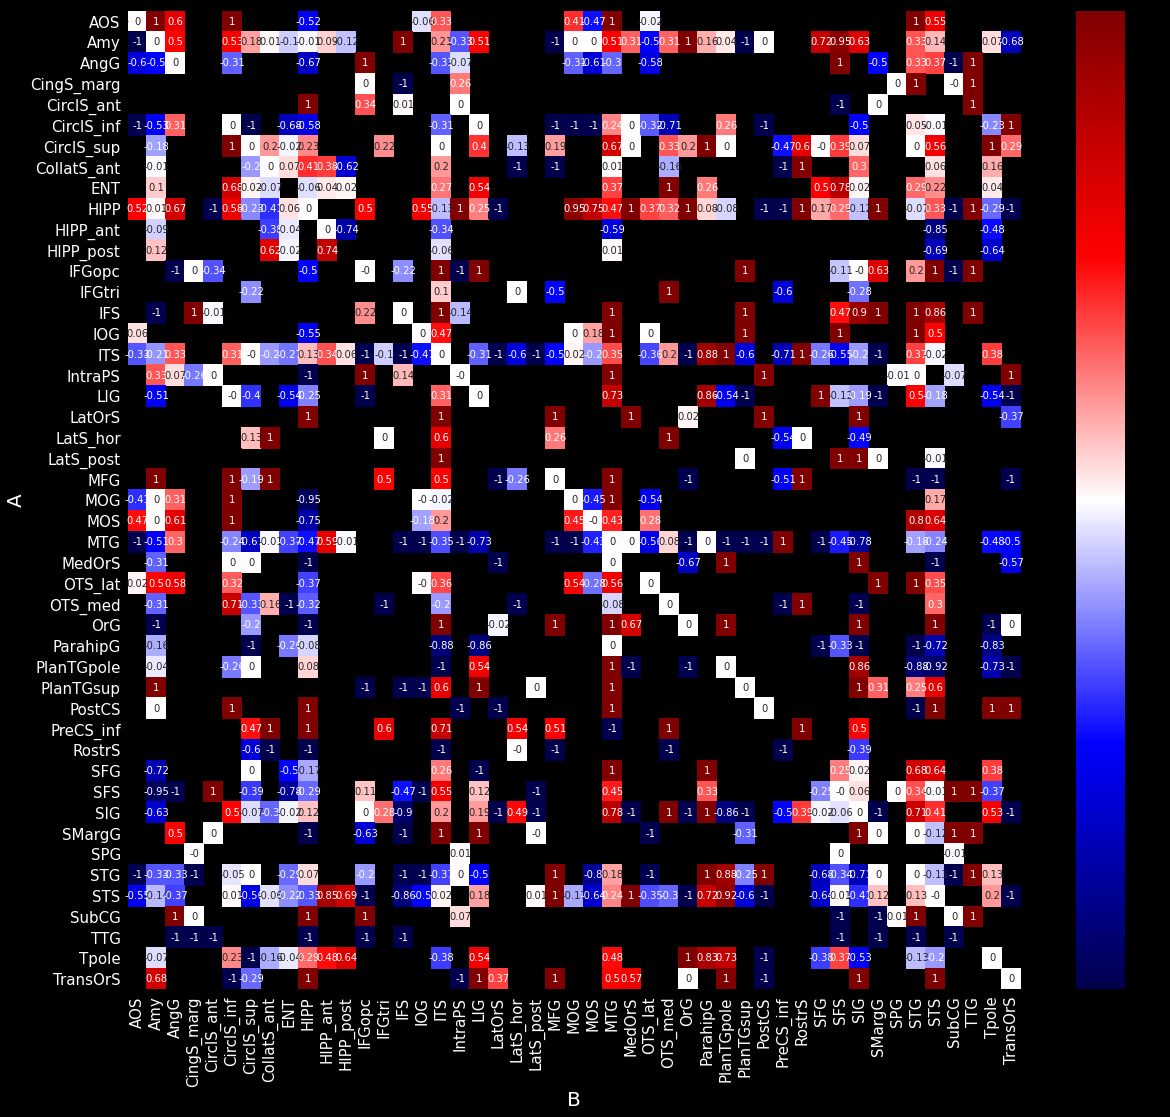

In [651]:
df_A = data_con_sig.groupby(['StimA', 'ChanA'], as_index=False)[['Dir_index']].mean()
df_A['Dir_index'] = np.round(df_A['Dir_index'] ,2)
df_A = df_A.pivot("StimA", "ChanA", "Dir_index")

fig, ax = plt.subplots(figsize=(20, 18))# mask
fig.patch.set_facecolor('xkcd:black')
g= sns.heatmap(df_A, annot=True, cmap='seismic', vmin = -1, vmax = 1)
g.set_facecolor('xkcd:black')

plt.ylabel('A', fontsize=20, color="white")
plt.xlabel('B', fontsize=20, color="white")
plt.yticks(fontsize=15, color="white")
plt.xticks(fontsize=15, color="white")
plt.show()

Text(0.5, 140.09375, 'B')

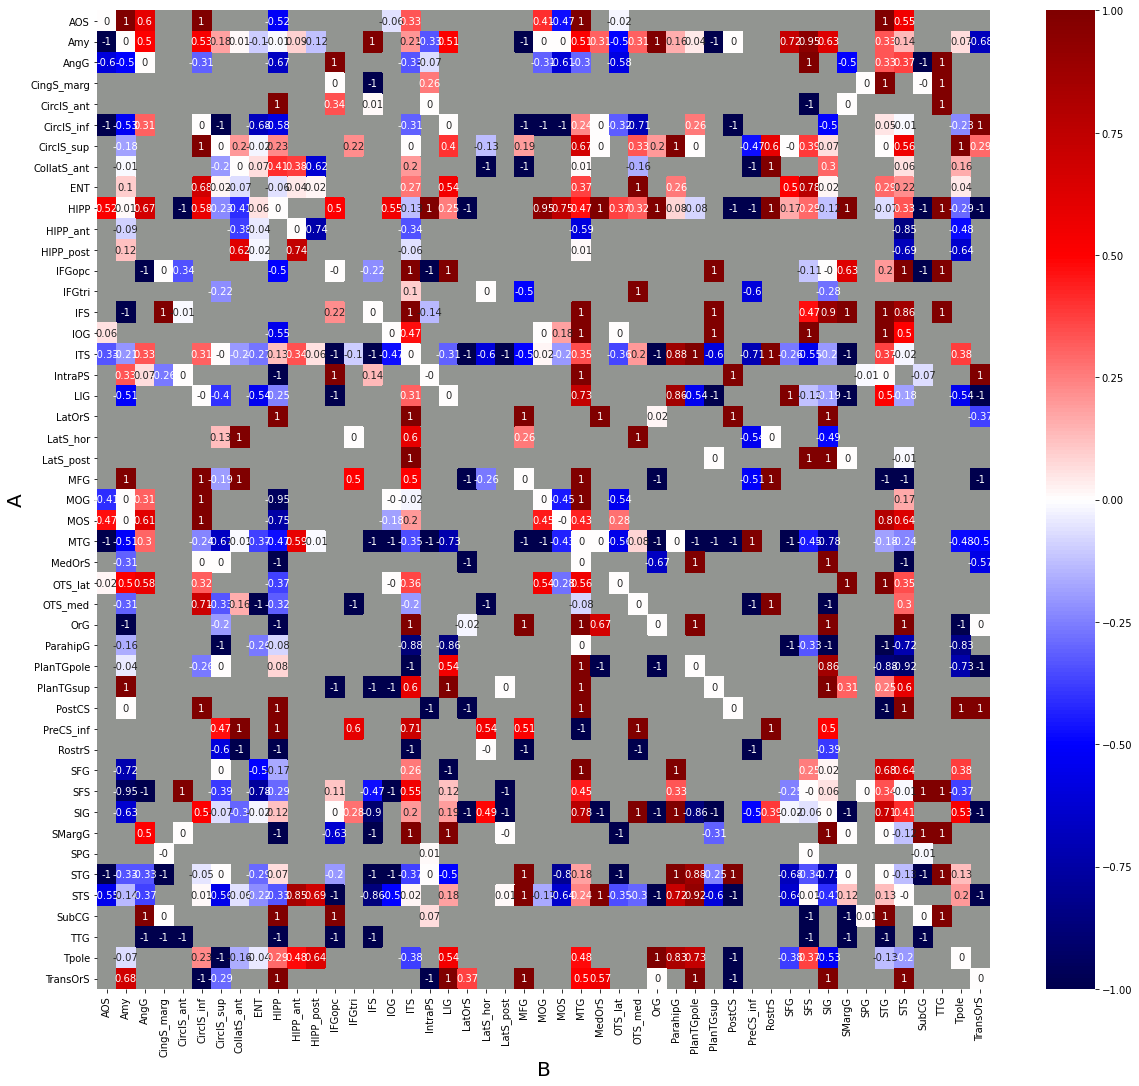

In [635]:


fig, ax = plt.subplots(figsize=(20, 18))# mask
fig.patch.set_facecolor('xkcd:white')
g = sns.heatmap(df_A, annot=True, cmap='seismic', vmin = -1, vmax = 1)
g.set_facecolor('xkcd:grey')
plt.ylabel('A', fontsize=20)
plt.xlabel('B', fontsize=20)


In [605]:
df_2 = data_con.copy()
df_2 = df_2[(~np.isnan(df_2.Dir_index))&(df_2.H==0)]
for i in range(len(subjs)):
    df_2.loc[(df_2.Subj == subjs[i]), 'Stim'] = df_2.loc[(df_2.Subj == subjs[i]), 'Stim']+i*200
    df_2.loc[(df_2.Subj == subjs[i]), 'Chan'] = df_2.loc[(df_2.Subj == subjs[i]), 'Chan']+i*200

In [611]:
n = (np.max(df_2.Stim)+1).astype('int')
M = np.zeros((n,n))-1
M[:,:]  = np.nan
for cc in np.unique(df_2['Stim']).astype('int'):
    chans = df_2.loc[(df_2.Stim ==cc), 'Chan'].values.astype('int')
    vals = df_2.loc[(df_2.Stim == cc), 'Dir_index'].values
    M[cc,chans] = vals
M2= M[~np.isnan(np.nanmean(M,0)),:]
M2= M2[:,~np.isnan(np.nanmean(M2,0))]

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [612]:
labels_regions =[]
labels_areas =[]
for cc in np.unique(df_2['Stim']).astype('int'):
    labels_regions.append(df_2.loc[(df_2.Stim == cc), 'StimR'].values[0])
    labels_areas.append(df_2.loc[(df_2.Stim == cc), 'StimA'].values[0])
    # labels  = df_2.StimR.values
labels_regions = np.array(labels_regions)
labels_areas = np.array(labels_areas)

In [613]:
ind = np.argsort(labels_areas).astype('int')
labels_sel = labels_regions[ind]
areas_sel = labels_areas[ind]
M_sort = M2[ind,:]
M_sort = M_sort[:,ind]

ind = np.argsort(labels_sel).astype('int')
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

M_sort = M_sort[ind,:]
M_sort = M_sort[:,ind]

In [616]:
M_sort.shape

(379, 379)

In [242]:
import copy


In [586]:
regions = pd.read_excel("Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\elab_labels.xlsx",
                        sheet_name='regions',
                        header=0)
color_regions = regions.color.values
regions_order = regions.label

In [ ]:
# Load the brain networks example dataset
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Select a subset of the networks
used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# Draw the full plot
g = sns.clustermap(df.corr(), center=0, cmap="vlag",
                   row_colors=network_colors, col_colors=network_colors,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))

g.ax_row_dendrogram.remove()

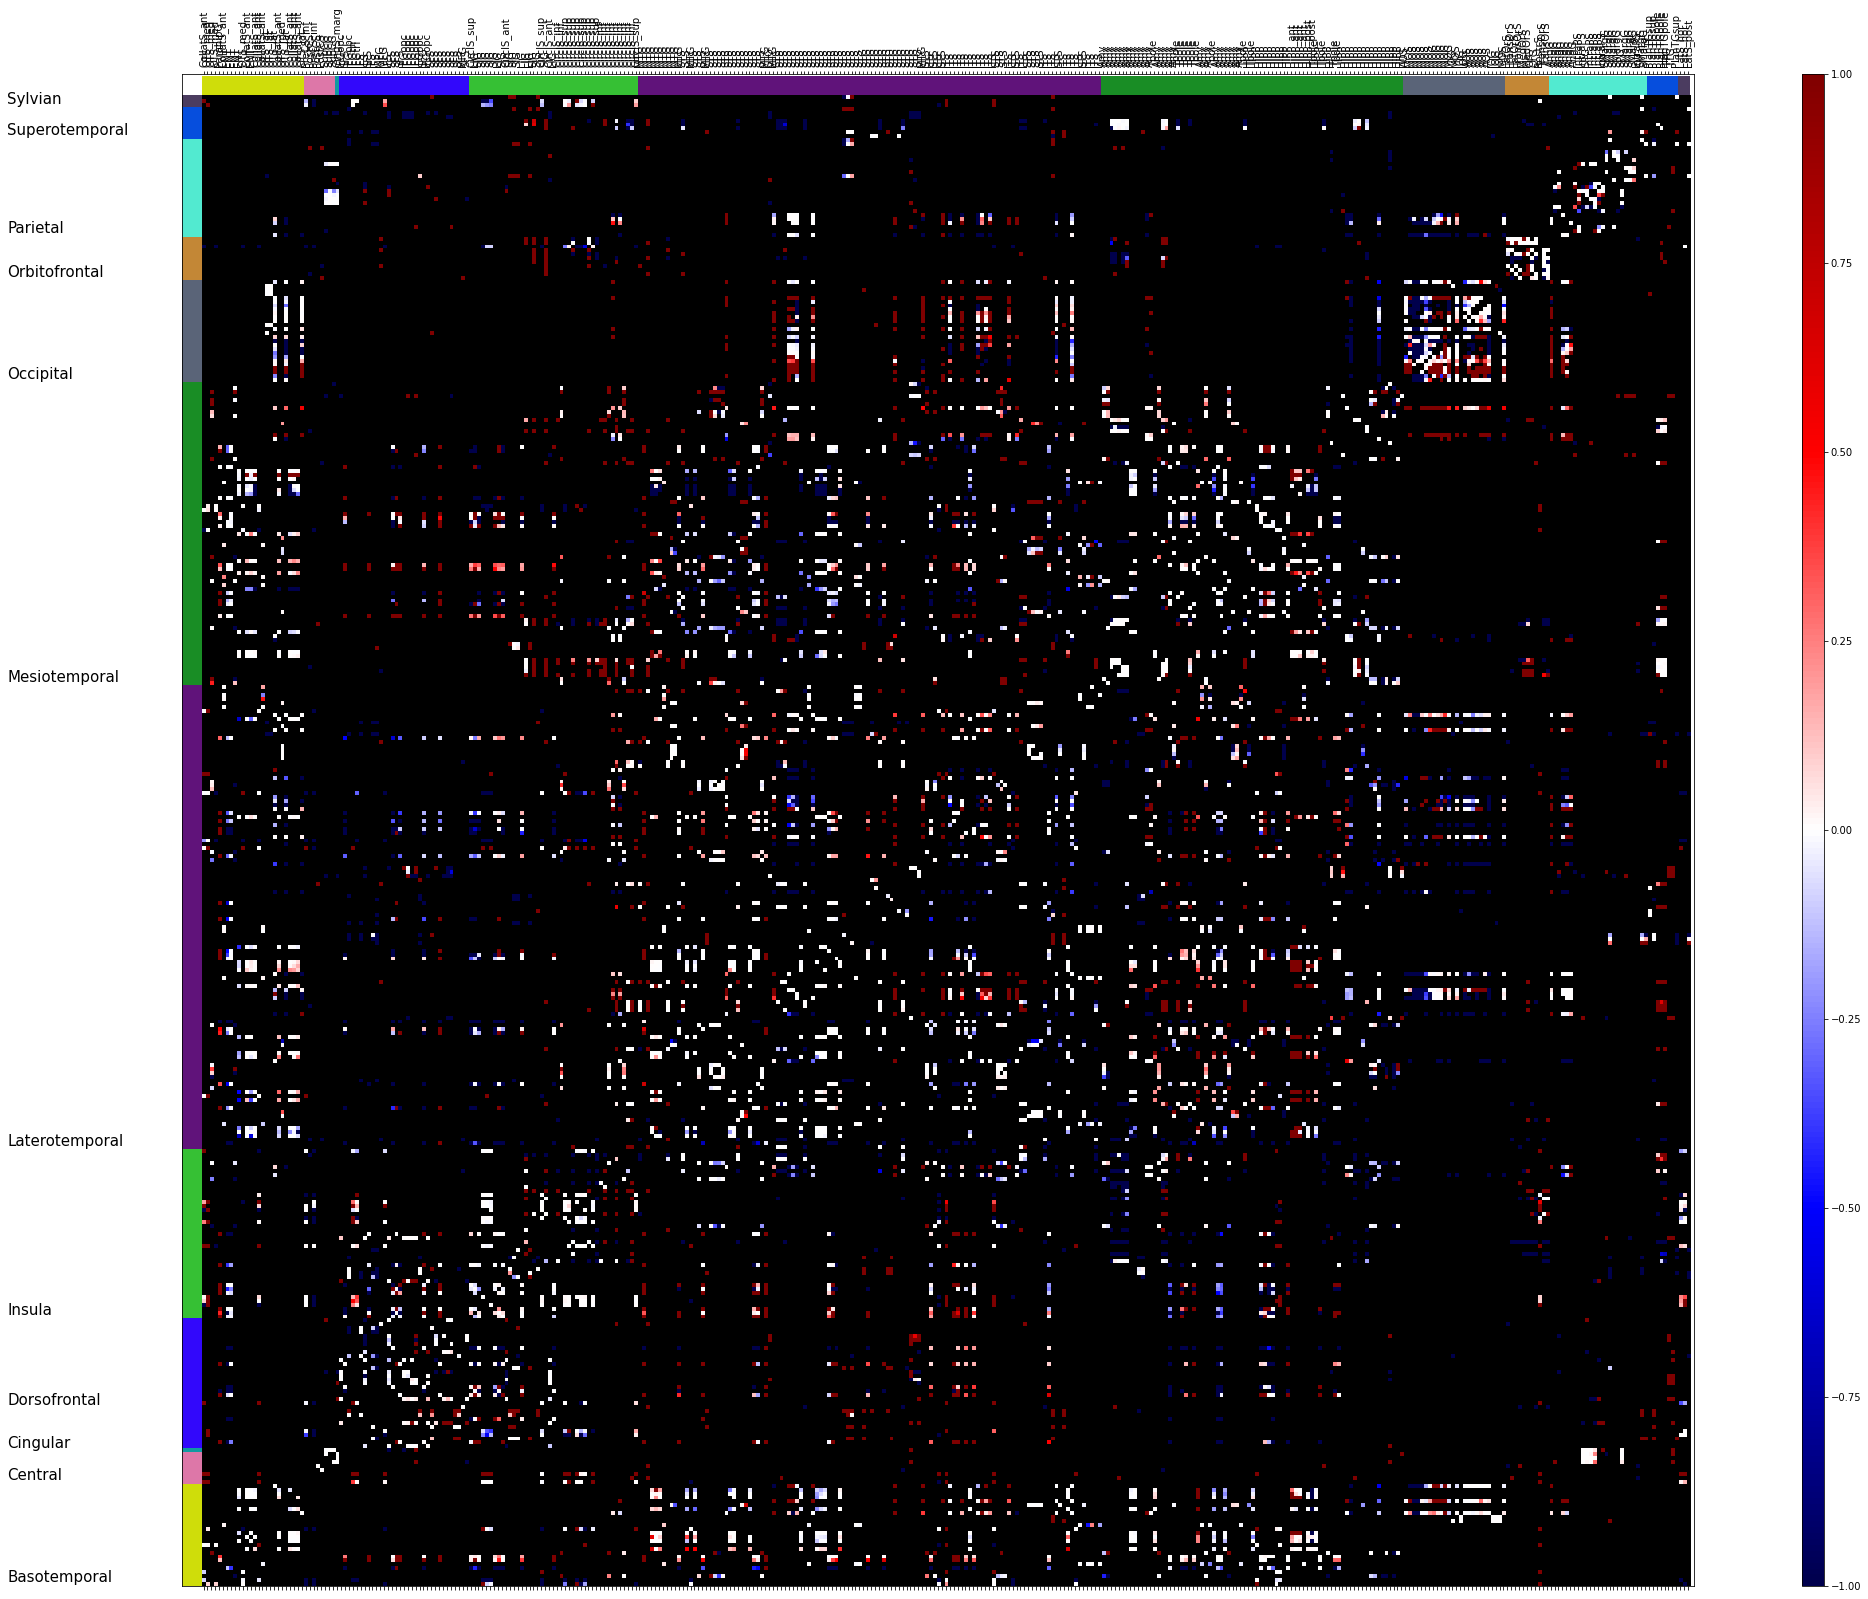

In [614]:
fig = plt.figure(figsize=(30,30))
fig.patch.set_facecolor('xkcd:white')
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
cmap = copy.copy(plt.cm.get_cmap('seismic'))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
# cmap.set_under('#2b2b2b')
cmap.set_bad('black')

im = axmatrix.matshow(M_sort, aspect='auto', origin='lower', cmap=cmap, vmin=-1, vmax=1)
plt.xticks(np.arange(len(labels_regions)),areas_sel.tolist(), rotation=90)
# plt.yticks(np.arange(len(labels_areas)),areas_sel.tolist())
plt.yticks([])
r_pre  = 'start'
y_i = -100
for i in range(len(labels_sel)):
    r = labels_sel[i]
    if r != r_pre:
        if (i-y_i)<3:
            y_i = i +10
        else:
            y_i = i
        plt.text(-50, y_i+0.5, r, fontsize=15)

    axmatrix.add_patch(Rectangle((i - 0.5, len(labels_sel) - 0.5), 1, 5, alpha=1,
                                 facecolor=color_regions[np.where(regions == r)[0][0]]))
    axmatrix.add_patch(
        Rectangle((-5.5, i - 0.5), 5, 1, alpha=1,
                  facecolor=color_regions[np.where(regions == r)[0][0]]))
    r_pre = r
axcolor = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # x, y, x_len, y_len
axmatrix.set_ylim(-0.5, len(M_sort)+5)
axmatrix.set_xlim(-5.5, len(M_sort)+0.5)
plt.colorbar(im, cax=axcolor)            
plt.show()

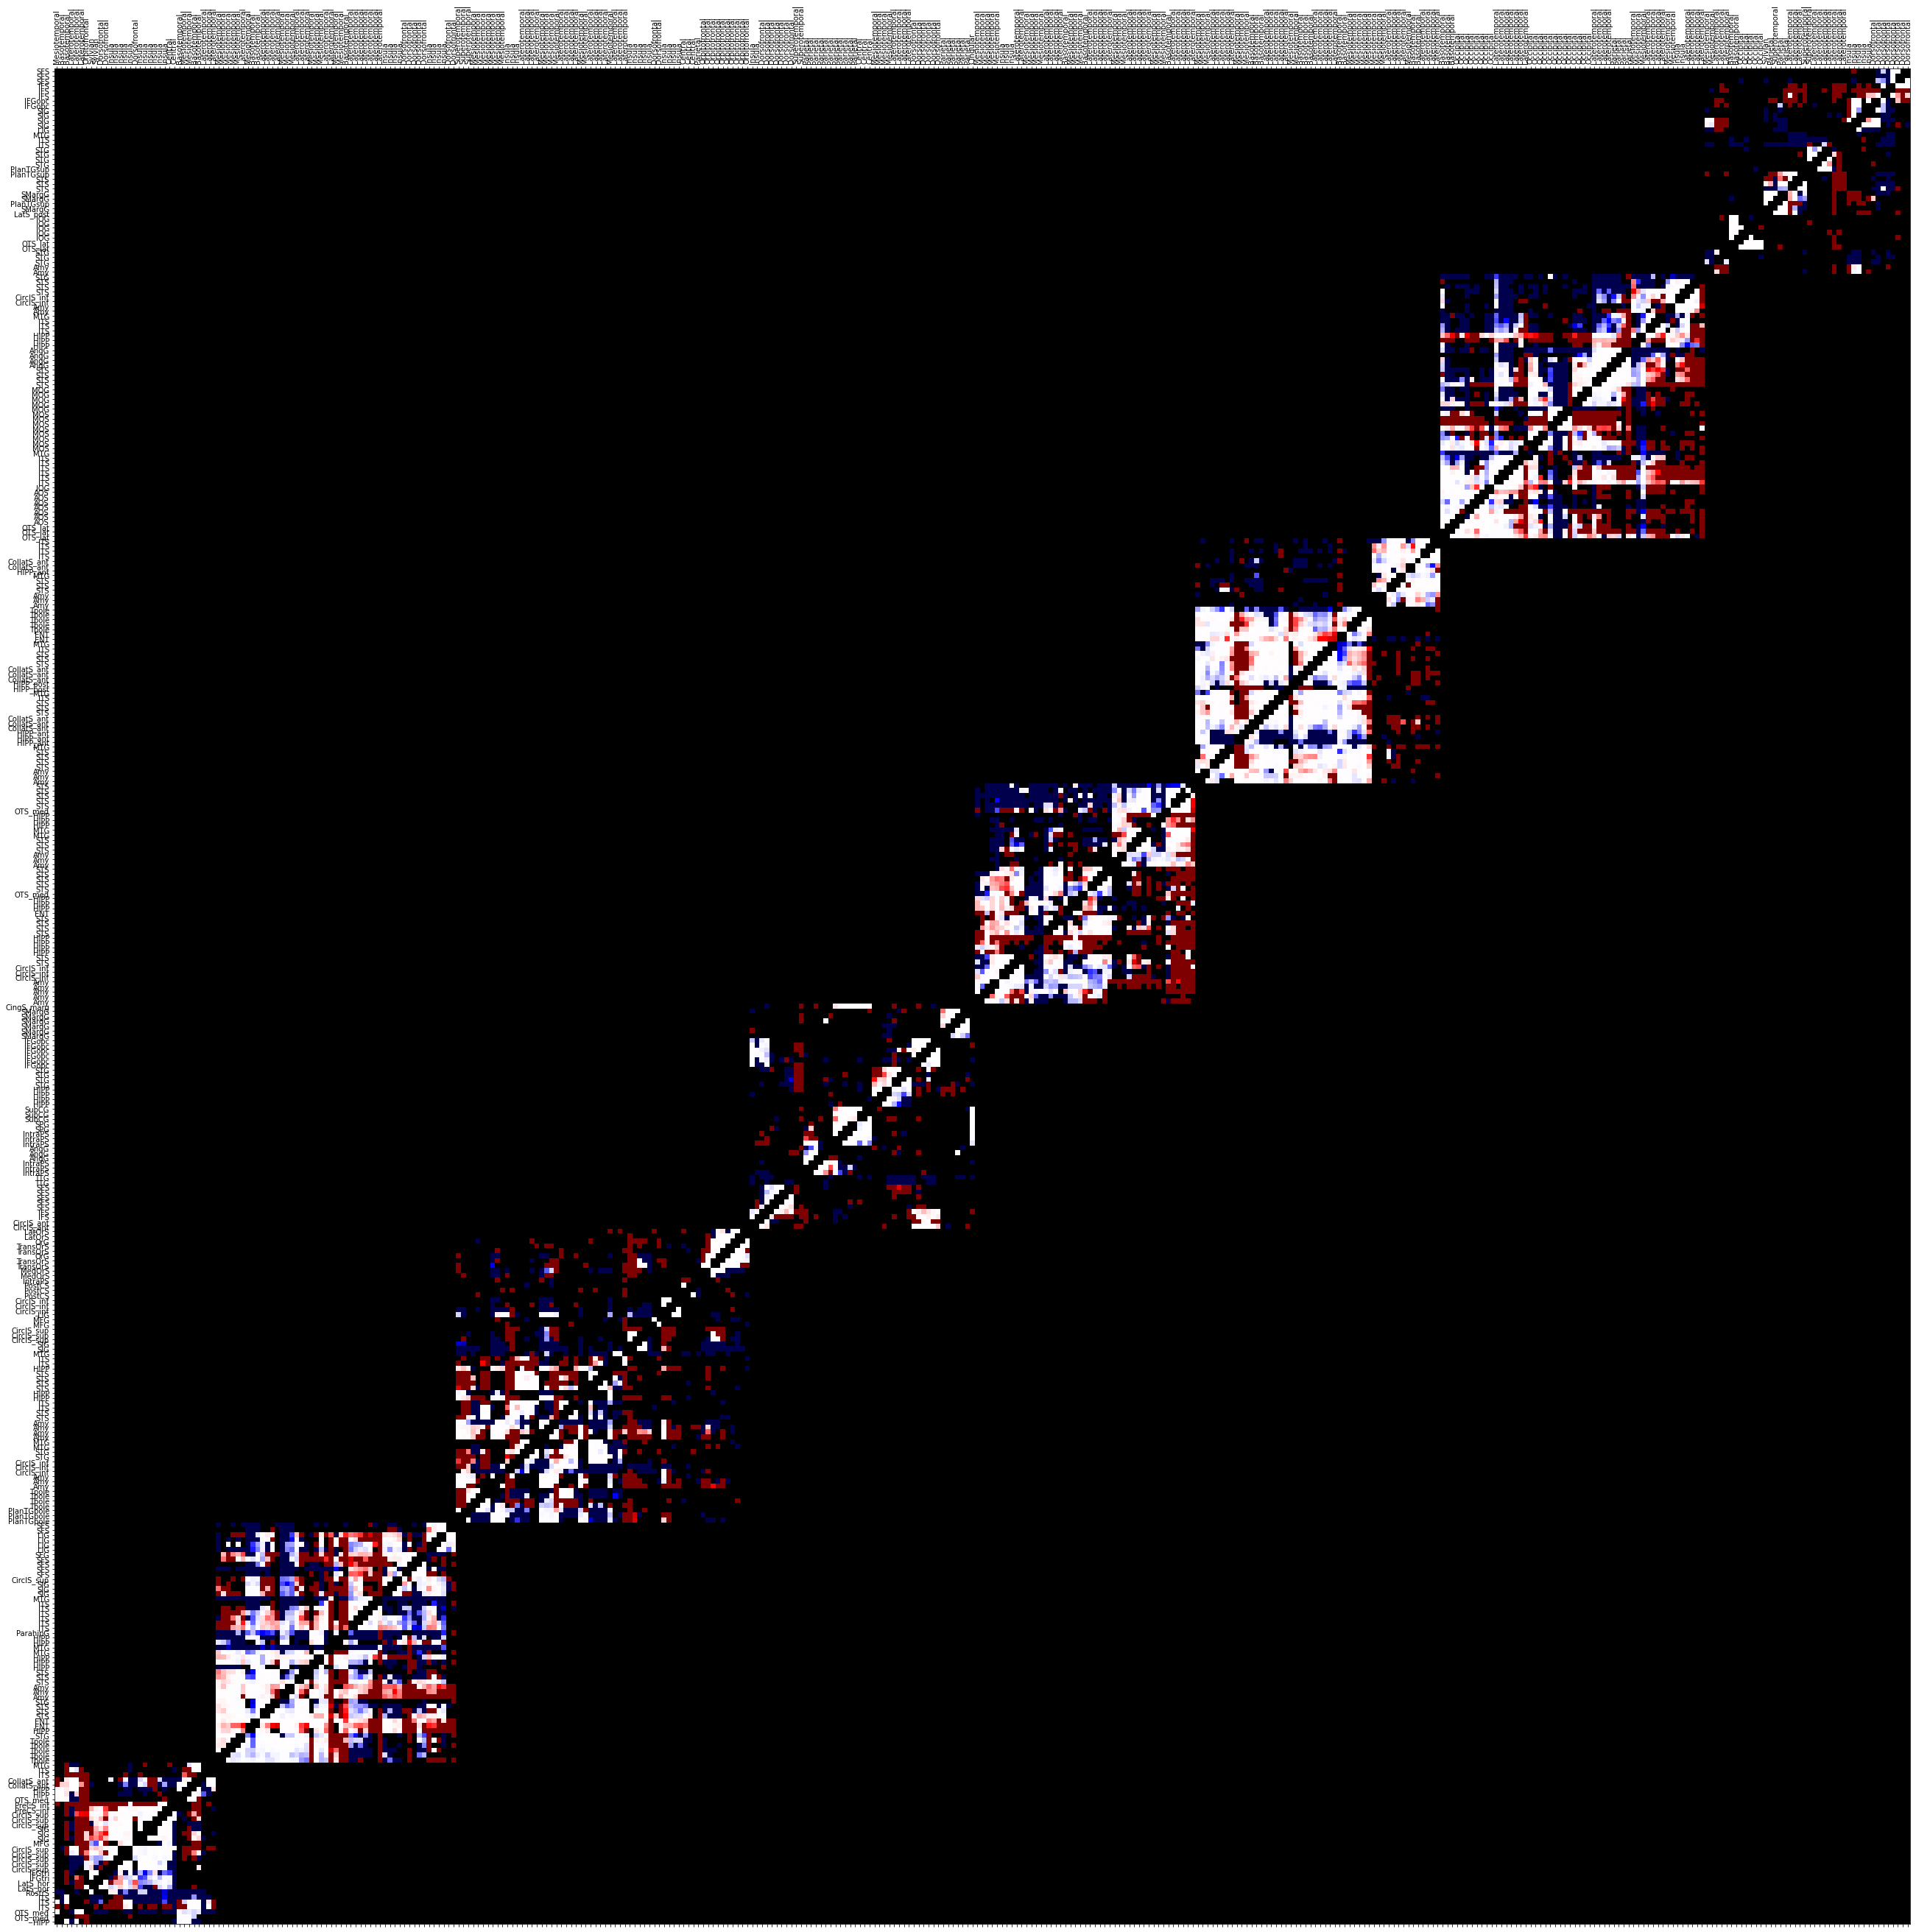

In [554]:
fig = plt.figure(figsize=(50,50))
fig.patch.set_facecolor('xkcd:white')
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
cmap = copy.copy(plt.cm.get_cmap('seismic'))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
# cmap.set_under('#2b2b2b')
cmap.set_bad('black')

im = axmatrix.matshow(M2, aspect='auto', origin='lower', cmap=cmap, vmin=-1, vmax=1)
plt.xticks(np.arange(len(labels_regions)),labels_regions.tolist(), rotation=90)
plt.yticks(np.arange(len(labels_areas)),labels_areas.tolist())
plt.show()

In [60]:
tot = len(data_con[data_con.Subj==subj])
tot_sig = len(data_con[(data_con.Dir_B>0)& (data_con.Subj==subj)])

In [484]:

data_con.loc[(data_con.Dist=='long')]

Subj StimA     ChanA          StimR          ChanR  Stim  Chan  \
4      EL010  HIPP    RostrS  Mesiotemporal  Orbitofrontal   0.0  18.0   
5      EL010  HIPP  LatS_hor  Mesiotemporal        Sylvian   0.0  25.0   
6      EL010  HIPP  LatS_hor  Mesiotemporal        Sylvian   0.0  26.0   
7      EL010  HIPP    IFGtri  Mesiotemporal   Dorsofrontal   0.0  27.0   
8      EL010  HIPP    IFGtri  Mesiotemporal   Dorsofrontal   0.0  28.0   
...      ...   ...       ...            ...            ...   ...   ...   
17481  EL017   SFS       SIG   Dorsofrontal         Insula  59.0  45.0   
17482  EL017   SFS       SIG   Dorsofrontal         Insula  59.0  46.0   
17483  EL017   SFS       SIG   Dorsofrontal         Insula  59.0  47.0   
17484  EL017   SFS    IFGopc   Dorsofrontal   Dorsofrontal  59.0  48.0   
17485  EL017   SFS    IFGopc   Dorsofrontal   Dorsofrontal  59.0  49.0   

            Sig  H    LL_sig  Dir_index  Dir_B  t_resp      d  Dist  
4      0.189655  0  3.041286        1.0    1.0   0.000  70.34  long  
5      0.000000  0       NaN        NaN    0.0   0.008  73.60  long  
6      0.000000  0       NaN        NaN    0.0   0.028  74.71  long  
7      0.000000  0       NaN        NaN    0.0   0.162  75.97  long  
8      0.000000  0       NaN        NaN    0.0   0.004  77.36  long  
...         ... ..       ...        ...    ...     ...    ...   ...  
17481  0.000000  0       NaN        NaN    0.0   0.020  51.53  long  
17482  0.000000  0       NaN        NaN    0.0   0.198  51.39  long  
17483  0.000000  0       NaN        NaN    0.0   0.018  51.50  long  
17484  0.000000  0       NaN        NaN    0.0   0.068  51.84  long  
17485  0.000000  0       NaN       -1.0    0.0   0.052  52.41  long  

[10542 rows x 15 columns]

In [474]:
data_con[(data_con.Dist=='local (<15 mm)')&(data_con.Sig>0)]

Subj     StimA    ChanA           StimR           ChanR  Stim  Chan  \
0      EL010      HIPP  OTS_med   Mesiotemporal    Basotemporal   0.0   2.0   
61     EL010   OTS_med     HIPP    Basotemporal   Mesiotemporal   2.0   0.0   
94     EL010       ITS  OTS_med  Laterotemporal    Basotemporal   6.0   2.0   
95     EL010       ITS      ITS  Laterotemporal  Laterotemporal   6.0   8.0   
221    EL010  LatS_hor   IFGtri         Sylvian    Dorsofrontal  25.0  27.0   
...      ...       ...      ...             ...             ...   ...   ...   
17411  EL017       SFS      IFS    Dorsofrontal    Dorsofrontal  57.0  55.0   
17412  EL017       SFS      SFS    Dorsofrontal    Dorsofrontal  57.0  59.0   
17450  EL017       SFS      IFS    Dorsofrontal    Dorsofrontal  58.0  55.0   
17488  EL017       SFS      IFS    Dorsofrontal    Dorsofrontal  59.0  55.0   
17489  EL017       SFS      SFS    Dorsofrontal    Dorsofrontal  59.0  57.0   

            Sig  H    LL_sig  Dir_index  Dir_B  t_resp     d            Dist  
0      1.000000  0  8.664564   0.000000    2.0     0.0   7.0  local (<15 mm)  
61     1.000000  0  6.358977  -0.000000    2.0     0.0   7.0  local (<15 mm)  
94     1.000000  0  6.355518   1.000000    1.0     0.0  14.0  local (<15 mm)  
95     1.000000  0  9.822530        NaN    1.0     0.0   7.0  local (<15 mm)  
221    1.000000  0  4.809311   0.000000    2.0     0.0   7.0  local (<15 mm)  
...         ... ..       ...        ...    ...     ...   ...             ...  
17411  1.000000  0  7.872570  -0.000000    2.0     0.0   7.0  local (<15 mm)  
17412  0.882353  0  4.993586  -0.013841    2.0     0.0   7.0  local (<15 mm)  
17450  0.980000  0  4.256998  -0.000400    2.0     0.0  10.5  local (<15 mm)  
17488  1.000000  0  4.248322  -0.000000    2.0     0.0  14.0  local (<15 mm)  
17489  1.000000  0  8.450292   0.013841    2.0     0.0   7.0  local (<15 mm)  

[1957 rows x 15 columns]

In [510]:
# data_con.insert(5, 'DI_b', 0)
data_con.loc[data_con.Dir_index>0.5,'DI_b'] = 1
data_con.loc[data_con.Dir_index<0.5,'DI_b'] = -1
data_con.loc[data_con.Dir_index<0.5,'DI_b'] = 0
data_con.loc[np.isnan(data_con.Dir_index),'DI_b'] = np.nan


In [493]:
yy_order = ['local (<15 mm)', 'short (<30mm)', 'long']

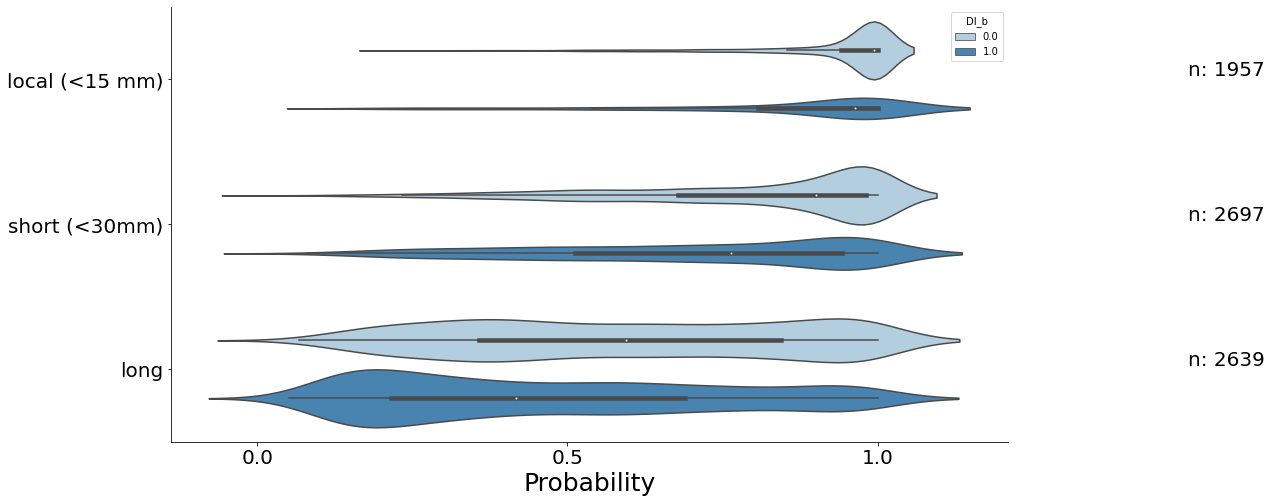

In [512]:
yy = 'Dist'
xx = 'Sig'
xl = 'Probability'
df = data_con[data_con.Sig>0]# [~np.isnan(data_con.Dir_index)]
plt.figure(figsize=(15,8))
ax = sns.violinplot(y=yy, x=df[xx], hue='DI_b', data=df, order= yy_order, palette="Blues")
# medians = df.groupby([yy])[xx].median().values
nobs =df[yy].value_counts()[yy_order].values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(1.5,tick,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks([0, 0.5,1],fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(xl,fontsize=25)
plt.ylabel('',fontsize=1)
sns.despine()
# plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\BrainMapping\General\Violin_'+yy+'_'+xx+'.svg')
plt.show()

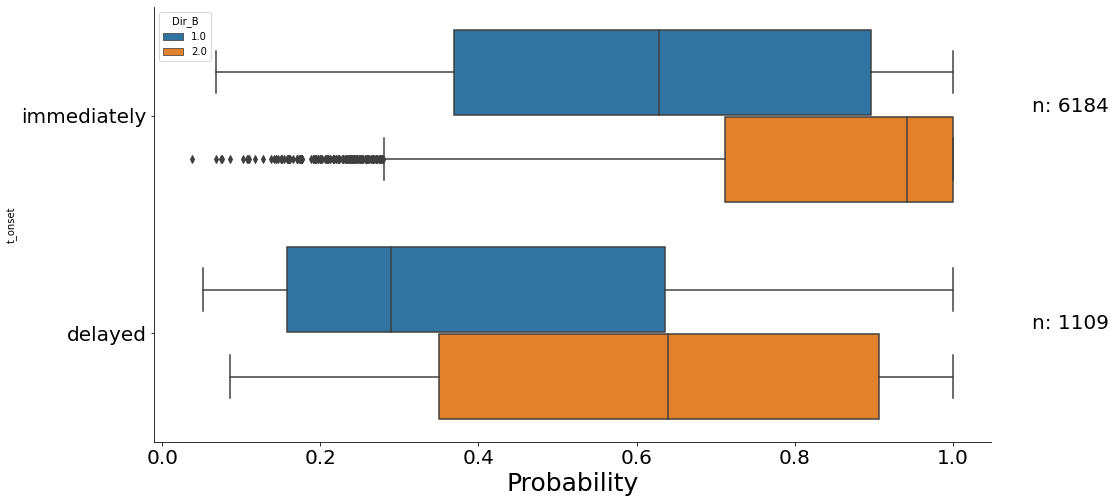

In [154]:
yy = 't_onset'
xx = 'Sig'
df = data_con[(data_con.Sig>0)]
plt.figure(figsize=(15,8))
ax = sns.boxplot(y=yy, x=xx, data=df, hue ='Dir_B', order= ['immediately', 'delayed']) #, hue ='Dir_B'
medians = df.groupby([yy])[xx].median().values
nobs = df[yy].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(1.1,tick,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Probability',fontsize=25)
sns.despine()

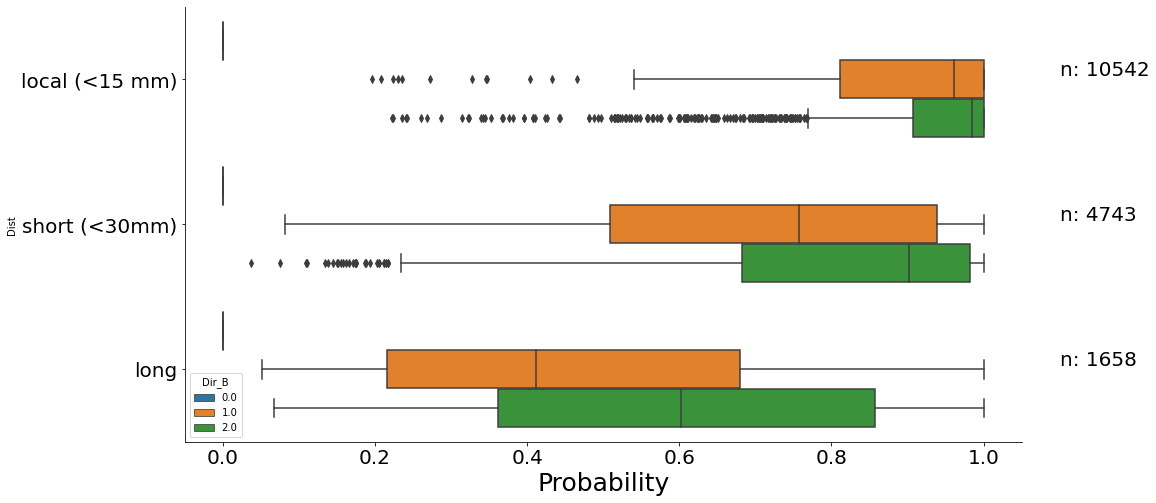

In [108]:
yy = 'Dist'
xx = 'Sig'
df = data_con[data_con.d>=8]
plt.figure(figsize=(15,8))
ax = sns.boxplot(y=yy, x=xx, data=df, hue ='Dir_B', order= ['local (<15 mm)', 'short (<30mm)', 'long'])
medians = df.groupby([yy])[xx].median().values
nobs = df[yy].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs] 
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_yticklabels()):
    ax.text(1.1,tick,nobs[tick],color='black', verticalalignment = "bottom",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Probability',fontsize=25)
sns.despine()

In [150]:
#data_con.insert(5,'t_onset', 'immediately')
data_con.loc[(data_con.t_resp>0.025), 't_onset'] = 'delayed'

(0.0, 0.2)

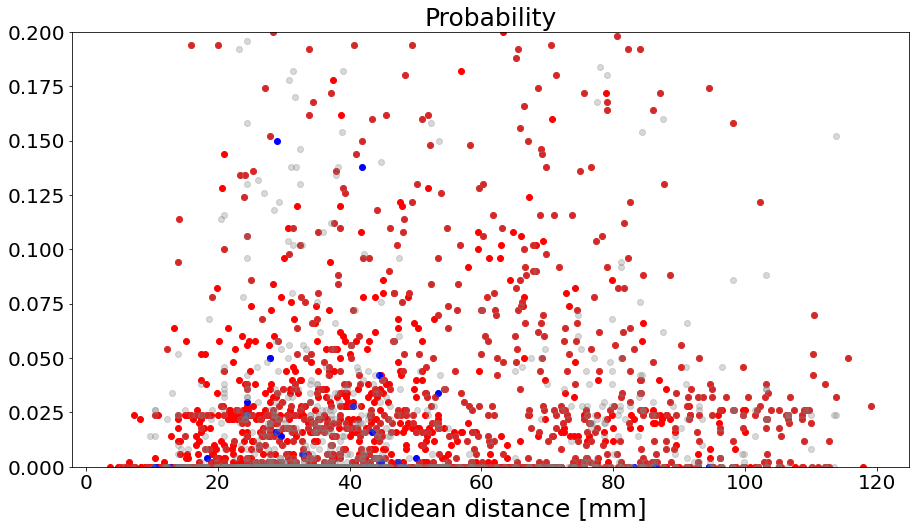

In [141]:
plt.figure(figsize=(15,8))
plt.title('Probability',fontsize=25)
plt.scatter(data_con.loc[(data_con.Dir_index >0.5)& (data_con.Sig >0),'d'],data_con.loc[(data_con.Dir_index >0.5)& (data_con.Sig >0),'t_resp'], color=[1,0,0], alpha = 1)
plt.scatter(data_con.loc[(data_con.Dir_index <-0.5)& (data_con.Sig >0),'d'],data_con.loc[(data_con.Dir_index <-0.5)& (data_con.Sig >0),'t_resp'], color=[0,0,1], alpha = 1)
plt.scatter(data_con.loc[((data_con.Dir_index >-0.5)& (data_con.Sig <0.5))& (data_con.Sig >0),'d'],data_con.loc[((data_con.Dir_index >-0.5)& (data_con.Sig <0.5))& (data_con.Sig >0),'t_resp'], color='grey', alpha=.3)

# sns.scatterplot(x = 'd', y= 't_resp', hue = 'Dir_index',data = data_con[data_con.Sig >0], palette ='seismic')
plt.xlabel('Response Onset [s]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('euclidean distance [mm]',fontsize=25)
plt.ylim([0.,0.2])

(0.0, 0.2)

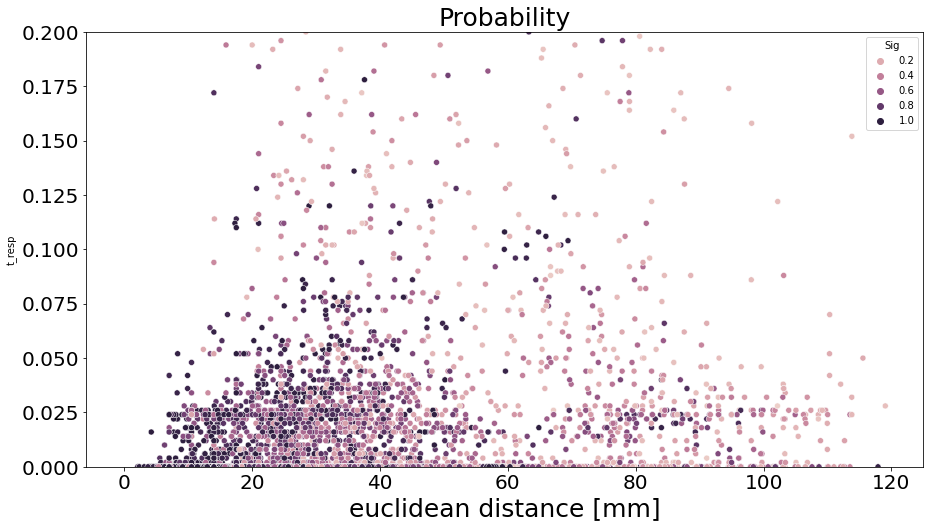

In [121]:
plt.figure(figsize=(15,8))
plt.title('Probability',fontsize=25)
sns.scatterplot(x = 'd', y= 't_resp', hue = 'Sig',data = data_con[data_con.Sig>0])
plt.xlabel('Response Onset [s]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('euclidean distance [mm]',fontsize=25)
plt.ylim([0.,0.2])

(-0.01, 1.1)

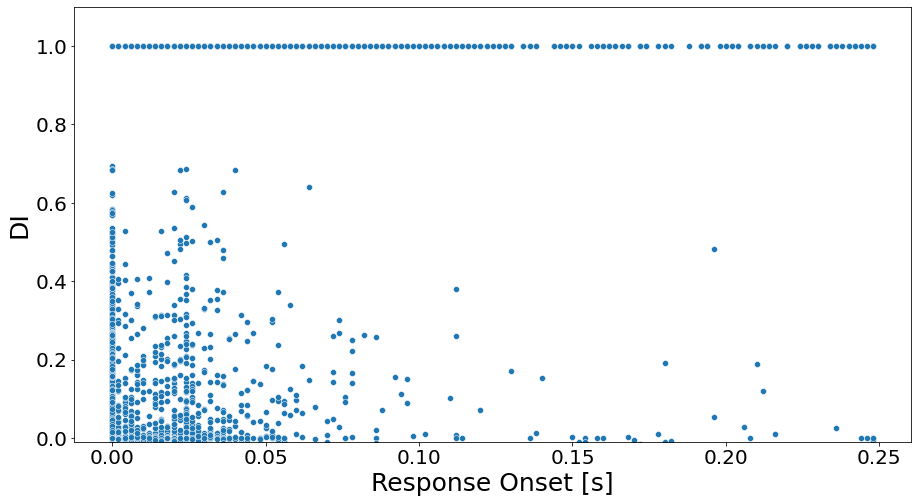

In [105]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = 't_resp', y= 'Dir_index', data = data_con)
plt.xlabel('Response Onset [s]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('DI',fontsize=25)
plt.ylim([-0.01,1.1])

Text(0, 0.5, 'Probability')

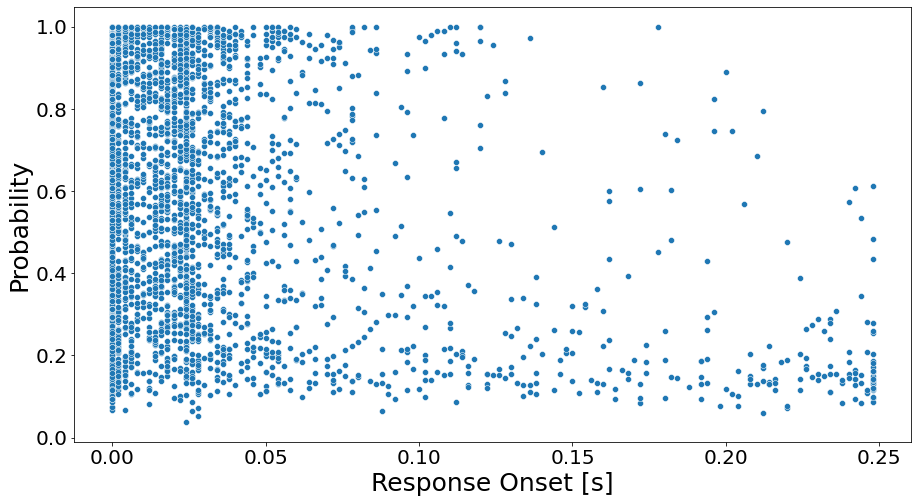

In [100]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = 't_resp', y= 'Sig', data = data_con[(data_con.Sig>0)& (data_con.d>=8)])
plt.xlabel('Response Onset [s]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Probability',fontsize=25)

<AxesSubplot:xlabel='d', ylabel='Sig'>

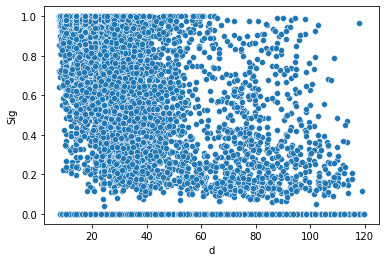

In [68]:
sns.scatterplot(x = 'd', y= 'Sig', data = data_con[data_con.d>=8])

  axIO.set_title('IO curve',fontsize=18)
    axIO.set_ylabel('LL uv/ms [250ms] normalized',fontsize=16)
    axIO.set_xlabel('Intensity [mA]',fontsize=16)

In [13]:
#data_con.insert(7, 'Dist_Group', 0)
for i in range(len(dist_labels)):
    data_con.loc[(data_con.d<dist_groups[i,1])&(data_con.d>=dist_groups[i,0]),'Dist_Group' ] = dist_labels[i]

## Asymmetry fro KS meeting

In [ ]:
file_con_trial        = path_patient + '/Analysis/' + folder + '/'+cond_folder+'/data/con_trial_'+cond_folder+'.csv'
con_trial = pd.read_csv(file_con_trial)

In [8]:
folder = 'BrainMapping'
cond_folder = 'Ph'

In [20]:
k = 1
if platform.system()=='Windows':
    path_patient = 'T:\EL_experiment\Patients\\'+subjs[k]
else: #'Darwin' for MAC
    path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subjs[k]
lbls            = pd.read_excel(path_patient + "/infos/" +subjs[k] + "_labels.xlsx", header=0, sheet_name='BP')
labels_all      = lbls.label.values
file_con_trial        = path_patient + '/Analysis/' + folder + '/'+cond_folder+'/data/con_trial_'+cond_folder+'.csv'

In [22]:
con_trial = pd.read_csv(file_con_trial) 

In [29]:
dat_subj = con_trial[(con_trial.LL>0)&(con_trial.Condition==1)&(con_trial.Sig_block_surr>-1)]

In [30]:
dat_subj.LL_mean = dat_subj.LL_mean*dat_subj.Sig_block_surr
dat_subj = dat_subj.groupby(['Stim', 'Chan'], as_index=False)['LL_mean'].agg(['count','mean']).reset_index()
dat_subj = dat_subj[dat_subj['count']>1]

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
for k in range(len(subjs)):
    if platform.system()=='Windows':
        path_patient = 'T:\EL_experiment\Patients\\'+subjs[k]
    else: #'Darwin' for MAC
        path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subjs[k]
    lbls            = pd.read_excel(path_patient + "/infos/" +subjs[k] + "_labels.xlsx", header=0, sheet_name='BP')
    labels_all      = lbls.label.values
    file_con_trial        = path_patient + '/Analysis/' + folder + '/'+cond_folder+'/data/con_trial_'+cond_folder+'.csv'
    con_trial = pd.read_csv(file_con_trial) 
    dat_subj = con_trial[(con_trial.LL>0)&(con_trial.Condition==1)&(con_trial.Sig_block_surr>-1)]
    dat_subj.LL_mean = dat_subj.LL_mean*dat_subj.Sig_block_surr
    dat_subj = dat_subj.groupby(['Stim', 'Chan'], as_index=False)['LL_mean'].agg(['count','mean']).reset_index()
    dat_subj = dat_subj[dat_subj['count']>2]

    A  = np.zeros((1,7))
    chans = np.unique([dat_subj.Stim, dat_subj.Chan]).astype('int')
    for i in range(len(chans)):
        for j in range(i+1, len(chans)):
            if (len(dat_subj[(dat_subj.Chan==chans[i])&(dat_subj.Stim==chans[j])])>0)&len(dat_subj[(dat_subj.Chan==chans[j])&(dat_subj.Stim==chans[i])])>0:
                LLA = dat_subj.loc[(dat_subj.Stim==chans[i])&(dat_subj.Chan==chans[j]), 'mean'].values[0]
                LLB = dat_subj.loc[(dat_subj.Stim==chans[j])&(dat_subj.Chan==chans[i]), 'mean'].values[0]
                d = con_trial.loc[(con_trial.Chan==chans[i])&(con_trial.Stim==chans[j]), 'd'].values[0]
                aa = np.zeros((1,7))
                r = np.min([LLA/LLB, LLB/LLA])
                con = 0
                if LLA>0:
                    con = con +1
                if LLB>0:
                    con = con +1
                aa[0,:] =[chans[i], chans[j], LLA, LLB,r,d, con]
                A = np.concatenate([A,aa])
    A = pd.DataFrame(A, columns=['A', 'B', 'LL_B', 'LL_A', 'Ratio', 'd', 'Conncetion'])
    A.insert(0,'Subj', subjs[k])   
    if k ==0:
        pd_asym = A
    else:
        pd_asym = pd.concat([pd_asym,A])

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [44]:
pd_asym = pd_asym[pd_asym.d>0]

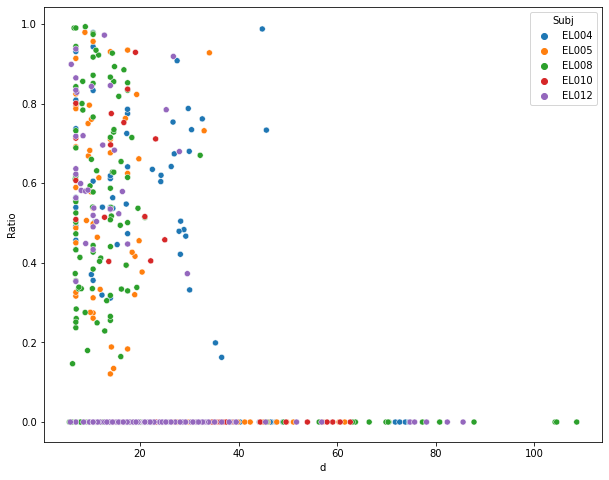

In [45]:
plt.figure(figsize=(10,8))
sns.scatterplot(x= 'd', y='Ratio', sizes=200, hue='Subj',data= pd_asym[pd_asym.Conncetion>0])
plt.savefig('T:\EL_experiment\Patients\\all\\Analysis\BrainMapping\\Across_BM_Asymm.jpg')

In [46]:
for s in subjs:
    print(s)
    print(len(pd_asym[(pd_asym.Subj==s)&(pd_asym.Conncetion==0)]))
    print(len(pd_asym[(pd_asym.Subj==s)&(pd_asym.Conncetion==1)]))
    print(len(pd_asym[(pd_asym.Subj==s)&(pd_asym.Conncetion==2)]))
    print(len(pd_asym[(pd_asym.Subj==s)]))

EL004
291
98
52
441
EL005
394
127
48
569
EL008
286
64
87
437
EL010
104
47
15
166
EL012
470
85
35
590


## Asymmety

In [14]:
data_con

Subj           StimR         ChanR  Chan  Stim  Int         LL      d  \
0     EL003        Parietal  Basotemporal   0.0  43.0  2.0   0.876569  67.35   
1     EL003        Parietal  Basotemporal   0.0  33.0  2.0   0.672368  64.10   
2     EL003    Basotemporal  Basotemporal   0.0   2.0  2.0  18.490428   7.00   
3     EL003        Parietal  Basotemporal   0.0  33.0  2.0   0.825521  64.10   
4     EL003  Laterotemporal  Basotemporal   0.0  51.0  2.0   1.280801  35.63   
...     ...             ...           ...   ...   ...  ...        ...    ...   
7679  EL011   Mesiotemporal  Dorsofrontal  86.0   2.0  3.0   1.482184  85.76   
7680  EL011          Insula  Dorsofrontal  86.0  54.0  3.0   2.680035  65.96   
7681  EL011    Dorsofrontal  Dorsofrontal  86.0  86.0  3.0        NaN   0.00   
7682  EL011    Basotemporal  Dorsofrontal  86.0   9.0  3.0   3.018207  77.48   
7683  EL011    Dorsofrontal  Dorsofrontal  86.0  65.0  3.0   1.834165  67.19   

      sig_trial   tN2  ...        sN1        pN2          pN1        zLL  \
0             0   NaN  ...        NaN        NaN          NaN  -0.145110   
1             0   NaN  ...        NaN        NaN          NaN  -0.936378   
2             1  0.09  ...  84.752113  21.400567  1061.912631  68.107774   
3             0   NaN  ...        NaN        NaN          NaN  -0.342918   
4             0   NaN  ...        NaN        NaN          NaN   1.421268   
...         ...   ...  ...        ...        ...          ...        ...   
7679          0   NaN  ...        NaN        NaN          NaN  -1.344863   
7680          0   NaN  ...        NaN        NaN          NaN   0.897641   
7681          0   NaN  ...        NaN        NaN          NaN        NaN   
7682          0   NaN  ...        NaN        NaN          NaN   1.530735   
7683          0   NaN  ...        NaN        NaN          NaN  -0.685917   

      Condition  Hour    Num  RespC     LLpeak      Dist_Group  
0           0.0  14.0    2.0    0.0   0.609050            long  
1           0.0  14.0    3.0    0.0   0.599403            long  
2           0.0  14.0    4.0    1.0  12.918789  local (<15 mm)  
3           0.0  14.0    5.0    0.0   0.599403            long  
4           0.0  14.0    8.0    1.0   1.994546            long  
...         ...   ...    ...    ...        ...             ...  
7679        0.0  15.0  145.0    0.0   1.863501            long  
7680        0.0  15.0  146.0    0.0   1.746540            long  
7681        0.0  15.0  147.0   -1.0  -1.000000  local (<15 mm)  
7682        0.0  15.0  148.0    1.0   2.623197            long  
7683        0.0  15.0  149.0    0.0   1.091408            long  

[38161 rows x 22 columns]

In [10]:
dat_subj = data_con[data_con.Subj =='EL003']

In [52]:
dat_subj.RespC

0       0.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
4896    1.0
4897    1.0
4898    1.0
4899    0.0
4900    0.0
Name: RespC, Length: 4901, dtype: float64

In [19]:
len(dat_subj[(dat_subj.Chan==chans[j])&(dat_subj.Stim==chans[i])])

0

In [97]:
dat_subj[(dat_subj.Chan==chans[0])&(dat_subj.Stim==chans[j])]

Subj         StimR          ChanR  Chan  Stim  Int        LL      d  \
113  EL011  Dorsofrontal  Mesiotemporal   0.0  86.0  3.0  1.548848  84.55   
122  EL011  Dorsofrontal  Mesiotemporal   0.0  86.0  3.0  2.513217  84.55   
141  EL011  Dorsofrontal  Mesiotemporal   0.0  86.0  3.0  1.139839  84.55   

     sig_trial  tN2  ...  sN1  pN2  pN1       zLL  Condition  Hour    Num  \
113          0  NaN  ...  NaN  NaN  NaN  0.147380        0.0  15.0  119.0   
122          0  NaN  ...  NaN  NaN  NaN  1.208325        0.0  15.0  128.0   
141          0  NaN  ...  NaN  NaN  NaN -0.302589        0.0  15.0  147.0   

     RespC    LLpeak  Dist_Group  
113    0.0  1.280069        long  
122    0.0  1.280069        long  
141    0.0  1.280069        long  

[3 rows x 22 columns]

In [ ]:
for k in range(len(subjs)):
    if platform.system()=='Windows':
        path_patient = 'T:\EL_experiment\Patients\\'+subjs[k]
    else: #'Darwin' for MAC
        path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subjs[k]
    lbls            = pd.read_excel(path_patient + "/infos/" +subjs[k] + "_labels.xlsx", header=0, sheet_name='BP')
    labels_all      = lbls.label.values

    dat_subj = con_trial[(con_trial.LL>0)&(con_trial.Condition==1)&(con_trial.Sig_block_surr>-1)]
    dat_subj.LL_mean = dat_subj.LL_mean*dat_subj.Sig_block_surr
    dat_subj = dat_subj.groupby(['Stim', 'Chan'], as_index=False)['LL_mean'].agg(['count','mean']).reset_index()
    dat_subj = dat_subj[dat_subj['count']==3]

    A  = np.zeros((1,7))
    chans = np.unique([dat_subj.Stim, dat_subj.Chan]).astype('int')
    for i in range(len(chans)):
        for j in range(i+1, len(chans)):
            if (len(dat_subj[(dat_subj.Chan==chans[i])&(dat_subj.Stim==chans[j])])>0)&len(dat_subj[(dat_subj.Chan==chans[j])&(dat_subj.Stim==chans[i])])>0:
                LLA = dat_subj.loc[(dat_subj.Stim==chans[i])&(dat_subj.Chan==chans[j]), 'mean'].values[0]
                LLB = dat_subj.loc[(dat_subj.Stim==chans[j])&(dat_subj.Chan==chans[i]), 'mean'].values[0]
                d = con_trial.loc[(con_trial.Chan==chans[i])&(con_trial.Stim==chans[j]), 'd'].values[0]
                aa = np.zeros((1,7))
                r = np.min([LLA/LLB, LLB/LLA])
                con = 0
                if LLA>0:
                    con = con +1
                if LLB>0:
                    con = con +1
                aa[0,:] =[chans[i], chans[j], LLA, LLB,r,d, con]
                A = np.concatenate([A,aa])
    A = pd.DataFrame(A, columns=['A', 'B', 'LL_B', 'LL_A', 'Ratio', 'd', 'Conncetion'])
    A.insert(0,'Subj', subjs[k])   
    if k ==0:
        pd_asym = A
    else:
        pd_asym = pd.concat([pd_asym,A])

In [105]:
for k in range(len(subjs)):
    if platform.system()=='Windows':
        path_patient = 'T:\EL_experiment\Patients\\'+subjs[k]
    else: #'Darwin' for MAC
        path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subjs[k]
    lbls            = pd.read_excel(path_patient + "/infos/" +subjs[k] + "_labels.xlsx", header=0, sheet_name='BP')
    labels_all      = lbls.label.values
    dat_subj = data_con[data_con.Subj==subjs[k]]
    A  = np.zeros((1,6))
    chans = np.unique([dat_subj.Stim, dat_subj.Chan]).astype('int')
    for i in range(len(chans)):
        for j in range(i+1, len(chans)):
            if (len(dat_subj[(dat_subj.Chan==chans[i])&(dat_subj.Stim==chans[j])])>0)&len(dat_subj[(dat_subj.Chan==chans[j])&(dat_subj.Stim==chans[i])])>0:
                resp1 = dat_subj.loc[(dat_subj.Chan==chans[j])&(dat_subj.Stim==chans[i]), 'LLpeak'].values[0]
                resp2 = dat_subj.loc[(dat_subj.Chan==chans[i])&(dat_subj.Stim==chans[j]), 'LLpeak'].values[0]
                d = dat_subj.loc[(dat_subj.Chan==chans[i])&(dat_subj.Stim==chans[j]), 'd'].values[0]
                if (resp1>-1) & (resp2>-1):
                    sig = dat_subj.loc[(dat_subj.Chan==chans[j])&(dat_subj.Stim==chans[i]), 'RespC'].values[0]
                    resp1 = resp1*sig
                    sig = dat_subj.loc[(dat_subj.Chan==chans[i])&(dat_subj.Stim==chans[j]), 'RespC'].values[0]
                    resp2 = resp2*sig
                    if ((resp1+resp2)>0):
                        aa = np.zeros((1,6))
                        aa[0,0:2] =[chans[i], chans[j]]
                        r = np.min([resp1/resp2, resp2/resp1])
                        aa[0,:] =[chans[i], chans[j], resp1, resp2,r,d]
                        A = np.concatenate([A,aa])
    A = pd.DataFrame(A, columns=['A', 'B', 'LL_B', 'LL_A', 'Ratio', 'd'])
    A.insert(0,'Subj', subjs[k])    
    if k ==0:
        pd_asym = A
    else:
        pd_asym = pd.concat([pd_asym,A])

In [106]:
pd_asym

Subj     A     B      LL_B       LL_A     Ratio     d
0    EL003   0.0   0.0  0.000000   0.000000  0.000000   0.0
1    EL003   0.0   2.0  7.071943  12.918789  0.547415   7.0
2    EL003   0.0   3.0  5.030759   7.185252  0.700151  10.5
3    EL003   0.0   4.0  0.000000   5.219725  0.000000  14.0
4    EL003   0.0   5.0  1.231940   0.000000  0.000000  17.5
..     ...   ...   ...       ...        ...       ...   ...
436  EL011  73.0  85.0  0.000000   2.043120  0.000000  42.0
437  EL011  74.0  76.0  8.060225   4.033713  0.500447   7.0
438  EL011  74.0  85.0  0.000000   1.914910  0.000000  38.5
439  EL011  76.0  85.0  3.741841   4.379526  0.854394  31.5
440  EL011  76.0  86.0  6.028806   2.467391  0.409267  35.0

[1946 rows x 7 columns]

In [129]:
len(pd_asym)

1765

In [136]:
len(pd_asym[(pd_asym.Ratio>0)&(pd_asym.Ratio<0.8)])/len(pd_asym[(pd_asym.Ratio>0)])

0.7512953367875648

In [134]:
(len(pd_asym[(pd_asym.Ratio>0)&(pd_asym.Ratio<0.8)])/len(pd_asym))

0.24645892351274787

In [ ]:
len(pd_asym[pd_asym.Ratio>0])

In [90]:
len(pd_asym[pd_asym.Ratio>0.8])

173

In [116]:
pd_asym = pd_asym[pd_asym.d>8]

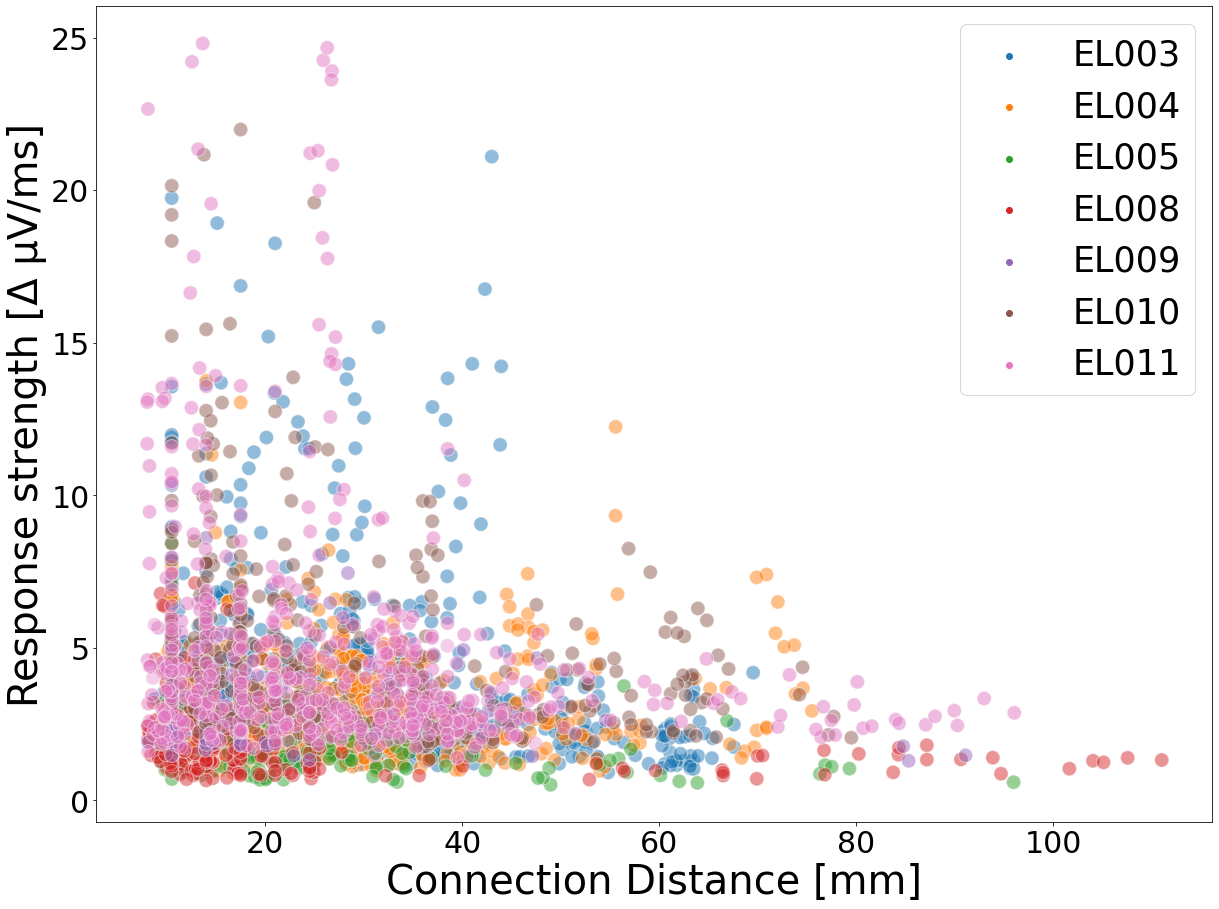

In [127]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='d', y='LLpeak', hue= 'Subj', data=data_con[(data_con.RespC==1)&(data_con.LLpeak>0.1)&(data_con.d>8)],alpha=0.2,  s=200)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Response strength [\u0394 \u03BCV/ms]', fontsize=40)
plt.xlabel('Connection Distance [mm]', fontsize=40)
plt.legend(fontsize=35)
#plt.xlim([9,120])
plt.savefig('T:\\EL_experiment\Patients\\all\Analysis\CCEP\\BM_dist.svg')
plt.savefig('T:\\EL_experiment\Patients\\all\Analysis\CCEP\\BM_dist.jpg')
plt.show()

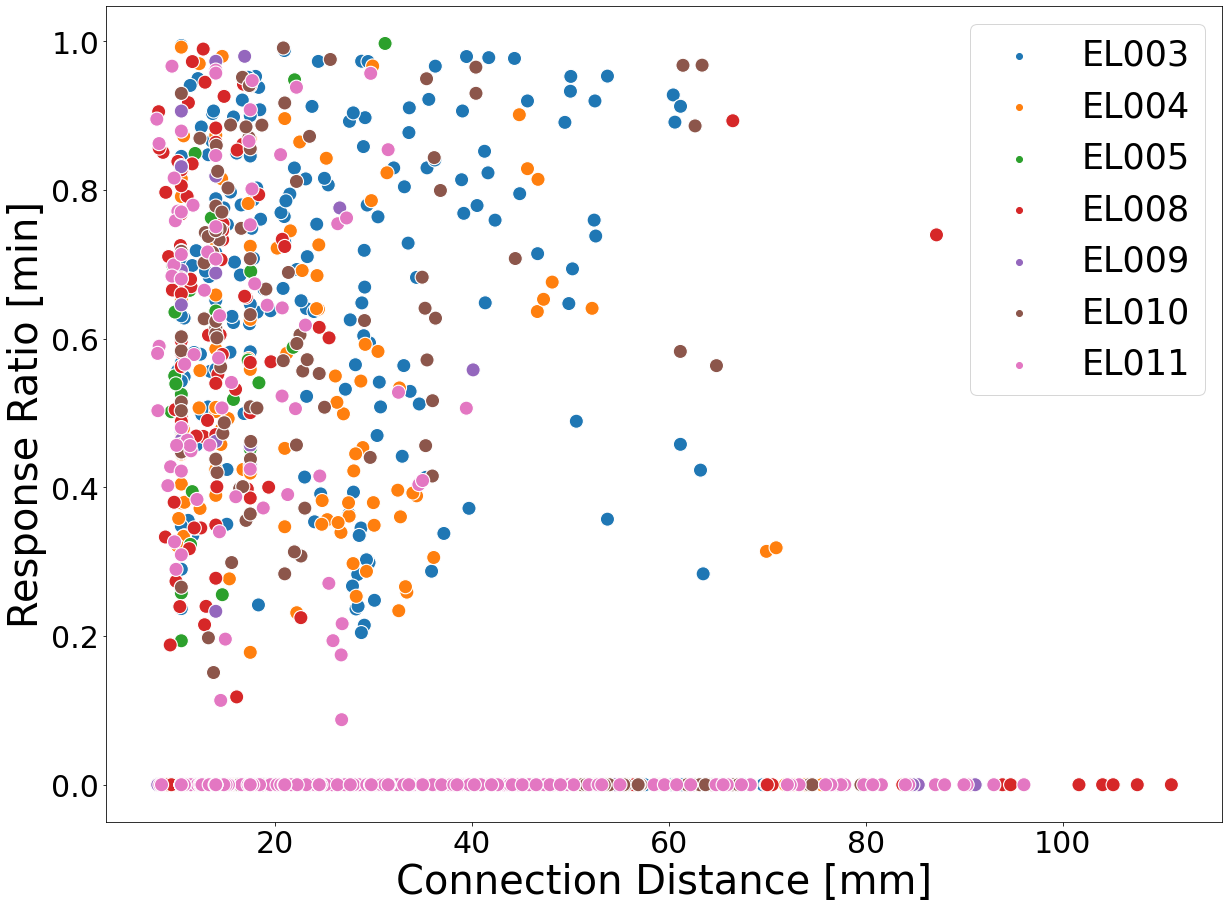

In [120]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='d', y='Ratio', hue= 'Subj', data=pd_asym, s=200)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Response Ratio [min]', fontsize=40)
plt.xlabel('Connection Distance [mm]', fontsize=40)
plt.legend(fontsize=35)
#plt.xlim([9,120])
plt.savefig('T:\\EL_experiment\Patients\\all\Analysis\CCEP\\BM_ratio.svg')
plt.savefig('T:\\EL_experiment\Patients\\all\Analysis\CCEP\\BM_ratio.jpg')
plt.show()

## P2P

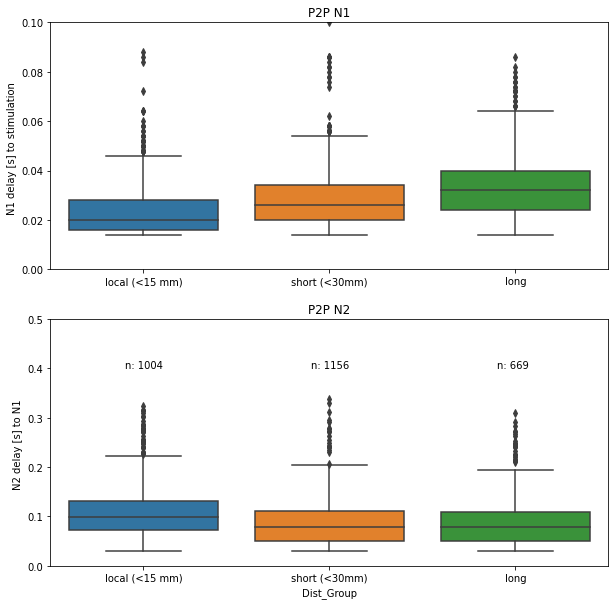

In [121]:
dat_plot   = data_con[(data_con.tN2N1>0.02)&(data_con.tN1>0.01)&(data_con.d>7)&(data_con.pN2<2000)&(data_con.pN1<3000)]
dist_n = np.zeros((3,))
for i in range(len(dist_n)):
    dist_n[i] = len(dat_plot[dat_plot.Dist_Group==dist_labels[i]])
fig = plt.figure(figsize=(10,10))
gs         = fig.add_gridspec(2,1) #, width_ratios=[5,3]
#plt.suptitle(subj)
ax = fig.add_subplot(gs[0,0])
plt.ylim([0,0.1])
plt.title('P2P N1')
sns.boxplot(x='Dist_Group', y= 'tN1', data = dat_plot)
plt.ylabel('N1 delay [s] to stimulation ')
plt.xlabel('')
fig.add_subplot(gs[1,0])
plt.title('P2P N2')
plt.ylim([0,0.5])
#sns.boxplot(x='dist_group', y= 't_N1', data = con_trial)
sns.boxplot(x='Dist_Group', y= 'tN2N1', data = dat_plot)
plt.ylabel('N2 delay [s] to N1 ')
for i in range(len(dist_n)):
    plt.text(i-0.1,0.4, 'n: '+str(int(dist_n[i])))
plt.show()

In [10]:
stop

NameError: name 'stop' is not defined

In [78]:
data_con = data_con.drop(data_con[data_con.ChanR=='WM'].index)

In [80]:
data_con.insert(13, 'tN2N1', 0)

In [81]:
data_con.tN2N1 = (data_con.tN2-data_con.tN1)

In [ ]:
dat_plot   = data_con[(data_con.tN2N1>0.02)&(data_con.tN1>0.01)&(data_con.d>7)&(data_con.pN2<2000)&(data_con.pN1<3000)]
fig        = plt.figure(figsize=(10,10))
gs         = fig.add_gridspec(2,1) #, width_ratios=[5,3]
plt.suptitle('Across Patients, n: '+str(len(dat_plot)))
ax = fig.add_subplot(gs[0,0])
plt.title('P2P N1')
sns.scatterplot(x='d', y= 'tN1', data = dat_plot, hue= 'Dist_Group', style='Subj')
plt.ylabel('N1 delay [s] to stimulation ')
plt.xlabel('distance [mm]')
plt.ylim([0,0.1])
#plt.xlim([0, 0.2])
fig.add_subplot(gs[1,0], sharex=ax)
plt.title('P2P N2')
sns.scatterplot(x='d', y= 'tN2N1', data = dat_plot, hue= 'Dist_Group', style='Subj')
plt.ylabel('N2 delay [s] to N1 ')
plt.xlabel('distance [mm]')
#plt.xlim([0,0.4])
plt.legend([])

plt.show()

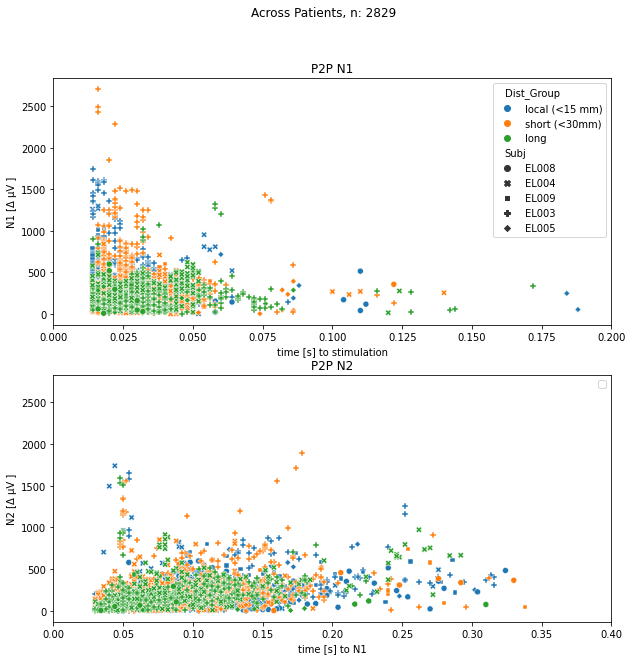

In [97]:
dat_plot   = data_con[(data_con.tN2N1>0.02)&(data_con.tN1>0.01)&(data_con.d>7)&(data_con.pN2<2000)&(data_con.pN1<3000)]
fig        = plt.figure(figsize=(10,10))
gs         = fig.add_gridspec(2,1) #, width_ratios=[5,3]
plt.suptitle('Across Patients, n: '+str(len(dat_plot)))
ax = fig.add_subplot(gs[0,0])
plt.title('P2P N1')
sns.scatterplot(x='tN1', y= 'pN1', data = dat_plot, hue= 'Dist_Group', style='Subj')
plt.xlabel('time [s] to stimulation')
plt.ylabel('N1 [\u0394 \u03BCV ]')
plt.xlim([0, 0.2])
fig.add_subplot(gs[1,0], sharey=ax)
plt.title('P2P N2')
sns.scatterplot(x='tN2N1', y= 'pN2', data = dat_plot, hue= 'Dist_Group', style='Subj')
plt.xlabel('time [s] to N1')
plt.ylabel('N2 [\u0394 \u03BCV ]')
plt.xlim([0,0.4])
plt.legend([])

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
gs         = fig.add_gridspec(2,1) #, width_ratios=[5,3]
plt.suptitle('Across Patients')
ax = fig.add_subplot(gs[0,0])
plt.title('P2P N1')
sns.scatterplot(x='tN1', y= 'pN1', data = dat_plot, hue= 'Dist_Group', style='Subj')
plt.xlabel('')
plt.xlim([0, 0.4])
fig.add_subplot(gs[1,0], sharex=ax, sharey=ax)
plt.title('P2P N2')
sns.scatterplot(x='tN2', y= 'pN2', data = dat_plot, hue= 'Dist_Group', style='Subj')
plt.xlabel('time [s]')

plt.show()

In [ ]:
plt.figure(figsize=(15,8))
b = sns.scatterplot(x="d", y='LL', hue='sig_trial', data=data_con)
plt.xlim([9.5,90])
plt.xlabel('distance [mm]',fontsize=16)
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('LL [\u0394 \u03BCV /ms]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()

In [ ]:
data_con_s.insert(10, 'sN1/N2',0)
data_con_s['sN1/N2']= data_con_s['sN1']/data_con_s['sN2']

In [ ]:
sns.catplot(x="Dist", y='N1/N2', data=data_con_s, kind='box', hue='Condition',palette=[cond_colors[1],cond_colors[3]])
plt.ylim([0,4])
#plt.ylim([0,8])

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="d", y='N1/N2', data=data_con_s, hue='Condition',palette=[cond_colors[1],cond_colors[3]])
#'Condition',palette=[cond_colors[1],cond_colors[3]]

plt.ylim([0,10])
plt.xlim(7.7,120)
plt.xlabel('distance [mm]')
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1/N2') 
plt.show()

In [ ]:
plt.scatter(data_con_s.d,data_con_s.N1/data_con_s.N2)
plt.ylim([0,15])
plt.xlim(7.7,120)

In [156]:
data_plot = data_con[(data_con['LL']<18)&(data_con['pN1']>100)&(data_con['pN1']<3000)&(data_con['d']>6)]
data_plot = data_plot.sort_values(by=['d'])

In [157]:
data_plot

Subj           StimR           ChanR         Chan           Stim  Int  \
3270  EL008    Basotemporal    Basotemporal  R_OTS_med36    R_OTS_med15  3.0   
3305  EL008    Basotemporal    Basotemporal  R_OTS_med36    R_OTS_med15  3.0   
1115  EL008    Basotemporal    Basotemporal  R_OTS_med15    R_OTS_med36  3.0   
3279  EL008    Basotemporal    Basotemporal  R_OTS_med36    R_OTS_med15  3.0   
1202  EL008    Basotemporal    Basotemporal  R_OTS_med15    R_OTS_med36  3.0   
...     ...             ...             ...          ...            ...  ...   
3742  EL004    Dorsofrontal    Dorsofrontal  R_IFGopc-44  R_MFG_post-51  3.0   
3759  EL008   Mesiotemporal  Laterotemporal      R_ITS41         L_Amy3  3.0   
517   EL008  Laterotemporal  Laterotemporal       L_STS9        R_ITS43  3.0   
551   EL008  Laterotemporal  Laterotemporal       L_STS9        R_ITS43  3.0   
628   EL008  Laterotemporal  Laterotemporal      L_MTG10        R_ITS43  3.0   

            LL      Dist_Group       d  sig_trial  ...  tN2N1        sN1  \
3270  3.460770  local (<15 mm)    6.01          1  ...  0.154  21.634986   
3305  1.994520  local (<15 mm)    6.01          1  ...  0.260  13.574808   
1115  3.555315  local (<15 mm)    6.01          1  ...  0.126  49.683315   
3279  2.667101  local (<15 mm)    6.01          1  ...  0.158  17.056793   
1202  3.739488  local (<15 mm)    6.01          1  ...  0.130  56.234290   
...        ...             ...     ...        ...  ...    ...        ...   
3742  3.027207            long   75.51          1  ...  0.080  34.955877   
3759  4.019681            long   76.74          1  ...  0.086  24.875728   
517   2.471737            long  104.05          1  ...  0.310   8.220267   
551   1.737790            long  104.05          1  ...  0.216   8.230391   
628   3.318566            long  107.57          1  ...  0.226  11.110951   

             pN2         pN1       zLL  Condition  Hour    Num  RespC  \
3270  173.245366  378.875925  5.194808        0.0  14.0  108.0    1.0   
3305  213.544284  264.609594  2.175281        0.0  14.0  149.0    1.0   
1115  246.154198  392.041573  4.217731        0.0  14.0   56.0    1.0   
3279  116.700465  340.283875  3.560364        0.0  14.0  118.0    1.0   
1202  251.491741  458.626455  4.543454        0.0  14.0  158.0    1.0   
...          ...         ...       ...        ...   ...    ...    ...   
3742  212.771652  157.255621  4.827266        0.0  16.0    4.0    1.0   
3759  291.389619  161.624790  7.413572        0.0  14.0  162.0    1.0   
517    73.063780  520.854007  5.117992        0.0  14.0  133.0    1.0   
551    77.603985  297.487550  2.937560        0.0  14.0  175.0    1.0   
628   115.318958  600.095773  6.009563        0.0  14.0  133.0    1.0   

        LLpeak  
3270  2.551554  
3305  2.551554  
1115  3.665886  
3279  2.551554  
1202  3.665886  
...        ...  
3742  2.933741  
3759  1.641622  
517   1.298480  
551   1.298480  
628   1.395030  

[2822 rows x 23 columns]

In [ ]:
np.unique(data_plot.Dist_Group)

In [ ]:
sns.lmplot(x="LL", y="pN2", data=data_d)

In [ ]:
np.unique(data_plot.Dist_Group)

In [ ]:
plt.figure(figsize=(15,8))
for dd in np.unique(data_plot.Dist_Group):
    data_d = data_plot[data_plot.Dist_Group==dd]
    p = stats.pearsonr(data_d['pN1'], data_d['pN2'])
    #sns.lmplot(x="LL", y=l, data=data_d)
    plt.scatter(data_d['pN1'], data_d['pN2'],label= dd+', R: '+str(np.round(p[0],2)), alpha=0.5)
#sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
#plt.xlim([9,90])
plt.legend()
#plt.xlabel('LL [\u0394 \u03BCV /ms]')
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel(l+' [\u0394 \u03BCV ]') 
plt.show()

In [17]:
data_plot = data_plot.sort_values(by=['d'])

In [22]:
np.unique(data_plot.Dist_Group)

array(['local (<15 mm)', 'long', 'mid (<60mm)', 'short (<30mm)'],
      dtype=object)

In [24]:
from sklearn.metrics import r2_score


In [26]:
model = np.polyfit(x, y, 1)
predict = np.poly1d(model)

In [38]:
x_lin_reg = range(0, 51)
y_lin_reg = predict(x_lin_reg)
plt.scatter(x, y)
plt.plot(x_lin_reg, y_lin_reg, c = 'r')

3376    0.014
3410    0.014
3430    0.016
956     0.026
1023    0.024
        ...  
4066    0.082
4079    0.086
1957    0.026
2011    0.028
1991    0.032
Name: tN1, Length: 977, dtype: float64

In [39]:
np.min(x)

0.014

In [61]:
dist_labels

['local (<15 mm)', 'short (<30mm)', 'long']

In [85]:
'\u0394 \u03BCV'

'Δ μV'

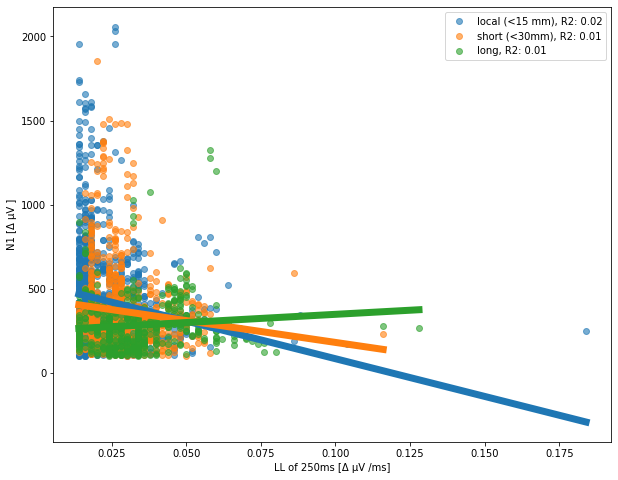

In [175]:
plt.figure(figsize=(10,8))
for dd in dist_labels:
    data_d = data_plot[(data_plot.Dist_Group==dd)]
    x= data_d['tN1']
    y= data_d['pN1']
    model = np.polyfit(x, y, 1)
    predict = np.poly1d(model)
    #p = #stats.pearsonr(x, y)
    r2  = r2_score(y, predict(x))
    x_lin_reg = np.linspace(np.min(x), np.max(x))
    y_lin_reg = predict(x_lin_reg)
    plt.scatter(x, y,label= dd+', R2: '+str(np.round(r2,2)), alpha = 0.6)
    plt.plot(x_lin_reg, y_lin_reg, linewidth = 7)
    #plt.scatter(data_d['pN1'], data_d['pN2'],label= dd+', R2: '+str(np.round(r2,2)), alpha=0.5)
#sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
#plt.xlim([9,90])
plt.legend()
plt.xlabel('LL of 250ms [\u0394 \u03BCV /ms]')
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1 [\u0394 \u03BCV ]') 
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for dd in dist_labels:
    data_d = data_plot[data_plot.Dist_Group==dd]
    x= data_d['LL']
    y= data_d['pN1']
    model = np.polyfit(x, y, 1)
    predict = np.poly1d(model)
    #p = #stats.pearsonr(x, y)
    r2  = r2_score(y, predict(x))
    x_lin_reg = np.linspace(np.min(x), np.max(x))
    y_lin_reg = predict(x_lin_reg)
    plt.scatter(x, y,label= dd+', R2: '+str(np.round(r2,2)), alpha = 0.6)
    plt.plot(x_lin_reg, y_lin_reg, linewidth = 7)
    #plt.scatter(data_d['pN1'], data_d['pN2'],label= dd+', R2: '+str(np.round(r2,2)), alpha=0.5)
#sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
#plt.xlim([9,90])
plt.legend()
plt.xlabel('LL of 250ms [\u0394 \u03BCV /ms]')
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1 [\u0394 \u03BCV ]') 
plt.show()

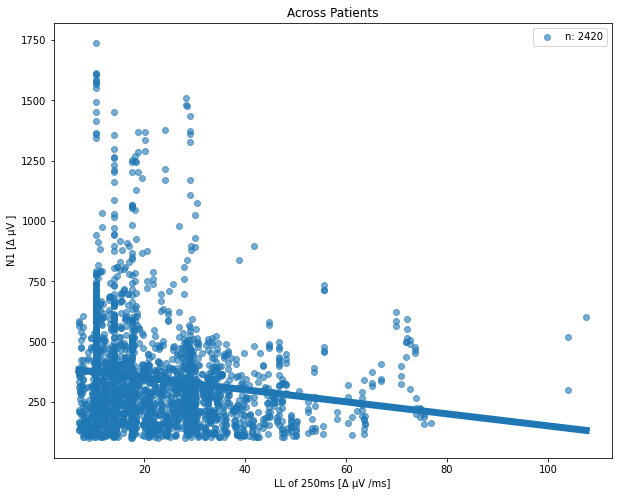

In [150]:
plt.figure(figsize=(10,8))
plt.title('Across Patients')
data_d = data_plot#[data_plot.Dist_Group==dd]
x= data_d['d']
y= data_d['pN1']
model = np.polyfit(x, y, 1)
predict = np.poly1d(model)
#p = #stats.pearsonr(x, y)
r2  = r2_score(y, predict(x))
x_lin_reg = np.linspace(np.min(x), np.max(x))
y_lin_reg = predict(x_lin_reg)
plt.scatter(x, y,label= 'n: '+str(len(x)), alpha = 0.6)
plt.plot(x_lin_reg, y_lin_reg, linewidth = 7)
    #plt.scatter(data_d['pN1'], data_d['pN2'],label= dd+', R2: '+str(np.round(r2,2)), alpha=0.5)
#sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
#plt.xlim([9,90])
plt.legend()
plt.xlabel('LL of 250ms [\u0394 \u03BCV /ms]')
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1 [\u0394 \u03BCV ]') 
plt.show()

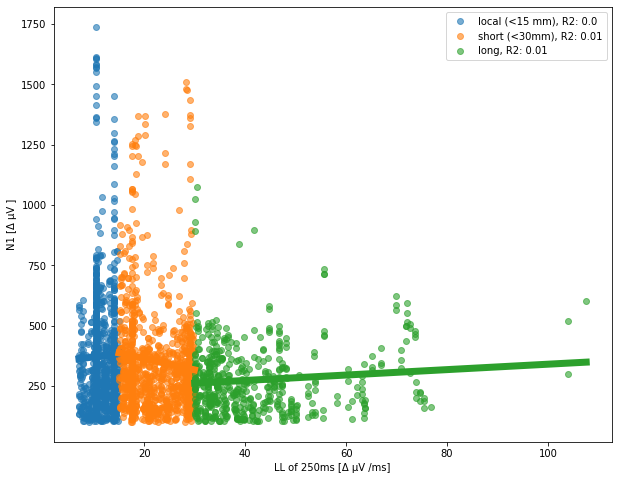

In [151]:
plt.figure(figsize=(10,8))
for dd in dist_labels:
    data_d = data_plot[data_plot.Dist_Group==dd]
    x= data_d['d']
    y= data_d['pN1']
    model = np.polyfit(x, y, 1)
    predict = np.poly1d(model)
    #p = #stats.pearsonr(x, y)
    r2  = r2_score(y, predict(x))
    x_lin_reg = np.linspace(np.min(x), np.max(x))
    y_lin_reg = predict(x_lin_reg)
    plt.scatter(x, y,label= dd+', R2: '+str(np.round(r2,2)), alpha = 0.6)
    plt.plot(x_lin_reg, y_lin_reg, linewidth = 7)
    #plt.scatter(data_d['pN1'], data_d['pN2'],label= dd+', R2: '+str(np.round(r2,2)), alpha=0.5)
#sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
#plt.xlim([9,90])
plt.legend()
plt.xlabel('LL of 250ms [\u0394 \u03BCV /ms]')
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1 [\u0394 \u03BCV ]') 
plt.show()

In [127]:
model

array([ 28.5083112 , 145.98664671])

In [130]:
x_lin_reg

array([ 1.39682403,  1.66978674,  1.94274946,  2.21571218,  2.48867489,
        2.76163761,  3.03460032,  3.30756304,  3.58052575,  3.85348847,
        4.12645119,  4.3994139 ,  4.67237662,  4.94533933,  5.21830205,
        5.49126477,  5.76422748,  6.0371902 ,  6.31015291,  6.58311563,
        6.85607834,  7.12904106,  7.40200378,  7.67496649,  7.94792921,
        8.22089192,  8.49385464,  8.76681736,  9.03978007,  9.31274279,
        9.5857055 ,  9.85866822, 10.13163093, 10.40459365, 10.67755637,
       10.95051908, 11.2234818 , 11.49644451, 11.76940723, 12.04236994,
       12.31533266, 12.58829538, 12.86125809, 13.13422081, 13.40718352,
       13.68014624, 13.95310896, 14.22607167, 14.49903439, 14.7719971 ])

In [162]:
data_plot = data_plot[data_plot.pN2>50]

In [176]:
data_plot

Subj           StimR           ChanR         Chan           Stim  Int  \
3270  EL008    Basotemporal    Basotemporal  R_OTS_med36    R_OTS_med15  3.0   
3305  EL008    Basotemporal    Basotemporal  R_OTS_med36    R_OTS_med15  3.0   
1115  EL008    Basotemporal    Basotemporal  R_OTS_med15    R_OTS_med36  3.0   
3279  EL008    Basotemporal    Basotemporal  R_OTS_med36    R_OTS_med15  3.0   
1202  EL008    Basotemporal    Basotemporal  R_OTS_med15    R_OTS_med36  3.0   
...     ...             ...             ...          ...            ...  ...   
3742  EL004    Dorsofrontal    Dorsofrontal  R_IFGopc-44  R_MFG_post-51  3.0   
3759  EL008   Mesiotemporal  Laterotemporal      R_ITS41         L_Amy3  3.0   
517   EL008  Laterotemporal  Laterotemporal       L_STS9        R_ITS43  3.0   
551   EL008  Laterotemporal  Laterotemporal       L_STS9        R_ITS43  3.0   
628   EL008  Laterotemporal  Laterotemporal      L_MTG10        R_ITS43  3.0   

            LL      Dist_Group       d  sig_trial  ...  tN2N1        sN1  \
3270  3.460770  local (<15 mm)    6.01          1  ...  0.154  21.634986   
3305  1.994520  local (<15 mm)    6.01          1  ...  0.260  13.574808   
1115  3.555315  local (<15 mm)    6.01          1  ...  0.126  49.683315   
3279  2.667101  local (<15 mm)    6.01          1  ...  0.158  17.056793   
1202  3.739488  local (<15 mm)    6.01          1  ...  0.130  56.234290   
...        ...             ...     ...        ...  ...    ...        ...   
3742  3.027207            long   75.51          1  ...  0.080  34.955877   
3759  4.019681            long   76.74          1  ...  0.086  24.875728   
517   2.471737            long  104.05          1  ...  0.310   8.220267   
551   1.737790            long  104.05          1  ...  0.216   8.230391   
628   3.318566            long  107.57          1  ...  0.226  11.110951   

             pN2         pN1       zLL  Condition  Hour    Num  RespC  \
3270  173.245366  378.875925  5.194808        0.0  14.0  108.0    1.0   
3305  213.544284  264.609594  2.175281        0.0  14.0  149.0    1.0   
1115  246.154198  392.041573  4.217731        0.0  14.0   56.0    1.0   
3279  116.700465  340.283875  3.560364        0.0  14.0  118.0    1.0   
1202  251.491741  458.626455  4.543454        0.0  14.0  158.0    1.0   
...          ...         ...       ...        ...   ...    ...    ...   
3742  212.771652  157.255621  4.827266        0.0  16.0    4.0    1.0   
3759  291.389619  161.624790  7.413572        0.0  14.0  162.0    1.0   
517    73.063780  520.854007  5.117992        0.0  14.0  133.0    1.0   
551    77.603985  297.487550  2.937560        0.0  14.0  175.0    1.0   
628   115.318958  600.095773  6.009563        0.0  14.0  133.0    1.0   

        LLpeak  
3270  2.551554  
3305  2.551554  
1115  3.665886  
3279  2.551554  
1202  3.665886  
...        ...  
3742  2.933741  
3759  1.641622  
517   1.298480  
551   1.298480  
628   1.395030  

[2369 rows x 23 columns]

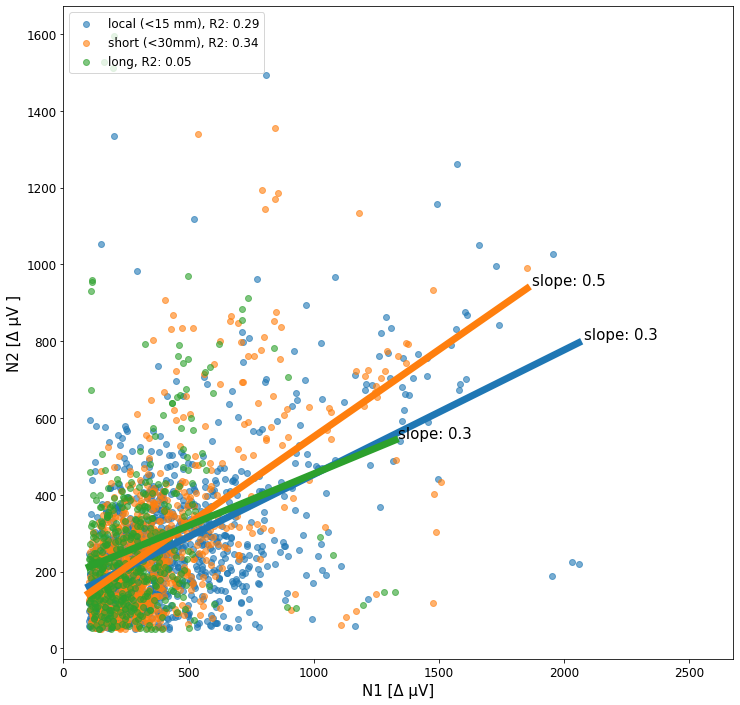

In [170]:
xmax= 12
plt.figure(figsize=(12,12))
for dd in dist_labels:
    data_d = data_plot[data_plot.Dist_Group==dd]
    x= data_d['pN1']
    y= data_d['pN2']
    model = np.polyfit(x, y, 1)
    
    predict = np.poly1d(model)
    #p = #stats.pearsonr(x, y)
    r2  = r2_score(y, predict(x))
    x_lin_reg = np.linspace(np.min(x), np.max(x))
    y_lin_reg = predict(x_lin_reg)
    plt.scatter(x, y,label= dd+', R2: '+str(np.round(r2,2)), alpha = 0.6)
    plt.plot(x_lin_reg, y_lin_reg, linewidth = 7)
    plt.text(1.01*np.max(x_lin_reg), 1.01*np.max(y_lin_reg), 'slope: '+str(round(model[0],1)), fontsize=15)
    xmax = np.max([xmax, 1.3*np.max(x_lin_reg)])
    #plt.scatter(data_d['pN1'], data_d['pN2'],label= dd+', R2: '+str(np.round(r2,2)), alpha=0.5)
#sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
#plt.xlim([9,90])
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('LL of 250ms [\u0394 \u03BCV /ms]', fontsize=15)
plt.xlabel('N1 [\u0394 \u03BCV]')
plt.xlim([0,xmax])
plt.ylabel('N2 [\u0394 \u03BCV ]', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
for l in ['pN1', 'pN2']:
    plt.figure(figsize=(15,8))
    for dd in np.unique(data_plot.Dist_Group):
        data_d = data_plot[data_plot.Dist_Group==dd]
        p = stats.pearsonr(data_d.LL, data_d[l])
        #sns.lmplot(x="LL", y=l, data=data_d)
        plt.scatter(data_d.LL, data_d[l],label= dd+', R: '+str(np.round(p[0],2)), alpha=0.5)
    #sns.scatterplot(x="LL", y=l, data=data_plot, hue='Dist_Group')
    #plt.xlim([9,90])
    plt.legend()
    plt.xlabel('LL [\u0394 \u03BCV /ms]')
    #plt.xlabel('N1 [\u0394 \u03BCV]')
    plt.ylabel(l+' [\u0394 \u03BCV ]') 
    plt.show()

In [ ]:
for l in ['N1', 'N2']:
    plt.figure(figsize=(15,8))
    sns.scatterplot(x="d", y=l, data=data_con, hue='StimR')
    plt.xlim([9,90])
    plt.xlabel('distance [mm]')
    #plt.xlabel('N1 [\u0394 \u03BCV]')
    plt.ylabel(l+' [\u0394 \u03BCV ]') 
    plt.show()

In [ ]:
for l in ['sN1', 'sN2']:
    plt.figure(figsize=(15,8))
    sns.scatterplot(x="d", y=l, data=data_con, hue='StimR')
    plt.xlim([9,90])
    plt.xlabel('distance [mm]')
    #plt.xlabel('N1 [\u0394 \u03BCV]')
    plt.ylabel(l+' [\u0394 \u03BCV /ms]') 
    plt.show()

In [ ]:
sns.lmplot(x="FlyAsh", y="Strength", hue="AirEntrain", data=con)

In [ ]:
data_con.insert(0,'Dist', 'local (<15mm)')
data_con.loc[data_con.d>15, 'Dist'] = 'short (<30mm)'
data_con.loc[data_con.d>30, 'Dist'] = 'mid (<60mm)'
data_con.loc[data_con.d>60, 'Dist'] = 'long'

In [ ]:
data_con_s =  data_con.sort_values('d')

In [ ]:
sns.lmplot(x="N2", y="sN2", data=data_con_s, hue= 'Dist')
#p = stats.pearsonr(data_con_p["LL"], data_con_p[l])
plt.xlabel('distance [mm]')
#plt.text(2500, 0, 'Pearson: '+str(np.round(p[0],2)))
plt.xlabel('N2 [\u0394 \u03BCV/ms]')
#plt.xlabel('LL [\u0394 \u03BCV /ms]')
plt.ylabel('N2 [\u0394 \u03BCV]') 
plt.show()

In [ ]:
sns.lmplot(x="sN1", y="sN2", data=data_con_s, hue= 'Dist')
#p = stats.pearsonr(data_con_p["LL"], data_con_p[l])
plt.xlabel('distance [mm]')
#plt.text(2500, 0, 'Pearson: '+str(np.round(p[0],2)))
plt.xlabel('N1 [\u0394 \u03BCV/ms]')
#plt.xlabel('LL [\u0394 \u03BCV /ms]')
plt.ylabel('N2 [\u0394 \u03BCV/ms]') 
plt.show()

In [ ]:
sns.lmplot(x="N1", y="N2", data=data_con_s, hue= 'Dist')
#p = stats.pearsonr(data_con_p["LL"], data_con_p[l])
plt.xlabel('distance [mm]')
#plt.text(2500, 0, 'Pearson: '+str(np.round(p[0],2)))
plt.xlabel('N1 [\u0394 \u03BCV ]')
#plt.xlabel('LL [\u0394 \u03BCV /ms]')
plt.ylabel('N2 [\u0394 \u03BCV]') 
plt.show()

In [ ]:
data_con.loc[data_con.StimR=='HIPP', 'StimR'] = 'Mesiotemporal'
data_con.loc[data_con.StimR=='HIPP ', 'StimR'] = 'Mesiotemporal'
data_con.loc[data_con.StimR=='ENT', 'StimR'] = 'Basotemporal'

data_con.loc[data_con.ChanR=='HIPP' , 'RespR'] = 'Mesiotemporal'
data_con.loc[data_con.ChanR=='HIPP ', 'RespR'] = 'Mesiotemporal'
data_con.loc[data_con.ChanR=='ENT'  , 'RespR'] = 'Basotemporal'

In [ ]:
data_con

In [ ]:
stop

## Connections by distance

In [ ]:
data_A

In [ ]:
subj

In [ ]:
color_elab

In [ ]:
plt.figure(figsize=(8,5))
i=0
for subj in subjs:

    plot_Z_dist(data_A[(data_A.LL_BL<8)&(data_A.d>7.5)&(data_A.LL_BL>0)&(data_A.subj==subj)], color_elab[i])
    # plt.savefig('T:\EL_experiment\Patients\\all/Analysis/BrainMapping/figures/CCEP_dist.svg')
    # plt.savefig('T:\EL_experiment\Patients\\all/Analysis/BrainMapping/figures/CCEP_dist.jpg')
    i=i+1
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plot_Z_dist(data_A[(data_A.LL_BL<7)&(data_A.d>7.5)&(data_A.LL_BL>0)])
# plt.savefig('T:\EL_experiment\Patients\\all/Analysis/BrainMapping/figures/CCEP_dist.svg')
# plt.savefig('T:\EL_experiment\Patients\\all/Analysis/BrainMapping/figures/CCEP_dist.jpg')
plt.show()

In [ ]:
def plot_Z_dist(data, c=[color_elab[0]] ):
    plt.title('CCEP strength')
    plt.xlabel('distance [mm]')
    plt.ylabel('LL [uV/ms]')
    #plt.scatter(data[data.Change==0].d, data[data.Change==0].LLz, c= [color_elab[0]], alpha=0.2,edgecolors=[0,0,0], label='BZD no change')
    #plt.scatter(data[data.Change==1].d, data[data.Change==1].LLz, c= [color_elab[0]], alpha=0.7,edgecolors=[0,0,0], label='BZD Effect')
    #plt.legend()
    plt.scatter(data.d, data.LL_BL, c= c, alpha=0.7,edgecolors=[0,0,0])
    plt.xlim(5,83)
    plt.ylim(0,8)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plt.figure(figsize=(8,5))
plot_Z_dist(data_B[(data_B.LL_Ratio<0.8)], color_elab[0])
plot_Z_dist(data_B[(data_B.LL_Ratio>=0.8)], color_elab[3])
plt.legend(['Connection decreased', 'Connection unchanged'])
plt.show()

In [ ]:
data_A

In [ ]:
data_B = data_A[(data_A.LL_BL<8)&(data_A.d>7)&(data_A.LL_BL>0)]
stim_regions = np.unique([data_B.StimR,data_B.RespR])
stim_regions_G = []
for i in range(len(stim_regions)):
    stim_regions_G.append(regions_G[regions==stim_regions[i]][0])
M = np.zeros((len(stim_regions),len(stim_regions),3))
for sc in range(len(stim_regions)):
    for rc in range(len(stim_regions)):
        T =  len(data_B[(data_B.RespR == stim_regions[rc])&(data_B.StimR == stim_regions[sc])])
        if T>0:
            C = len(data_B[(data_B.RespR == stim_regions[rc])&(data_B.StimR == stim_regions[sc])&(data_B.Cluster_BL==0)])
            M[sc,rc,0] = C/T
            M[sc,rc,1] = C
            M[sc,rc,2] = T
ix = np.argsort(stim_regions_G)
M = M[:,ix]
M = M[ix,:]

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(M[:,:,0], interpolation='nearest', cmap=cmap, vmax = 0.8)
ax.figure.colorbar(im, ax=ax)

plt.yticks(np.arange(M.shape[0]),stim_regions[ix])
plt.xticks(np.arange(M.shape[1]),stim_regions[ix], rotation='45')
plt.ylabel('Stimulation Area')
plt.xlabel('Response Area')
thresh = M[:,:,0].max() / 1.5
for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
    plt.text(j, i, str(M[i, j,1])+'/'+str(M[i, j,2]),
                 horizontalalignment="center",
                 color="white" if M[i, j,0] > thresh else "black")

In [ ]:
data_B = data_A[(data_A.LL_BL<8)&(data_A.d>7)&(data_A.LL_BL>0)]

stim_regions = np.unique([data_B.StimR,data_B.RespR])
stim_regions_G = []
for i in range(len(stim_regions)):
    stim_regions_G.append(regions_G[regions==stim_regions[i]][0])
M = np.zeros((len(stim_regions),len(stim_regions),3))
for sc in range(len(stim_regions)):
    for rc in range(len(stim_regions)):
        T =  len(data_B[(data_B.RespR == stim_regions[rc])&(data_B.StimR == stim_regions[sc])])
        if T>0:
            C = len(data_B[(data_B.RespR == stim_regions[rc])&(data_B.StimR == stim_regions[sc])&(data_B.LL_Ratio<0.8)])
            M[sc,rc,0] = C/T
            M[sc,rc,1] = C
            M[sc,rc,2] = T
ix = np.argsort(stim_regions_G)
M = M[:,ix]
M = M[ix,:]

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(M[:,:,0], interpolation='nearest', cmap=cmap, vmax = 0.8)
ax.figure.colorbar(im, ax=ax)

plt.yticks(np.arange(M.shape[0]),stim_regions[ix])
plt.xticks(np.arange(M.shape[1]),stim_regions[ix], rotation='45')
plt.ylabel('Stimulation Area')
plt.xlabel('Response Area')
thresh = M[:,:,0].max() / 1.5
for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
    plt.text(j, i, str(M[i, j,1])+'/'+str(M[i, j,2]),
                 horizontalalignment="center",
                 color="white" if M[i, j,0] > thresh else "black")

In [ ]:
stim_regions = np.unique([data_A.StimR,data_A.RespR])
stim_regions_G = []
for i in range(len(stim_regions)):
    stim_regions_G.append(regions_G[regions==stim_regions[i]][0])
M = np.zeros((len(stim_regions),len(stim_regions),3))
for sc in range(len(stim_regions)):
    for rc in range(len(stim_regions)):
        T =  len(data_A[(data_A.RespR == stim_regions[rc])&(data_A.StimR == stim_regions[sc])])
        if T>0:
            C = len(data_A[(data_A.RespR == stim_regions[rc])&(data_A.StimR == stim_regions[sc])&(data_A.LL_BL > 0)])
            M[sc,rc,0] = C/T
            M[sc,rc,1] = C
            M[sc,rc,2] = T
ix = np.argsort(stim_regions_G)
M = M[:,ix]
M = M[ix,:]

In [ ]:
import itertools
cmap = plt.get_cmap('Blues')

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(M[:,:,0], interpolation='nearest', cmap=cmap, vmax = 0.8)
ax.figure.colorbar(im, ax=ax)

plt.yticks(np.arange(M.shape[0]),stim_regions[ix])
plt.xticks(np.arange(M.shape[1]),stim_regions[ix], rotation='45')
plt.ylabel('Stimulation Area')
plt.xlabel('Response Area')
thresh = M[:,:,0].max() / 1.5
for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
    plt.text(j, i, str(M[i, j,1])+'/'+str(M[i, j,2]),
                 horizontalalignment="center",
                 color="white" if M[i, j,0] > thresh else "black")

In [ ]:
sc = 0
rc = 1


In [ ]:
data_A.loc[data_A['RespR']=='HIPP','RespR' ]     = 'Mesiotemporal'
data_A.loc[data_A['StimR']=='HIPP','StimR' ]     = 'Mesiotemporal'
data_A.loc[data_A['RespR']=='HIPP ','RespR' ]    = 'Mesiotemporal'
data_A.loc[data_A['StimR']=='HIPP ','StimR' ]    = 'Mesiotemporal'
data_A.loc[data_A['RespR']=='Temporal','RespR' ] = 'Basotemporal'
data_A.loc[data_A['StimR']=='Temporal','StimR' ] = 'Basotemporal'



In [ ]:
sns.catplot(y="Resp Region", x="Stim Region",hue="Change",data=data_all, kind="swarm",height=4, aspect=4, s=2)

In [ ]:
plt.figure(figsize=(15,7))
sns.catplot(y="d", x="Stim Region",hue="Resp Region", col="Change",data=data_all, kind="swarm",height=5, aspect=3);
plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_benzo_dist.svg')
plt.show()

In [ ]:
sns.catplot(x="dist", y="Stim Region",hue="Resp Region", data=data_all, kind='swarm',
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)

In [ ]:
list_BZD

In [ ]:
c = 80
s = 33
list_BL    = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==1)]
list_BZD   = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==3)]

In [ ]:
EEG_trial      = EEG_resp[c,list_BZD.Num.values.astype('int'),:]
mx_BZD,_,_         = LL_mx(EEG_trial)

In [ ]:
EEG_trial      = EEG_resp[c,list_BL.Num.values.astype('int'),:]
mx_BL,_,_         = LL_mx(EEG_trial)

In [ ]:
mx_BL

In [ ]:
data_A.drop_duplicates()

In [ ]:
data_A = data_A.drop_duplicates()

In [ ]:
data_A.loc[(data_A.Stim==0)&(data_A.Chan==2)&(data_A.Subj==subj)].drop_duplicates()

In [ ]:
np.mean(data_A.loc[((data_A.Stim==0)&(data_A.Chan==2)&(data_A.Subj==subj)),'LL_BZD'])

In [ ]:
cond_labels[1] = 'Control'

In [ ]:
def plot_conds(sc, rc, LL_CCEP, data_A, conds, EEG_resp):
    LL_BZD = np.zeros((2,))
    LL_BZD[1] = np.mean(data_A.loc[((data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Subj==subj)),'LL_BZD'])
    LL_BZD[0]  = np.mean(data_A.loc[((data_A.Stim==sc)&(data_A.Chan==rc)&(data_A.Subj==subj)),'LL_BL'])
    fig, axs   = plt.subplots(len(conds),1, figsize=(5,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_region[sc]+'--'+labels_region[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', LL peak: '+str(np.round(LL_BZD[i],1))+'uV/ms')
        axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.25, 1)
        axs[i].set_xticks([])
        axs[i].set_yticks([-300,0,300])
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 45, Fs), c=[0,0,0], linewidth=3 )
    
    plt.xticks([-0.25, 0, 0.5,1])
    plt.xlabel('time [s]')
    #plt.tight_layout()

In [ ]:
dat

In [ ]:
LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]

In [ ]:
dat      = data_A[(data_A.Benzo==-1)&(data_A.Subj==subj)]
k        = np.random.randint(0, len(dat))
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])

plot_conds(sc,rc, LL_CCEP, data_A,[1,3], EEG_resp)

In [ ]:

plot_conds(sc,rc, LL_CCEP, data_A,[1,3], EEG_resp)
plt.savefig('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/figures/'+subj+'-'+labels_all[sc]+'_'+labels_all[rc]+'.svg')

In [ ]:
plot_conds(s, c, LL_CCEP, [1,3], EEG_resp)

In [ ]:
data_A

In [ ]:
data_A[(data_A.Benzo==-1)&(data_A.Subj==subj)]

In [ ]:
data_A.to_csv(path_patient + '/Analysis/BrainMapping/Ph/data/Benzo_decrease.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
sns.catplot(y="d", x="Benzo",hue="Benzo",data=data_A, col = 'Resp Region', row = 'Stim Region', kind="swarm",height=3, aspect=1.5);

In [ ]:
plt.figure(figsize=(7,7))
sns.catplot(y="d", x="Benzo",hue="Benzo",data=data_A, col = 'Resp Region', row = 'Stim Region', kind="swarm",height=3, aspect=1.5);
plt.savefig('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/figures/Benzo_Area.svg')

In [ ]:
t = 0.8
data_A.loc[(data_A.LL_Ratio<t), 'Benzo'] = -1
data_A.loc[(data_A.LL_Ratio>t-0.001), 'Benzo'] = 0

In [ ]:
data_A.to_csv('/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/Benzo_decrease_all.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
path    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/EL005'
data_5 = pd.read_csv(path + '/Analysis/BrainMapping/Ph/data/Benzo_decrease.csv')
path    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/EL008'
data_8 = pd.read_csv(path + '/Analysis/BrainMapping/Ph/data/Benzo_decrease.csv')

In [ ]:
data_4

In [ ]:
data_A

In [ ]:
data_A = pd.concat([data_4, data_5, data_8])

In [ ]:
data_4 = data_A

In [ ]:
labels_region

In [ ]:
lists

In [ ]:
data_asym     = np.zeros((1,9))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)&(~np.isnan(LL_CCEP.LL.values))]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_BL    = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==1)]
        list_BZD   = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==3)]
        if (len(list_BL)>0)&(len(list_BZD)>0):
            EEG_trial      = EEG_resp[c,list_BL.Num.values.astype('int'),:]
            mx_BL,_,_         = LL_mx(EEG_trial)
            EEG_trial      = EEG_resp[c,list_BZD.Num.values.astype('int'),:]
            mx_BZD,_,_         = LL_mx(EEG_trial)
            val         = np.zeros((1, 9))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.mean(list_BL.z) # LL zscore
            val[0, 3]   = mx_BL # BL
            val[0, 4]   = mx_BZD # BZD
            val[0, 5]   = mx_BZD/mx_BL # Ratio
            val[0, 6]   = np.mean(list_BZD.d) # distance
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1],"LLz": data_asym[:, 2],"LL_BL": data_asym[:, 3],"LL_BZD": data_asym[:, 4],"LL_Ratio": data_asym[:, 5], "d": data_asym[:, 6]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]

data_A.insert(0,'Subj',subj)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Stim Region']=='WM'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='WM'].index)
data_A=data_A.drop(data_A[data_A['d']<7].index)
data_A.loc[(data_A.d <10), "dist"] = 'short'
data_A.loc[(data_A.d >=10)&(data_A.d <50), "dist"] = 'mid'
data_A.loc[(data_A.d >=50)&(data_A.d <100), "dist"] = 'mid'
data_A.loc[(data_A.d >100), "dist"] = 'verylong'
data_A.insert(5,'Benzo',0)
data_A.loc[(data_A.LL_Ratio<0.9), 'Benzo'] = -1
data_A.to_csv(path_patient + '/Analysis/BrainMapping/Ph/data/Benzo_decrease.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)&(~np.isnan(LL_CCEP.LL.values))]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)]
        if len(list_1)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.mean(list_1.z) # LL zscore
            val[0, 3]   = np.mean(list_1.Benzo)-1 #LL_CCEP.Benzo
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1],"LLz": data_asym[:, 2],"Change": data_asym[:, 3], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    #data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    #data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(0,'Subj',subj)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Stim Region']=='WM'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='WM'].index)
data_A=data_A.drop(data_A[data_A['d']<7].index)
data_A.loc[(data_A.d <10), "dist"] = 'short'
data_A.loc[(data_A.d >=10)&(data_A.d <50), "dist"] = 'mid'
data_A.loc[(data_A.d >=50)&(data_A.d <100), "dist"] = 'mid'
data_A.loc[(data_A.d >100), "dist"] = 'verylong'

In [ ]:
data_A

In [ ]:
data_all = data_A

In [ ]:
data_all

In [ ]:
data_all = pd.concat([data_all,data_A])

In [ ]:
#### Connections by distance
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)&(~np.isnan(lists.LL.values))]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)]
        if len(list_1)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.mean(list_1.z) # LL zscore
            val[0, 3]   = s # BZD
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1],"LLz": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    #data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    #data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(0,'Subj',subj)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Stim Region']=='WM'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='WM'].index)

#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connections by distance and regions')
k=0

data_test = data_A[(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-x_lim/12, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))


plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, x_lim])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')
filename    = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_distance.png'
plt.savefig(filename)
plt.show()

In [ ]:
#### Connections by distance
x_lim = 35
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)]
        if len(list_1)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "Diff": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)

#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connections by distance and regions')
k=0

data_test = data_A[(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-x_lim/12, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))


plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, x_lim])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')
filename    = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_distance.png'
plt.savefig(filename)
plt.show()

In [ ]:
r = 1 #&(LL_CCEP['LL'] <1)
a = 1
d = 10
dat      = LL_CCEP[(~np.isnan(LL_CCEP['LL']))&(LL_CCEP['d'] >d)&(LL_CCEP['RespC'] ==1)]

k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])
plot_trial(sc, rc, stimNum, LL_CCEP,EEG_resp)

w =0.1
d = 10
#r = 1
#c = 1
dat      = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP['d'] >d)&(LL_CCEP['RespC']==1)]
#
k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc = np.int64(dat.Stim.values[k])
rc = np.int64(dat.Chan.values[k])
#sc = 10
#rc= 60
j = 3
win_t = 1 *w
lists          = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
lists          = lists[~np.isnan(lists.zLL.values)]
stimNum_all    = lists.Num.values.astype('int')
n= 100
if len(stimNum_all)>0:
    list_BL        = LL_CCEP[(LL_CCEP['d']>20)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==sc)&~np.isnan(LL_CCEP.zLL.values)]
    stimNum_BL     = list_BL.Num.values.astype('int')
    resp_BL        = np.zeros((n, np.sum(abs(dur))*Fs))
    for k in range(n):
        resp_BL[k,:] = ff.lp_filter(np.nanmean(EEG_resp[rc,np.random.choice(stimNum_BL, len(stimNum_all)),:],0),45,Fs)
    LL_BL     = LL_funcs.get_LL_all(np.expand_dims(resp_BL, axis=0), Fs, w, 1, 0)
    LL_BL     = LL_BL[0]

    resp       = ff.lp_filter(np.nanmean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp    = LL_resp[0,0]

    LL_meregd  = np.concatenate([LL_BL, np.expand_dims(LL_resp,0)])
    #thr        = np.percentile(LL_meregd[0:np.int64((1-w/2-0.05)*Fs)],99)
    thr        = np.percentile(LL_BL[0:np.int64((2.5)*Fs)],99)
    if  all(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+win_t)*Fs)]>thr):
        print('yes')

                
    #resp           = ff.lp_filter(np.nanmean(EEG_resp[rc,stimNum_all,:],0),10,Fs)
    fig   = plt.figure(figsize=(10,10) )
    plt.suptitle(labels_clinic[sc]+' -- '+labels_clinic[rc]+', Distance: '+str(np.round(lists.d.values[0],2))+'mm')
    gs    = fig.add_gridspec(2,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ax   = fig.add_subplot(gs[0,0])
# 
    plt.xlim([-1, 1])
    # 
    plt.axvspan(0.01, w, alpha=0.2, color=[1,0,0])
    plt.axvspan(0.01+win_t-w/2,0.01+win_t+w/2, color=[1,0.5,0], alpha=0.1)
    for k in range(len(stimNum_all)):
         plt.plot(x_ax, ff.lp_filter(EEG_resp[rc,stimNum_all[k],:],45,Fs), c=color_elab[0], linewidth=1)
    plt.plot(x_ax,resp, c=[0,0,0], linewidth=3, label='mean resp, n:'+str(len(stimNum_all)))
    plt.title('Mean Responses + single trial')
    # #plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.ylim([-np.min([np.max([200,np.max(abs(resp))*2]),800]),np.min([np.max([200,np.max(abs(resp))*2]),800])])
    # #plt.ylim([-100,100])
    plt.ylabel('[uV]')
    plt.axvline(0, c=[0,0,0])
    ax   = fig.add_subplot(gs[1,0], sharex=ax)
# 
    # 
    # LL_resp   = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    # LL_resp   = LL_resp[0,0]
    plt.axvline(0, c=[0,0,0])
    for k in range(n):
         plt.plot(x_ax, LL_BL[k], c=color_elab[2], linewidth=1)
    plt.plot(x_ax,LL_resp, c=[0,0,0], linewidth=3)
    #plt.plot(x_ax, scipy.stats.zscore(LL_resp)/10, linewidth=3 )
    # #plt.plot(np.argmax(LL_resp[np.int64(Fs*(1.01+w/2)):np.int64(Fs*(1.01+1.5*w))])/Fs+0.01+w/2,np.max(LL_resp[np.int64(Fs*(1.01+w/2)):np.int64(Fs*(1.01+1.5*w))]), 'or')
    plt.title('LL of Mean Responses (surrogates)')
    # #LL_meregd = np.concatenate([LL_BL, np.expand_dims(LL_resp,0)])
# 
    # 
    plt.ylim([0,np.max([2,np.max(LL_resp[np.int64(Fs*(0.5+w/2)):np.int64(Fs*(2.01+w/2))])*1.1])])
    # #plt.ylim([0,1.5])
    # plt.ylabel('0.25s LL [uV/ms]')
# 
    # thr        = np.percentile(LL_resp[0:np.int64((1-w/2)*Fs)],99)
    plt.axhline(thr, c=[1,0,0], label ='99th percentile')#0:np.int64((1-w/2)*Fs)
    plt.axvline(0.01+w/2, c=[1,0,0], alpha=0.8)
    plt.axvline(0.01+win_t, c=[1,0.5,0], alpha=0.8)
    plt.ylabel('[uV/ms]')


In [ ]:
stop

## check for benzo change

In [ ]:
def get_mean_BL_B(sc, rc, LL_CCEP, conds=[1,3], w=0.25):
    rc = np.int64(rc)
    sc = np.int64(sc)
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]
    sig = 1
    k         = 1
    n         = 3
    EEG = np.zeros((1,2000))
    for i in range(len(conds)):
        cs        = conds[i]
        list_cond = lists[lists.Condition==cs]
        stimNum                  = list_cond.Num.values.astype('int')
        if len(stimNum)<n:
            n = len(stimNum)
        if cs==3:
            k = -1
        EEG = np.concatenate([EEG, k*EEG_resp[rc,stimNum[0:n],:]])
    EEG = EEG[1:,:]
    resp       = np.nanmean(EEG[:,:],0)
    LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp    = LL_resp[0,0]
    thr        = np.percentile(LL_resp[0:np.int64((1-w)*Fs)],99)
    # if  all(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+w)*Fs)]>thr):
    #     sig = 2
    if  np.max(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+w)*Fs)])>thr:
        sig = 2
    return sig

In [ ]:
conds = [0,1,3]
d = 10
dat      = LL_CCEP[(LL_CCEP['Int']==3)&(LL_CCEP['Benzo']==2)&(~np.isnan(LL_CCEP['LL']))&(LL_CCEP['d'] >d)]

k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])
plot_conds(sc, rc, LL_CCEP, conds, EEG_resp)

In [ ]:
def plot_sub(sc, rc, LL_CCEP):
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]
    w = 0.25
    conds_sel = [1,3]
    k         = 1
    fig       = plt.figure(figsize=(10, (len(conds_sel))*3))
    gs        = fig.add_gridspec(len(conds_sel),2, width_ratios=[1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    plt.suptitle(labels_all[sc]+'-->'+labels_all[rc], y=1.01)
    n = 3
    EEG = np.zeros((1,2000))
    cols = []
    for i in range(len(conds_sel)):
        ax         = fig.add_subplot(gs[i,0])
        cs        = conds_sel[i]
        list_cond = lists[lists.Condition==cs]
        stimNum                  = list_cond.Num.values.astype('int')
        plt.xlabel('')
        if len(stimNum)<n:
            n = len(stimNum)
        if cs==3:
            k = -1
            plt.xlabel('time [s]')
        for j in range(len(stimNum)):
            plt.plot(x_ax,EEG_resp[rc,stimNum[j],:], c=cond_colors[np.where(cond_vals==conds_sel[i])[0][0]], linewidth=1)
        plt.plot(x_ax,np.mean(EEG_resp[rc,stimNum,:],0), c=[0,0,0], linewidth=3)
        #plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
        plt.axvline(0, c=[0,0,0])

        plt.xlim([-0.2,0.5])
        plt.ylim([-400,400])
        plt.title(cond_labels[np.where(cond_vals==conds_sel[i])[0][0]]+', mean LL: '+str(round(np.mean(list_cond.LL),2))+'uV/ms')
        EEG = np.concatenate([EEG, k*EEG_resp[rc,stimNum[0:n],:]])
    EEG = EEG[1:,:]

    ax         = fig.add_subplot(gs[0,1])
    for j in range(len(EEG)):
        if j < len(EEG)/2:
            col = cond_colors[1]
        else:
            col = cond_colors[3]
        plt.plot(x_ax,EEG[j], c=col, linewidth=1)
    plt.plot(x_ax,np.mean(EEG,0), c=[0,0,0], linewidth=3)    
    plt.axvline(0, c=[0,0,0])
    plt.xlim([-0.5,0.9])
    plt.ylim([-150,150])
    plt.title('(+)BL - (-)Benzo ')
    ax         = fig.add_subplot(gs[1,1], sharex=ax)
    plt.title('LL of mean +BL, -Benzo')
    LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(np.mean(EEG,0), axis=0),0), Fs, w, 1, 0)
    LL_resp    = LL_resp[0,0]
    mx = np.max(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+w)*Fs)])
    loc = np.argmax(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+w)*Fs)])
    thr        = np.percentile(LL_resp[0:np.int64((0.9-w/2)*Fs)],99)
    plt.plot(x_ax,LL_resp, c=[0,0,0], linewidth=3)
    plt.plot(0.01+w/2+loc/Fs, mx, 'or')
    plt.axvline(0, c=[0,0,0])
    plt.axhline(thr, c=[1,0,0])
    plt.text(-0.1,1.1*thr, '99th', c=[1,0,0] )
    plt.ylim([0,np.max([0.5,1.1*mx, 1.5*thr])])
    plt.xlabel('time [s]')
    plt.ylabel('LL [uV/ms], w='+str(w)+'s')
    plt.tight_layout()

In [ ]:
def plot_trial(sc, rc, stimNum, LL_CCEP,EEG_resp):
    t_0 = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]

    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300])])
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.3, 200, 'rLL: '+str(np.round(dat.rLL.values[k],2)), c=[1-r,0,0])
    plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    plt.text(-0.3, 100, 'LL: '+str(np.round(dat.LL.values[k],2)), c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
stims         = np.unique(lists.Stim)
for sc in stims:
    resps = np.unique(lists.loc[(lists.Stim==sc), 'Chan'])
    for rc in resps:
        list_1 = lists[(lists.Chan==rc)&(lists.Stim==sc)]
        val         = np.zeros((1, 6))
        val[0, 0]   = rc                                         # response channel
        val[0, 1]   = sc                                         # response channel
        val[0, 2]   = np.mean(list_1.loc[list_1.Condition==1, 'LL'])/np.mean(list_1.loc[list_1.Condition==3, 'LL'])
        val[0, 3]   = np.nanmean(list_1.Benzo)
        val[0, 4]   = np.nanmean(list_1.d)
        data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "Benzo": data_asym[:, 3], "Ratio": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A.loc[(data_A.Benzo==2)&(data_A.Ratio<1), 'Change'] = 1 # BZD increases LL
data_A.loc[(data_A.Benzo==2)&(data_A.Ratio>1), 'Change'] = -1 #BZD decreases LL

data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)



In [ ]:
#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connections by distance and regions')
k=0
xlim = 35
data_test = data_A[(data_A.Benzo==1)&(data_A.d>7.5)] ##all significant connections
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, marker = '+',c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.5, edgecolors=[0,0,0])


        
data_test = data_A[(data_A.Ratio<1)&(data_A.Benzo==2)&(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, marker = 'o',c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
        
data_test = data_A[(data_A.Ratio>1)&(data_A.Benzo==2)&(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        scatter = plt.scatter(data_plot.d.values[j], i, s=80, marker = 'd',c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-xlim/10, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))

plt.plot(-100, -100, marker = '+',c=[0,0,0], label ='no effect')
plt.plot(-100, -100, marker = 'o',c=[0,0,0], label ='increase')
plt.plot(-100, -100, marker = 'd',c=[0,0,0], label ='decrease')
plt.legend()
plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, xlim])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')

plt.show()

## PCIst

https://github.com/renzocom/PCIst

In [ ]:
par      = {'baseline_window':(-0.5, -0.02), 'response_window':(0.02,0.5), 'k':1.2, 'min_snr':1.1, 'max_var':99, 'embed':False,'n_steps':5} #
conds     = np.unique(LL_CCEP.Condition)
M_PCI    = np.zeros((len(np.unique(LL_CCEP.Stim)), len(conds)))
resp_all = np.zeros((len(np.unique(LL_CCEP.Stim)), len(labels_all),len(conds), 2000))
for i in range(len(conds)):
    cond = conds[i]
    for j in range(len(np.unique(LL_CCEP.Stim))):
        sc      = np.int64(np.sort(np.unique(LL_CCEP.Stim))[j])
        
        lists     = LL_CCEP[(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==cond)]
        if len(lists)>0:
            list_nan  = lists[np.isnan(lists.LL.values)]
            stimNum   = np.int64(np.unique(lists.Num))
            resp      = ff.lp_filter(EEG_resp[:,stimNum,:],40,Fs)
            # remove bad combinations
            for k in range(len(list_nan)):
                n = np.int64(list_nan.Num.values[k])
                n = np.where(stimNum== n)[0][0]
                resp[np.int64(list_nan.Chan.values[k]),n,:] = np.nan
            if len(resp)>0:
                mean_resp          = np.nanmean(resp, 1)
                resp_all[j,:,i,:]  = mean_resp
                if np.nanmean(abs(mean_resp))>0: 
                    PCIst              =  pci.calc_PCIst(np.nan_to_num(mean_resp), np.arange(-1,3, 1/Fs), **par)
                    M_PCI[j,i]         = PCIst
                else:# if all data are nan
                    M_PCI[j,i]         = -1
        else:
                M_PCI[j,i]         = -1
                resp_all[j,:,i,:]  = np.nan
                
labels_stims = labels_all[np.int64(np.sort(np.unique(LL_CCEP.Stim)))]

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/PCI/PCI_h.npy', M_PCI)

In [ ]:
try:
    os.mkdir(path_patient + '/Analysis/BrainMapping/PCI/figures/')
    os.mkdir( path_patient + '/Analysis/BrainMapping/PCI/')
    
except OSError:
    print("test already exists")
filename     = path_patient + '/Analysis/BrainMapping/PCI/figures/PCI_hours.png'


In [ ]:
cond_label = ['BM', 'BL', 'Benzo']

In [ ]:
LL_CCEP[(LL_CCEP.Chan==65)&(LL_CCEP.Stim==61)]

In [ ]:
sc = 55
fig, axs = plt.subplots(3,1, figsize=(8,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.1)
plt.suptitle(labels_stims[sc])
axs = axs.ravel()
for i in range(3):
    axs[i].set_title(cond_label[i]+', PCI: '+str(np.round(M_PCI[sc,i])))
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylim(-700, 700)
    axs[i].set_xlim(-0.5, 1)
    axs[i].axvline(0, c=[0,0,0])
    for c in range(len(labels_all)):
        axs[i].plot(x_ax,resp_all[sc,c,i,:] )
plt.xticks([-0.5, 0, 0.5])
plt.xlabel('time [s]')
plt.tight_layout()

In [ ]:
filename     = path_patient + '/Analysis/BrainMapping/PCI/figures/PCI_hours.png'

# Plot distance matrix.
#cmap     = ListedColormap(['r', 'k', 'w'])
fig      = pylab.figure(figsize=(15,15))
axmatrix = fig.add_axes([0.15,0.05,0.7,0.9])#fig.add_axes([0.4,0.1,0.6,0.6])

im = axmatrix.matshow(M_PCI, aspect='auto', origin='lower',cmap='hot', vmin=np.percentile(M_PCI,10), vmax=np.percentile(M_PCI,95))

plt.xticks(np.arange(3), cond_label);
plt.xlabel('Condition')
plt.yticks(range(len(StimChans)), labels_stims);
#plt.axvline(15, c=[0,0,0], linewidth=35)
# Plot colorbar.
axcolor = fig.add_axes([0.9,0.05,0.01,0.9])
pylab.colorbar(im, cax=axcolor)
plt.savefig(filename)


## CCEP CR

In [ ]:
LL_CCEP = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv')

In [ ]:
hours    = np.unique(LL_CCEP.Hour)
StimChanNums = np.sort(StimChanIx)
M_hour   = np.zeros((len(labels_all), len(labels_all), 3))
M_resp   = np.zeros((len(labels_all), len(labels_all)))

for sc in range(len(StimChans)):
    s  = StimChanNums[sc]
    dat = LL_CCEP.loc[(LL_CCEP.Stim ==s)]
    if len(dat)>0:
        for c in range(len(labels_all)):
            z_mean       = np.nanmean(dat.loc[(dat.Chan ==c), 'RespC'].values)
            M_resp[s,c] = z_mean
            if s == c:
                M_resp[s,c] = -1
            if z_mean ==1:
                for hs in range(3):
                    M_hour[s,c,hs] = np.nanmean(dat.loc[(dat.Condition ==conds[hs])&(dat.Chan ==c), 'LL'].values)
            
M_hour=np.nan_to_num(M_hour, -2)
M_hour[:,bad_chans,:] = -2
M_resp[:,bad_chans] = 0


In [ ]:
# Plot distance matrix.
cmap     = ListedColormap(['r', 'k', 'w'])
fig      = pylab.figure(figsize=(20,20))
axmatrix = fig.add_axes([0.15,0.15,0.9,0.9])

im = axmatrix.matshow(M_resp, aspect='auto', origin='lower',cmap= cmap)

plt.xticks(range(len(labels_all)), labels_all, rotation=90);
plt.yticks(range(len(labels_all)), labels_all);

plt.show()

In [ ]:
##test single plot
h        = 0
fig      = pylab.figure(figsize=(20,20))
axmatrix = fig.add_axes([0.1,0.1,0.9,0.9])

im = axmatrix.matshow(M_hour[:,:,h], aspect='auto', origin='lower', cmap='hot', vmin=1, vmax=10)

plt.xticks(range(len(labels_all)), labels_all, rotation=90)
plt.yticks(range(len(labels_all)), labels_all)
plt.xlabel(str(h)+':00', fontsize=16)
plt.show()

In [ ]:
plot_LL_dist(LL_CCEP, [1,3])

In [ ]:
## GIF BM
path_fig  = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot'
n_frames   = len(conds)
if not os.path.exists(path_fig):
    os.makedirs(path_fig)
    
print('Creating charts\n')
filenames = []
for i in np.arange(n_frames):
    fig      = pylab.figure(figsize=(20,20))
    axmatrix = fig.add_axes([0.1,0.1,0.8,0.8])

    im = axmatrix.matshow(M_hour[:,:,i], aspect='auto', origin='lower', cmap='hot', vmin=0.5, vmax=10)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(labels_all)), labels_all)
    plt.xlabel(cond_label[i], fontsize=16)
    # build file name and append to list of file names
    filename = path_fig+'/frame_'+str(i)+'.png'
    filenames.append(filename)

    # save img
    plt.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(path_fig+'/scatter.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
 # Remove files
#for filename in set(filenames):
#    os.remove(filename)
print('DONE')

## Asymmetry

In [ ]:
stim_av = StimChanIx
for i in range(len(bad_chans)):
    stim_av = np.delete(stim_av, np.where(stim_av==bad_chans[i]))

In [ ]:
##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

In [ ]:
LL_CCEP

In [ ]:
def plot_conds(sc, rc, LL_CCEP, conds, EEG_resp):
    fig, axs   = plt.subplots(len(conds),1, figsize=(5,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_all[sc]+'--'+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', mean LL: '+str(np.round(np.mean(lists.LL.values),1))+'uV/ms')
        axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.25, 1)
        axs[i].set_xticks([])
        axs[i].set_yticks([-300,0,300])
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 45, Fs), c=[0,0,0], linewidth=3 )
    
    plt.xticks([-0.25, 0, 0.5,1])
    plt.xlabel('time [s]')
    #plt.tight_layout()
    plt.show()

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]

In [ ]:
c1 = np.random.choice(stim_av)
c2 = np.random.choice(stim_av)

conds = [0]#[1,3]
fig   = plt.figure(figsize=(12, len(conds)*6))
gs    = fig.add_gridspec(len(conds),2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle(labels_all[c1]+'<-->'+labels_all[c2]+', Dist: '+str(np.round(np.mean(lists.d),1))+'mm')

for i in range(len(conds)):
    ##plot 1
    ax         = fig.add_subplot(gs[i,0])  
    lists     = LL_CCEP[(LL_CCEP['Stim']==c1)&(LL_CCEP['Chan']==c2)&(LL_CCEP['Condition']==conds[i])]
    lists     = lists[~np.isnan(lists.LL.values)]
    stimNum   = np.int64(np.unique(lists.Num))
    #color_time = np.zeros((len(stimNum),3))
    #color_time[:,0] = np.linspace(0,1,len(stimNum))
    plt.title('mean LL: '+str(np.round(np.mean(lists.LL),1))+' uV/ms')
    for t in range(len(stimNum)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[c2,stimNum[t],:], 30, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]], linewidth=2)
    plt.plot(x_ax,np.mean(ff.lp_filter(EEG_resp[c2,stimNum,:], 30, Fs),0), c=[0,0,0], linewidth=3)
    plt.xlim([-0.3,0.7])
    #plt.ylim([-400,400])
    plt.axvline(0, c=[0,0,0], linewidth=5)
    plt.xlabel('time [s]')
    plt.text(0.4, 600, 'n: '+str(len(stimNum)))
    plt.ylim([-800,800])
    plt.ylabel(cond_labels[np.where(cond_vals==conds[i])[0][0]])

    ##plot 2
    ax        = fig.add_subplot(gs[i,1], sharex = ax, sharey=ax)
    lists     = LL_CCEP[(LL_CCEP['Stim']==c2)&(LL_CCEP['Chan']==c1)&(LL_CCEP['Condition']==conds[i])]
    lists     = lists[~np.isnan(lists.LL.values)]
    stimNum   = np.int64(np.unique(lists.Num))

    #color_time = np.zeros((len(stimNum),3))
    #color_time[:,0] = np.linspace(0,1,len(stimNum))
    plt.title('mean LL: '+str(np.round(np.mean(lists.LL),1))+' uV/ms')
    for t in range(len(stimNum)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[c1,stimNum[t],:], 30, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]], linewidth=2)
    plt.plot(x_ax,np.mean(ff.lp_filter(EEG_resp[c1,stimNum,:], 30, Fs),0), c=[0,0,0], linewidth=3)

    plt.text(0.4, 600, 'n: '+str(len(stimNum)))
    plt.axvline(0, c=[0,0,0], linewidth=5)
    plt.xlabel('time [s]')

plt.show()



In [ ]:
data_asym

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Stim==s)&(lists.Chan==c)]
        list_2 = lists[(lists.Stim==c)&(lists.Chan==s)]
        if len(list_1)>0 and len(list_2)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)
            val[0, 3]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_asym = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "d": data_asym[:, 3]})

for c in range(len(labels_all)):
    data_asym.loc[(data_asym.Chan ==c), "Recs"]   = labels_all[c]
    data_asym.loc[(data_asym.Stim ==c), "Region1"]   = labels_region[c]
    data_asym.loc[(data_asym.Chan ==c), "Region2"]   = labels_region[c]
    data_asym.loc[(data_asym.Stim ==c), "Stims"]  = labels_all[c]

In [ ]:
fig    = plt.figure(figsize=(12, 6))
data_A2 = data_A#[(data_A.Region1!='WM')&(data_A.Region2!='WM')]
#axs.scatter(data.Distance, data['LL norm'], 5, c="g", alpha=1, label = 'LL')
tissue = np.unique(data_A2.Region2)
for i in range(len(tissue)):
    data_A3 = data_A2[data_A2.Region2==tissue[i]]
    plt.plot(data_A3.d, data_A3['R'], 'o', alpha=0.8, label=tissue[i])

plt.xlabel('distance [mm]')
plt.ylabel('LL ratio')
plt.legend(title='Tissue2')
#plt.axhline(1,c=[0,0,0])
plt.ylim([1,5])


In [ ]:
fig    = plt.figure(figsize=(12, 6))
data_A2 = data_A#[(data_A.Region1!='WM')&(data_A.Region2!='WM')]
#axs.scatter(data.Distance, data['LL norm'], 5, c="g", alpha=1, label = 'LL')
tissue = np.unique(data_A2.Region1)
for i in range(len(tissue)):
    data_A3 = data_A2[data_A2.Region1==tissue[i]]
    plt.plot(data_A3.d, data_A3['R'], 'o', alpha=0.8, label=tissue[i])

plt.xlabel('distance [mm]')
plt.ylabel('LL ratio')
plt.legend(title='Tissue1')
#plt.axhline(1,c=[0,0,0])
plt.ylim([1,5])


In [ ]:
M_hourA        = np.zeros((len(labels_all), len(labels_all), len(conds_val)))-1
# remove bad stims
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for h in range(len(conds_val)):
    print(h)
    for s in range(len(labels_all)):
        for c in range(len(labels_all)):
            list_1 = lists[(lists.Stim==s)&(lists.Chan==c)&(lists.Condition==conds_val[h])]
            list_2 = lists[(lists.Stim==c)&(lists.Chan==s)&(lists.Condition==conds_val[h])]
            if len(list_1)>0 and len(list_2)>0:
                M_hourA[s,c,h] = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)

In [ ]:
M_hourA[M_hourA==-1] =1

In [ ]:
## GIF BM
path_fig  = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot'
n_frames   = len(conds_val)
if not os.path.exists(path_fig):
    os.makedirs(path_fig)
    
print('Creating charts\n')
filenames = []
for i in np.arange(n_frames):
    fig      = pylab.figure(figsize=(20,20))
    axmatrix = fig.add_axes([0.1,0.1,0.7,0.7])

    im = axmatrix.matshow(M_hourA[:,:,i], aspect='auto', origin='lower', cmap='seismic', vmin=0, vmax=2)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(labels_all)), labels_all)
    plt.xlabel(conds_label[i], fontsize=16)
    
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.05,0.01,0.9])
    pylab.colorbar(im, cax=axcolor)

    # build file name and append to list of file names
    filename = path_fig+'/frame_Ratio_'+str(i)+'.png'
    filenames.append(filename)

    # save img
    plt.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(path_fig+'/BM_asym.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
 # Remove files
#for filename in set(filenames):
#    os.remove(filename)
print('DONE')

## NETWORK PLOTS

In [ ]:
subj

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#import nxviz
#from nxviz.plots import CircosPlot, MatrixPlot, ArcPlot

In [ ]:
def make_graph(nodes_df, edges_df):
    g = nx.DiGraph()
    for i,row in nodes.iterrows():

        keys = row.index.tolist()

        values = row.values

        # The dict contains all attributes

        g.add_node(row['ID'], **dict(zip(keys,values)))


    for i,row in edges.iterrows():

        keys = row.index.tolist()

        values = row.values

        g.add_edge(row['source'], row['target'],**dict(zip(keys,values)))

    return g

In [ ]:
plt.figure(figsize=(15,15))
pos = nx.circular_layout(g) #nx.spring_layout(G)
nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos,edge_color='r', arrows=True)

plt.show()

In [ ]:
data_all

In [ ]:
G       = nx.from_pandas_edgelist(data_all, "Stim Region", "Resp Region",["LLz", "d"])
edges   = nx.to_pandas_edgelist(G)
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes   = nodes.drop(nodes[nodes.Region=='WM'].index)

In [ ]:
data_test =  LL_CCEP[(LL_CCEP.RespC==1)&(LL_CCEP.d>50)]
data_test = data_test.drop(columns=['RespC','rLL', 'zLL'])
data_test.insert(0,'Recs', 0)
data_test.insert(0,'Stims', 0)
for c in range(len(labels_all)):
    data_test.loc[(data_test.Stim ==c), "Region"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "RegionC"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "Recs"]   = labels_all[c]
    data_test.loc[(data_test.Stim ==c), "Stims"]  = labels_all[c]
data_test=data_test.drop(data_test[data_test.Region=='WM'].index)
data_test=data_test.drop(data_test[data_test.RegionC=='WM'].index)
data_test = data_test.drop(columns=['Region', 'RegionC'])
G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["LL", "d"])
edges   = nx.to_pandas_edgelist(G)
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes   = nodes.drop(nodes[nodes.Region=='WM'].index)

G       = make_graph(nodes, edges)

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==1)]
        list_2 = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==3)]
        if len(list_1)>0 and len(list_2)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)
            val[0, 3]   = np.nanmean(list_1.LL)-np.nanmean(list_2.LL)
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "Diff": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)

In [ ]:
thr = 1.2
data_A.loc[(data_A.R>thr), 'Change']= -1
data_A.loc[(data_A.R<=thr), 'Change']= 0
data_A.loc[(data_A.R<1/thr), 'Change']= 1

In [ ]:
#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connection decrease by Benzo')
k=0
data_test = data_A[(data_A.Change>-1)&(data_A.d>7.5)]
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=6, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.3)
        plt.scatter(data_plot.d.values[j], i, s=70, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.5, edgecolors=[1,1,1])


data_test = data_A[(data_A.Change==-1)&(data_A.d>7.5)]        
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-10, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))


plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, 80])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')
plt.show()

In [ ]:
data_test

In [ ]:
plot_conds(33,24, LL_CCEP, [1,3], EEG_resp)

In [ ]:
data_test = data_A[(data_A.Change==-1)]

#data_test=data_test.drop(data_test[data_test['Stim Region']=='WM'].index)
#data_test=data_test.drop(data_test[data_test['Resp Region']=='WM'].index)
data_test=data_test.drop(data_test[data_test['Stim Region']=='OUT'].index)
data_test=data_test.drop(data_test[data_test['Resp Region']=='OUT'].index)
## only inter-regions
#data_test=data_test.drop(data_test[data_test.Region1==data_test.Region2].index)

G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["R", "d"])
edges = nx.to_pandas_edgelist(G)
nodes  = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes = nodes.drop(nodes[nodes.Region=='OUT'].index)
#nodes = nodes.drop(nodes[nodes.Region=='WM'].index)
g = make_graph(nodes, edges)

c = CircosPlot(g, node_color='Region', group_label_position="middle", group_label_offset=12, node_grouping='Region', edge_width=(edges['R'] / edges['R'].quantile(0.8)).tolist(), node_labels=True, node_label_layout='rotation', figsize=(8,8))

c.draw()
filename    = path_patient + '/Analysis/BrainMapping/network/figures/Ph_red_conncetions.png'
#plt.savefig(filename, bbox_inches='tight')
plt.show()

In [ ]:
data_test

In [ ]:
data_test

In [ ]:
data_test = data_A[(data_A.Change==1)&(data_A.d>7.5)]
k = np.random.choice(len(data_test), 1)[0]
plot_conds(data_test.Stim.values.astype('int')[k],data_test.Chan.values.astype('int')[k], LL_CCEP, [1,3], EEG_resp)

In [ ]:
sns.catplot(x="Stim Region", y="Resp Region",hue = 'Change',data=data_A[data_A.Change !=0], kind='swarm',
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)
plt.title(subj)
filename    = path_patient + '/Analysis/BrainMapping/network/figures/Ph_effect_areas.png'
plt.savefig(filename)

## LL on mean CCEP

In [ ]:
stimlist = stimlist.fillna(0)
hours    = np.unique(stimlist.h)


exp = 1
## calcualte mean CCEp and then take LL 
data_CCEP = np.zeros((1,8))
CCEP_mean = np.zeros((len(StimChans),len(labels_all),len(hours), 2000,2))
#LL_CCEP   = np.zeros(((len(StimChans),len(labels_all),len(hours),2)))
w = 0.25
for h in range(len(hours)):
    hs = hours[h]
    print(hs)
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        stim_spec                = stimlist[(stimlist.h ==hs)&(stimlist.ChanP ==ChanP)]#&(stimlist.noise ==0)
        stimNum                  = stim_spec.StimNum.values#[:,0]
        CCEP_mean[sc, :, h,:,0]  = np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        CCEP_mean[sc, :, h,:,1]  = np.nanstd(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        LL_all     = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=1, win=w)
        
        #LL_CCEP[sc, :, h, 0] = 
        
        val         = np.zeros((LL_all.shape[0], 8))
        val[:, 0]   = np.arange(LL_all.shape[0])                                         # response channel
        val[:, 1]   = ChanP
        val[:, 2]   = LL_all[:,0,1]
        val[:, 3]   = LL_all[:,0,1]
        val[:, 4]   = LL_all[:,0,1]
        val[:, 5]   = np.sqrt(((coord_all[s,0]-coord_all[:,0])**2)+((coord_all[s,1]-coord_all[:,1])**2)+((coord_all[s,2]-coord_all[:,2])**2))
        val[:, 6]   = hs
        data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)


LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"Distance": data_CCEP[:, 5],"LL norm": data_CCEP[:, 4],"Hour": data_CCEP[:, 6]})
LL_CCEP.insert(0, 'Dist_cat', 0)
LL_CCEP.loc[(LL_CCEP.Distance < 15), 'Dist_cat'] = 1
LL_CCEP.loc[(LL_CCEP.Distance > 15)&(LL_CCEP.Distance < 25), 'Dist_cat'] = 2
LL_CCEP.loc[(LL_CCEP.Distance > 25)&(LL_CCEP.Distance < 40), 'Dist_cat'] = 3
LL_CCEP.loc[(LL_CCEP.Distance > 40)&(LL_CCEP.Distance < 60), 'Dist_cat'] = 4
LL_CCEP.loc[(LL_CCEP.Distance > 60), 'Dist_cat'] = 5
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')
print('Data saved')

In [ ]:
exp = 2
## calcualte mean CCEp and then take LL 
data_CCEP = np.zeros((1,8))
CCEP_mean = np.zeros((len(StimChans),len(labels_all),len(hours), 2000,2))
#LL_CCEP   = np.zeros(((len(StimChans),len(labels_all),len(hours),2)))
w = 0.25
for h in range(len(hours)):
    hs = hours[h]
    print(hs)
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        stim_spec                = stimlist[(stimlist.h ==hs)&(stimlist.ChanP ==ChanP)]#&(stimlist.noise ==0)
        stimNum                  = stim_spec.StimNum.values#[:,0]
        CCEP_mean[sc, :, h,:,0]  = np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        CCEP_mean[sc, :, h,:,1]  = np.nanstd(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        LL_all     = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=1, win=w)
        
        #LL_CCEP[sc, :, h, 0] = 
        
        val         = np.zeros((LL_all.shape[0], 8))
        val[:, 0]   = np.arange(LL_all.shape[0])                                         # response channel
        val[:, 1]   = ChanP
        val[:, 2]   = LL_all[:,0,1]
        val[:, 3]   = LL_all[:,0,1]
        val[:, 4]   = LL_all[:,0,1]
        val[:, 5]   = np.sqrt(((coord_all[s,0]-coord_all[:,0])**2)+((coord_all[s,1]-coord_all[:,1])**2)+((coord_all[s,2]-coord_all[:,2])**2))
        val[:, 6]   = hs
        data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)


LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"Distance": data_CCEP[:, 5],"LL norm": data_CCEP[:, 4],"Hour": data_CCEP[:, 6]})
LL_CCEP.insert(0, 'Dist_cat', 0)
LL_CCEP.loc[(LL_CCEP.Distance < 15), 'Dist_cat'] = 1
LL_CCEP.loc[(LL_CCEP.Distance > 15)&(LL_CCEP.Distance < 25), 'Dist_cat'] = 2
LL_CCEP.loc[(LL_CCEP.Distance > 25)&(LL_CCEP.Distance < 40), 'Dist_cat'] = 3
LL_CCEP.loc[(LL_CCEP.Distance > 40)&(LL_CCEP.Distance < 60), 'Dist_cat'] = 4
LL_CCEP.loc[(LL_CCEP.Distance > 60), 'Dist_cat'] = 5
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')
print('Data saved')

adding Z- Score

In [ ]:
n_it = 200
stim_spec                = stimlist[(stimlist.noise ==0)]
stimNum                  = stim_spec.StimNum.values#[:,0]
LL_BL = np.zeros((len(labels_all),n_it,2))
LL_BL_z = np.zeros((len(labels_all),2))
for i in range(n_it):
    ix_choice = np.random.choice(len(stimNum), 3)
    LL                    = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum[ix_choice],:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=0.5, win=w)
    LL_BL[:,i,0] = LL[:,0,1] 
LL_BL_z[:,0] = np.nanmean(LL_BL[:,:,0],1)
LL_BL_z[:,1] = np.nanstd(LL_BL[:,:,0],1)
for c in range(len(labels_all)):
    LL_BL[c,:,1] = (LL_BL[c,:,0] - LL_BL_z[c,0])/LL_BL_z[c,1]

In [ ]:
for rc in range(len(labels_all)):
    LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL norm'] = (LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL']- LL_BL_z[rc,0])/LL_BL_z[rc,1]
    
LL_CCEP.loc[(LL_CCEP.Distance <7), 'LL'] = 0
LL_CCEP.loc[(LL_CCEP.Distance <7), 'LL norm'] = 0
LL_CCEP.loc[(LL_CCEP.Chan.isin(bad_chans)), 'LL'] = 0
LL_CCEP.loc[(LL_CCEP.Chan.isin(bad_chans)), 'LL norm'] = 0

In [ ]:

ChanP = StimChanNums[sc]
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(LL_BL[0,:,0], 50, alpha=0.75)
bincenters       = 0.5*(bins[1:]+bins[:-1])
y                = norm.pdf(bincenters, np.mean(LL_BL[0,:,0]), np.std(LL_BL[0,:,0]))
plt.plot(bincenters, y*30, 'r--', linewidth=1)
n, bins, patches = plt.hist(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL'].values, alpha=0.75)
plt.title('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
plt.xlabel('LL [uV/ms] of 250ms')

In [ ]:
plt.figure(figsize=(10,6))
ChanP = StimChanNums[sc]
n, bins, patches = plt.hist(LL_BL[0,:,1], 50, alpha=0.75)
bincenters       = 0.5*(bins[1:]+bins[:-1])
y                = norm.pdf(bincenters, np.mean(LL_BL[0,:,1]), np.std(LL_BL[0,:,1]))
plt.plot(bincenters, y*30, 'r--', linewidth=1)
n, bins, patches = plt.hist(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL norm'].values, alpha=0.75)
plt.title('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
plt.xlabel('LL z-scored')

In [ ]:
LL_CCEP

In [ ]:
LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]

In [ ]:
rc = 8
sc = 36

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 

hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],20,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],20,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-800,400])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -300, 'LL: '+str(np.round(np.mean(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]['LL'].values),2)))
        #plt.text(0.3, -200, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

make matrix with 0 and 1 if there is a response based on mean z-score across hours (>1.96)

In [ ]:
bad_chans.shape

In [ ]:
M_resp = np.zeros((len(StimChanNums), len(labels_all)))
for sc in range(len(StimChans)):
    ChanP  = StimChanNums[sc]
    s = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
    for rc in range(len(labels_all)):
        z_mean = np.nanmedian(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL norm'].values)
        if z_mean > 1.96:
            M_resp[sc,rc] =1
        if s == rc:
            M_resp[sc,rc] =-1
M_resp[:,bad_chans] = 0


In [ ]:
# Plot distance matrix.
cmap = ListedColormap(['r', 'k', 'w'])
fig = pylab.figure(figsize=(25,15))
axmatrix = fig.add_axes([0.4,0.1,0.6,0.6])

im = axmatrix.matshow(M_resp,cmap=cmap, aspect='auto', origin='lower')

plt.xticks(range(len(labels_all)), labels_all, rotation=90);
plt.yticks(range(len(StimChanNums)), StimChans);
plt.show()

In [ ]:
# check data where there is propagated response
resp_ix = np.array(np.where(M_resp==1))

n = 145
sc = resp_ix[0,n]
rc = resp_ix[1,n]

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    if i == 0:
        mx = np.min([np.max([np.max(abs(CCEP_mean))*1.5,300]),800])
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-mx,mx])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -mx/2-100, 'LL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL'].values[0],2)))
        plt.text(0.3, -mx/2, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

## CR effect on brain map

In [ ]:
hours = np.unique(stimlist.h)

In [ ]:
M_hour = np.zeros((len(StimChanNums), len(labels_all), len(hours)))
for hs in range(len(hours)):
    h = hours[hs]
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        if LL_CCEP.loc[(LL_CCEP.Hour ==h)&(LL_CCEP.Stim ==ChanP), 'LL norm'].values.shape[0]==110:
            M_hour[sc,:,hs] = LL_CCEP.loc[(LL_CCEP.Hour ==h)&(LL_CCEP.Stim ==ChanP), 'LL norm'].values 

In [ ]:
path_patient

In [ ]:
for h in range(len(hours)):
    fig = pylab.figure(figsize=(25,15))
    axmatrix = fig.add_axes([0.4,0.1,0.6,0.6])

    im = axmatrix.matshow(M_hour[:,:,h], aspect='auto', origin='lower', cmap='hot', vmin=1.96, vmax=10)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(StimChanNums)), StimChans)
    plt.xlabel(str(hours[h])+':00', fontsize=16)
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_'+str(hours[h])+'.jpg')

In [ ]:
sc = 36
rc = 8

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    
    stim_list_rec   = stimlist[(stimlist['StimNum'].isin((stimNum-1).clip(min=0)))]
    ReChanP         = SM2IX(stim_list_rec.ChanP.values,StimChanNums,np.array(StimChanIx))
    #ReChanN = SM2IX(stim_list_rec.ChanN.values,StimChanNums,np.array(StimChanIx))
    stimNum         = stimNum[((ReChanP!=rc)&(ReChanP+1!=rc)&(ReChanP-1!=rc))|(stim_list_rec.ISI_s.values>4)]
            
            
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    if i == 0:
        mx = np.min([np.max([np.max(abs(CCEP_mean))*1.5,300]),800])
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-mx,mx])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -mx/2-100, 'LL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]['LL'].values[0],2)))
        #plt.text(0.3, -mx/2, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

In [ ]:
chan_nums     = np.arange(len(labels_all))
chan_nums_req = chan_nums[req]
# plot ratio of LL of mean CCEP vs distance 
#data = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP['Chan'].isin(chan_nums_req))&(LL_CCEP['Distance']>3.5)&(LL_CCEP['LL BL norm']>1.5)]
data = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)]
fig    = plt.figure(figsize=(10, 8))

sns.catplot(x="Hour", y="LL",data=data, kind="swarm", ci="sd",
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)
plt.xlabel('hour', fontsize=16)
plt.ylabel('LL', fontsize=16)
plt.tick_params(axis="both", labelsize=8)
#plt.ylim([0,5])
#plt.axhline(1, c=[0,0,0])
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
#plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_Ph_'+StimChan+ '-'+str(labels_all[rc])+'.jpg')
plt.show()

## Plot functions

In [ ]:
def plot_conds(sc, rc, LL_CCEP, conds, EEG_resp):
    fig, axs   = plt.subplots(len(conds),1, figsize=(8,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_all[sc]+'--'+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', mean LL: '+str(np.round(np.mean(lists.LL.values),1))+'uV/ms')
        axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.5, 1)
        axs[i].set_xticks([])
        axs[i].set_yticks([-300,0,300])
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 45, Fs), c=[0,0,0], linewidth=3 )
    
    plt.xticks([-0.5, 0, 0.5,1])
    plt.xlabel('time [s]')
    #plt.tight_layout()
    plt.show()

In [ ]:
def plot_LL_dist(LL_CCEP, conds):
    fig, axs   = plt.subplots(1,len(conds), figsize=(len(conds)*6+2,6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.2)
    plt.suptitle(subj)
    axs = axs.ravel()
    for i in range(len(conds)):
        data     = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP.Condition ==conds[i])&(LL_CCEP.d >7.5)&(LL_CCEP['RespC'] ==1)]
        data0    = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP.Condition ==conds[i])&(LL_CCEP.d >7.5)&(LL_CCEP['RespC'] ==0)]
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]])
        axs[i].scatter(data0.d, data0['zLL'], s=50, facecolors='none', label = 'non-resp', edgecolors=cond_colors[np.where(cond_vals==conds[i])[0][0]], alpha = 0.1)
        axs[i].scatter(data.d, data['zLL'], s=50, label = 'resp', facecolors=cond_colors[np.where(cond_vals==conds[i])[0][0]], edgecolors='k', alpha = 0.5)
        axs[i].set_ylim([0,25])
        axs[i].set_xlim([0,120])
        axs[i].set_xlabel('distance [mm]')
        axs[i].set_ylabel('Z-score LL')
        axs[i].legend()
        # grid
        axs[i].set_axisbelow(True)
        axs[i].yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)
        # remove spines
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        
    filename    = path_patient + '/Analysis/BrainMapping/LL/figures/LL_dist/LL_dist_Ph.png'
    plt.savefig(filename)

In [ ]:
def plot_trial(sc, rc, stimNum, LL_CCEP,EEG_resp):
    t_0 = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]

    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300])])
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.3, 200, 'rLL: '+str(np.round(dat.rLL.values[k],2)), c=[1-r,0,0])
    plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    plt.text(-0.3, 100, 'LL: '+str(np.round(dat.LL.values[k],2)), c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()